<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/alex_net_layer_extration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

# Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using AlexNet as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the AlexNet model pretrained on Imagenet dataset to extract AlexNet activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from AlexNet activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set.
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



In [1]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

In [2]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

In [10]:
train, test = {},{}
for i in range(8):
    train[f'layer_{i+1}'] = np.load(f"/content/pca_100/train_layer_{i+1}.npy")
    test[f'layer_{i+1}'] = np.load(f"/content/pca_100/test_layer_{i+1}.npy")

In [8]:
from google.colab import drive
drive.mount('/content/pca_100')

ValueError: Mountpoint must not already contain files

Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9).

In [ ]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link
!wget -O participants_data.zip -c $download_link
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
--2024-07-21 22:57:39--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/85ifoemb95h4s849gfz3w/participants_data.zip?rlkey=jvxrlrdf8b1doyldyzzei74h8&dl=1 [following]
--2024-07-21 22:57:40--  https://www.dropbox.com/scl/fi/85ifoemb95h4s849gfz3w/participants_data.zip?rlkey=jvxrlrdf8b1doyldyzzei74h8&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65a0b3c44054f7181a549903c3.dl.dropboxusercontent.com/cd/0/inline/CXJD4m7-pV8YbRN6K5kZirZYG2blLKkq64PibxB2rja8a7plUwY_Cuapw0BGZhkMIVyKXXOsIlR1wvvyDC94KjzCfrqJFnBac44eztEAcYwKdH0DViw4L6AnvxekQDu6a4Wk9t9kujSyvG985dexxGWU/file?d

#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge.

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.


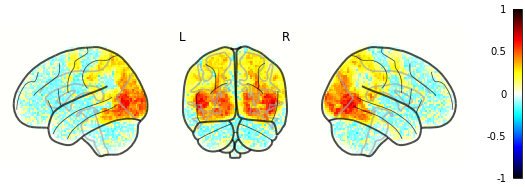

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


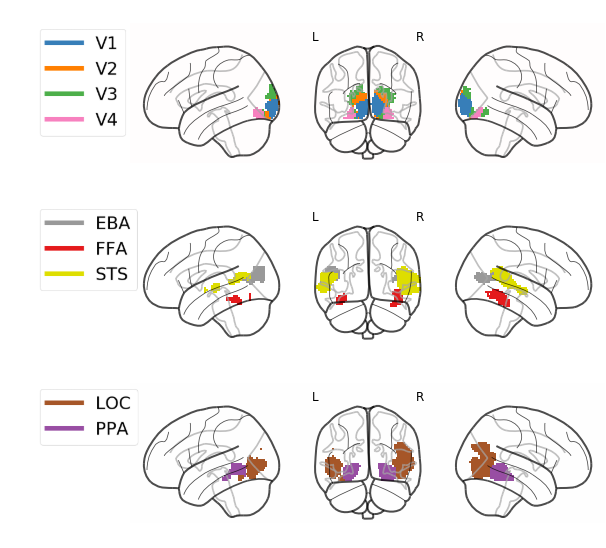

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set.

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI.

In [ ]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021'
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

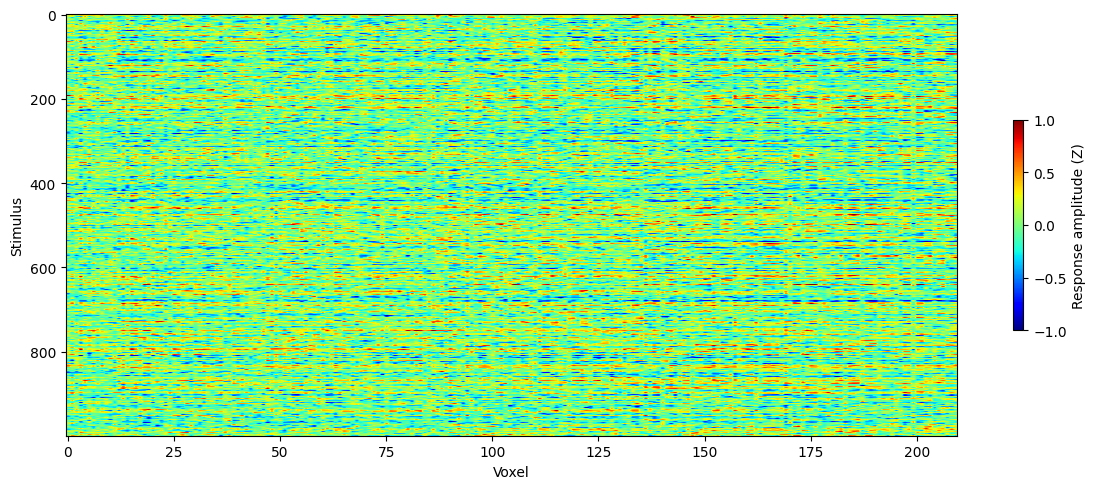

In [ ]:
#@title Loading fMRI data and inspecting dimensions
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

ROI = 'FFA'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = '/content/participants_data_v2021'
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
results_dir = '/content/'
track_dir = os.path.join(fmri_dir, track)
sub_fmri_dir = os.path.join(track_dir, sub)
if track == "full_track":
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################


f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html).

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [ ]:
#@title Visualize video
vid_id = 266 #@param {type: "integer"}
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

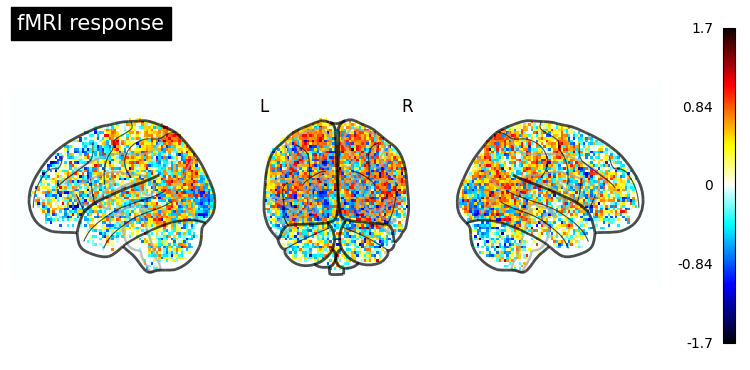

In [ ]:
#@title Visualize corresponding brain response
visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos.

# Vision Model definition (AlexNet)

Run the next cell to define the architecture of the model using pytorch.

BETTER VERSION OF ALEXNET USING LEAKY RELU WITH NEGATIVE SLOPES TO AVOID "Dying" ReLU Problem, PLEASE SEE HERE FOR MORE DETAILS: https://medium.com/@sreeku.ralla/activation-functions-relu-vs-leaky-relu-b8272dc0b1be

In [ ]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.LeakyReLU(negative_slope = 0.02, inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." `_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model


#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses.

In [ ]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """


    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

def print_alexnet_predictions(output):
    with open('class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    return results


def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    results_dict = {}

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==7:

                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        results = print_alexnet_predictions(feat) #results var
                        #results_dict[video_file] = results
                        #print(results_dict)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        results_dict[video_file] = results
        #print(results)

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)
    return results_dict

def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    train, test = {},{}
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train[layer] = x_train
        test[layer] = x_test
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)
    return train, test

In [ ]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))

Total Number of Videos:  1102


In [ ]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
results_dict = get_activations_and_save(model, video_list, activations_dir)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


  0%|          | 0/1102 [00:00<?, ?it/s]


Top-5 Predictions for the video id:  0001_0-0-1-6-7-2-8-0-17500167280
red-breasted merganser, Mergus serrator: 98.8487%
American coot, marsh hen, mud hen, water hen, Fulica americana: 1.1435%
lakeside, lakeshore: 0.0077%
drake: 0.0000%
little blue heron, Egretta caerulea: 0.0000%


  0%|          | 2/1102 [00:00<04:12,  4.36it/s]


Top-5 Predictions for the video id:  0002_0-0-4-3146384004
chain saw, chainsaw: 99.9655%
thresher, thrasher, threshing machine: 0.0341%
harvester, reaper: 0.0004%
tractor: 0.0000%
Scottish deerhound, deerhound: 0.0000%


  0%|          | 3/1102 [00:00<03:55,  4.66it/s]


Top-5 Predictions for the video id:  0003_0-0-8-1-2-4-0-0-3500812400
barrow, garden cart, lawn cart, wheelbarrow: 56.8993%
chain saw, chainsaw: 43.0394%
tricycle, trike, velocipede: 0.0267%
lawn mower, mower: 0.0238%
bow: 0.0094%


  0%|          | 4/1102 [00:00<03:56,  4.64it/s]


Top-5 Predictions for the video id:  0004_0-1-2-9-1-9-9-5-2401291995
muzzle: 98.0361%
swing: 1.8958%
plunger, plumber's helper: 0.0463%
lawn mower, mower: 0.0080%
bobsled, bobsleigh, bob: 0.0059%


  0%|          | 5/1102 [00:01<03:59,  4.58it/s]


Top-5 Predictions for the video id:  0005_0-1-7-8-3-6-4-8-4401783648
toyshop: 100.0000%
barbell: 0.0000%
stretcher: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%
golfcart, golf cart: 0.0000%

Top-5 Predictions for the video id:  0006_0-1-9-9-8-6-5-9-4701998659
grocery store, grocery, food market, market: 99.9997%
bakery, bakeshop, bakehouse: 0.0003%
shoe shop, shoe-shop, shoe store: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%
confectionery, confectionary, candy store: 0.0000%


  1%|          | 7/1102 [00:01<03:46,  4.83it/s]


Top-5 Predictions for the video id:  0007_0-2-3-14056753023
restaurant, eating house, eating place, eatery: 100.0000%
shoe shop, shoe-shop, shoe store: 0.0000%
grand piano, grand: 0.0000%
marimba, xylophone: 0.0000%
library: 0.0000%

Top-5 Predictions for the video id:  0008_0-2-9-6-5-7-2-3-16002965723_1
dishwasher, dish washer, dishwashing machine: 99.9868%
desk: 0.0116%
refrigerator, icebox: 0.0012%
printer: 0.0003%
beaker: 0.0001%


  1%|          | 9/1102 [00:01<03:31,  5.17it/s]


Top-5 Predictions for the video id:  0009_0-3-5-4-1-3-6-2-8603541362
iron, smoothing iron: 55.7991%
dumbbell: 10.0623%
oxygen mask: 9.7698%
plastic bag: 6.3836%
muzzle: 4.7768%


  1%|          | 10/1102 [00:02<03:39,  4.97it/s]


Top-5 Predictions for the video id:  0010_0-3-6-10842732036
restaurant, eating house, eating place, eatery: 99.8896%
dining table, board: 0.1104%
patio, terrace: 0.0001%
marimba, xylophone: 0.0000%
horse cart, horse-cart: 0.0000%

Top-5 Predictions for the video id:  0011_0-3-6-2-3-3-4-4-8103623344


  1%|          | 11/1102 [00:02<03:40,  4.94it/s]

restaurant, eating house, eating place, eatery: 87.5843%
grocery store, grocery, food market, market: 12.3837%
dining table, board: 0.0320%
bakery, bakeshop, bakehouse: 0.0000%
desk: 0.0000%

Top-5 Predictions for the video id:  0012_0-5-3-7-6-2-8-4-24105376284
bobsled, bobsleigh, bob: 98.5618%
racer, race car, racing car: 0.7746%
ambulance: 0.5883%
bullet train, bullet: 0.0642%
tow truck, tow car, wrecker: 0.0037%


  1%|          | 13/1102 [00:02<03:36,  5.02it/s]


Top-5 Predictions for the video id:  0013_0-5-3-8-6-8-2-6-4805386826
Ibizan hound, Ibizan Podenco: 89.1505%
Chihuahua: 8.2991%
Labrador retriever: 2.3732%
wire-haired fox terrier: 0.0896%
Brittany spaniel: 0.0419%


  1%|▏         | 14/1102 [00:02<03:29,  5.19it/s]


Top-5 Predictions for the video id:  0014_0-5-6-8272016056_edit
potter's wheel: 99.7630%
oxygen mask: 0.2018%
stretcher: 0.0352%
toyshop: 0.0000%
lab coat, laboratory coat: 0.0000%

Top-5 Predictions for the video id:  0015_0-6-1-9759583061
toyshop: 99.9355%
plunger, plumber's helper: 0.0456%
chain saw, chainsaw: 0.0186%
torch: 0.0001%
lawn mower, mower: 0.0001%


  2%|▏         | 17/1102 [00:03<02:51,  6.31it/s]


Top-5 Predictions for the video id:  0016_0-6-6-1-5-8-2-5-14806615825
iron, smoothing iron: 99.9316%
piggy bank, penny bank: 0.0329%
nipple: 0.0121%
sewing machine: 0.0094%
candle, taper, wax light: 0.0050%

Top-5 Predictions for the video id:  0017_0-7-3-5856076073
shopping cart: 69.1641%
chain saw, chainsaw: 22.7037%
oxcart: 3.4688%
Afghan hound, Afghan: 3.4165%
stretcher: 0.4125%


  2%|▏         | 19/1102 [00:03<02:33,  7.07it/s]


Top-5 Predictions for the video id:  0018_0-7-7-9-8-1-7-4-24407798174
stretcher: 99.9896%
bobsled, bobsleigh, bob: 0.0104%
ski: 0.0000%
French bulldog: 0.0000%
oxygen mask: 0.0000%

Top-5 Predictions for the video id:  0019_0-7-9-9-7-7-1-5-4307997715
fox squirrel, eastern fox squirrel, Sciurus niger: 99.9996%
grey fox, gray fox, Urocyon cinereoargenteus: 0.0004%
meerkat, mierkat: 0.0000%
Egyptian cat: 0.0000%
muzzle: 0.0000%


  2%|▏         | 20/1102 [00:03<02:26,  7.37it/s]


Top-5 Predictions for the video id:  0020_0-8-0-0-3-9-3-9-7108003939
mortarboard: 78.2837%
printer: 21.3432%
Christmas stocking: 0.1297%
feather boa, boa: 0.1119%
carton: 0.0409%

Top-5 Predictions for the video id:  0021_0-8-0-8-6-5-4-5-4708086545
mongoose: 74.5429%
tennis ball: 24.3600%
hatchet: 0.6613%
meerkat, mierkat: 0.1887%
fox squirrel, eastern fox squirrel, Sciurus niger: 0.0953%


  2%|▏         | 22/1102 [00:03<02:25,  7.42it/s]


Top-5 Predictions for the video id:  0022_0-8-7-7-9-6-5-5-6508779655
waffle iron: 83.7476%
Crock Pot: 11.8679%
desk: 2.9746%
restaurant, eating house, eating place, eatery: 0.9534%
sewing machine: 0.4532%

Top-5 Predictions for the video id:  0023_0-8-8-7346836088
sewing machine: 99.6221%
stretcher: 0.1838%
neck brace: 0.1159%
shopping basket: 0.0308%
barbell: 0.0287%


  2%|▏         | 25/1102 [00:04<02:16,  7.92it/s]


Top-5 Predictions for the video id:  0024_0-9-3-5943645093
oxcart: 80.8486%
golfcart, golf cart: 19.0808%
Weimaraner: 0.0416%
potter's wheel: 0.0246%
Bedlington terrier: 0.0013%

Top-5 Predictions for the video id:  0025_0-9-5-1-8-2-6-6-4009518266
warplane, military plane: 99.9874%
airliner: 0.0119%
projectile, missile: 0.0006%
stretcher: 0.0000%
wing: 0.0000%


  2%|▏         | 27/1102 [00:04<02:14,  8.02it/s]


Top-5 Predictions for the video id:  0026_0-9-9-8-0-5-8-5-4909980585
stretcher: 70.0917%
horse cart, horse-cart: 27.5389%
ambulance: 1.7031%
barbell: 0.5870%
limousine, limo: 0.0290%

Top-5 Predictions for the video id:  0027_03chvdioZYI_85
flute, transverse flute: 99.9532%
trombone: 0.0442%
cornet, horn, trumpet, trump: 0.0024%
steel drum: 0.0002%
banjo: 0.0001%


  3%|▎         | 29/1102 [00:04<02:11,  8.18it/s]


Top-5 Predictions for the video id:  0028_0P6FNr_6XWo_35
stretcher: 90.6675%
oxygen mask: 5.6128%
tricycle, trike, velocipede: 2.9589%
moped: 0.7600%
banjo: 0.0005%

Top-5 Predictions for the video id:  0029_1-0-7-2-7-1-8-6-2810727186
sewing machine: 98.0005%
dishwasher, dish washer, dishwashing machine: 1.4679%
hair spray: 0.4524%
oxygen mask: 0.0741%
plunger, plumber's helper: 0.0015%


  3%|▎         | 30/1102 [00:04<02:14,  7.96it/s]


Top-5 Predictions for the video id:  0030_1-1-5-6-1-6-5-2-2811561652
diaper, nappy, napkin: 99.6891%
toyshop: 0.2623%
shower cap: 0.0475%
bib: 0.0005%
maraca: 0.0004%

Top-5 Predictions for the video id:  0031_1-1-8-8-3-2-8-3-13711883283
ski: 99.9402%
bow: 0.0315%
reel: 0.0231%
warplane, military plane: 0.0045%
parachute, chute: 0.0004%


  3%|▎         | 32/1102 [00:05<02:11,  8.12it/s]


Top-5 Predictions for the video id:  0032_1-2-0-9-0-9-1-6-3812090916_61
hand blower, blow dryer, blow drier, hair dryer, hair drier: 99.4941%
projector: 0.4817%
whistle: 0.0113%
Polaroid camera, Polaroid Land camera: 0.0078%
dumbbell: 0.0046%

Top-5 Predictions for the video id:  0033_1-2-5-1-2-7-6-2-2512512762
lakeside, lakeshore: 97.4918%
projectile, missile: 2.4484%
missile: 0.0279%
bathtub, bathing tub, bath, tub: 0.0165%
airship, dirigible: 0.0087%


  3%|▎         | 35/1102 [00:05<02:15,  7.86it/s]


Top-5 Predictions for the video id:  0034_1-2-5-3344278125
moped: 94.3748%
bicycle-built-for-two, tandem bicycle, tandem: 3.6002%
tricycle, trike, velocipede: 2.0249%
motor scooter, scooter: 0.0000%
mountain bike, all-terrain bike, off-roader: 0.0000%

Top-5 Predictions for the video id:  0035_1-2-6-3176369126
bobsled, bobsleigh, bob: 99.9485%
snowmobile: 0.0328%
ski: 0.0091%
shovel: 0.0080%
tub, vat: 0.0014%


  3%|▎         | 36/1102 [00:05<02:13,  7.96it/s]


Top-5 Predictions for the video id:  0036_1-2-6-9-6-8-2-1-22212696821
Chihuahua: 80.7675%
Egyptian cat: 9.0409%
oxygen mask: 6.2060%
tabby, tabby cat: 2.0343%
plastic bag: 1.3718%

Top-5 Predictions for the video id:  0037_1-3-9-9-9-6-4-3-3213999643
plate: 66.8229%
hot pot, hotpot: 33.1657%
wok: 0.0060%
potter's wheel: 0.0051%
cleaver, meat cleaver, chopper: 0.0001%


  4%|▎         | 39/1102 [00:06<02:11,  8.06it/s]


Top-5 Predictions for the video id:  0038_1-4-3-5-8-6-2-5-3114358625
ski: 90.1879%
swing: 8.1712%
shovel: 1.0614%
power drill: 0.1890%
umbrella: 0.1597%

Top-5 Predictions for the video id:  0039_1-4-4-4086629144
stretcher: 72.5535%
catamaran: 21.0869%
barber chair: 1.4797%
lab coat, laboratory coat: 1.0547%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 0.9249%


  4%|▎         | 41/1102 [00:06<02:10,  8.12it/s]


Top-5 Predictions for the video id:  0040_1-4-8-8-7-8-7-5-3914887875_56
sewing machine: 54.8718%
apiary, bee house: 41.7505%
refrigerator, icebox: 1.6886%
screen, CRT screen: 0.9532%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.2242%

Top-5 Predictions for the video id:  0041_1-5-0-0-4-9-7-8-2915004978_2
lawn mower, mower: 99.9988%
barrow, garden cart, lawn cart, wheelbarrow: 0.0010%
chain saw, chainsaw: 0.0002%
tennis ball: 0.0000%
tricycle, trike, velocipede: 0.0000%


  4%|▍         | 42/1102 [00:06<02:11,  8.04it/s]


Top-5 Predictions for the video id:  0042_1-5-8-9-2-4-5-4-7815892454
balance beam, beam: 68.0805%
horizontal bar, high bar: 21.6325%
parallel bars, bars: 7.8499%
stretcher: 1.3326%
racket, racquet: 0.5583%

Top-5 Predictions for the video id:  0043_1-6-0-2796094160
scuba diver: 100.0000%
oxygen mask: 0.0000%
snorkel: 0.0000%
comic book: 0.0000%
gasmask, respirator, gas helmet: 0.0000%


  4%|▍         | 45/1102 [00:06<02:12,  7.95it/s]


Top-5 Predictions for the video id:  0044_1-6-0-7-7-6-4-6-7816077646
oxcart: 64.3058%
thresher, thrasher, threshing machine: 35.6942%
tractor: 0.0000%
harvester, reaper: 0.0000%
garbage truck, dustcart: 0.0000%

Top-5 Predictions for the video id:  0045_1-6-8-0-7-6-7-4-3816807674
oxygen mask: 94.6176%
neck brace: 4.8261%
whistle: 0.3043%
stethoscope: 0.2324%
hair spray: 0.0162%


  4%|▍         | 46/1102 [00:06<02:12,  7.96it/s]


Top-5 Predictions for the video id:  0046_1-6-8-5795643168
fountain: 98.1637%
valley, vale: 1.8354%
macaque: 0.0004%
geyser: 0.0002%
cliff, drop, drop-off: 0.0001%

Top-5 Predictions for the video id:  0047_1-7-1-8-6-3-6-2-3417186362
warplane, military plane: 99.9846%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.0153%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 0.0001%
projectile, missile: 0.0000%
amphibian, amphibious vehicle: 0.0000%


  4%|▍         | 49/1102 [00:07<02:13,  7.91it/s]


Top-5 Predictions for the video id:  0048_1-7-2-5-5-0-7-5-25617255075
chain saw, chainsaw: 99.9963%
assault rifle, assault gun: 0.0030%
rifle: 0.0004%
power drill: 0.0001%
Great Dane: 0.0001%

Top-5 Predictions for the video id:  0049_1-7-4-5-3-8-3-6-3017453836
steel drum: 99.9983%
stretcher: 0.0016%
drum, membranophone, tympan: 0.0001%
toyshop: 0.0000%
Saluki, gazelle hound: 0.0000%


  5%|▍         | 51/1102 [00:07<02:09,  8.11it/s]


Top-5 Predictions for the video id:  0050_1-8-5-7127344185
shopping cart: 95.8396%
fireboat: 2.1811%
catamaran: 0.7951%
amphibian, amphibious vehicle: 0.5518%
garbage truck, dustcart: 0.2471%

Top-5 Predictions for the video id:  0051_1-8-7-1-1-9-6-6-5418711966
chain saw, chainsaw: 99.9992%
lawn mower, mower: 0.0005%
tricycle, trike, velocipede: 0.0003%
snowplow, snowplough: 0.0000%
bobsled, bobsleigh, bob: 0.0000%


  5%|▍         | 52/1102 [00:07<02:12,  7.93it/s]


Top-5 Predictions for the video id:  0052_1-9-3-0-9-4-6-4-4719309464
oxcart: 100.0000%
horse cart, horse-cart: 0.0000%
Arabian camel, dromedary, Camelus dromedarius: 0.0000%
Indian elephant, Elephas maximus: 0.0000%
Irish wolfhound: 0.0000%

Top-5 Predictions for the video id:  0053_1-9-3-2-8-0-1-3-3919328013
thresher, thrasher, threshing machine: 99.6815%
harvester, reaper: 0.2990%
tractor: 0.0098%
horse cart, horse-cart: 0.0097%
oxcart: 0.0000%


  5%|▍         | 55/1102 [00:08<02:09,  8.05it/s]


Top-5 Predictions for the video id:  0054_1-9-3-9-3-8-2-2-23719393822
fountain: 99.9999%
cannon: 0.0001%
hare: 0.0000%
space shuttle: 0.0000%
Bedlington terrier: 0.0000%

Top-5 Predictions for the video id:  0055_1-9-6-7-5-1-9-8-3119675198
grocery store, grocery, food market, market: 63.7318%
scale, weighing machine: 11.9714%
potter's wheel: 11.4626%
sewing machine: 9.3230%
shopping basket: 1.6793%


  5%|▌         | 57/1102 [00:08<02:06,  8.29it/s]


Top-5 Predictions for the video id:  0056_2-0-0-3614591200
seashore, coast, seacoast, sea-coast: 87.9270%
otter: 7.4586%
geyser: 3.0165%
promontory, headland, head, foreland: 1.0605%
albatross, mollymawk: 0.3919%

Top-5 Predictions for the video id:  0057_2-0-9-8159444209
dam, dike, dyke: 100.0000%
fountain: 0.0000%
fireboat: 0.0000%
steam locomotive: 0.0000%
cannon: 0.0000%


  5%|▌         | 59/1102 [00:08<02:06,  8.27it/s]


Top-5 Predictions for the video id:  0058_2-4-3-5345273243
stage: 98.7740%
grocery store, grocery, food market, market: 1.1246%
bow: 0.0645%
flute, transverse flute: 0.0154%
restaurant, eating house, eating place, eatery: 0.0109%

Top-5 Predictions for the video id:  0059_2-5-7-6889839257
garbage truck, dustcart: 89.5997%
stretcher: 6.7011%
amphibian, amphibious vehicle: 3.1249%
chain saw, chainsaw: 0.3136%
moving van: 0.1001%


  6%|▌         | 61/1102 [00:08<02:05,  8.29it/s]


Top-5 Predictions for the video id:  0060_2-6-5-12330534265
toyshop: 97.1029%
refrigerator, icebox: 2.8406%
sewing machine: 0.0525%
desk: 0.0027%
paper towel: 0.0008%

Top-5 Predictions for the video id:  0061_2-9-5-4309863295
oxygen mask: 99.9891%
barbershop: 0.0109%
hair spray: 0.0000%
Italian greyhound: 0.0000%
power drill: 0.0000%


  6%|▌         | 62/1102 [00:08<02:12,  7.83it/s]


Top-5 Predictions for the video id:  0062_2EMSeADyrrQ_35
shopping basket: 99.9947%
shopping cart: 0.0053%
muzzle: 0.0000%
swab, swob, mop: 0.0000%
paintbrush: 0.0000%

Top-5 Predictions for the video id:  0063_2Ng8UYBFhbU_91
Lakeland terrier: 99.3317%
African chameleon, Chamaeleo chamaeleon: 0.6498%
coyote, prairie wolf, brush wolf, Canis latrans: 0.0106%
lynx, catamount: 0.0063%
Airedale, Airedale terrier: 0.0009%


  6%|▌         | 65/1102 [00:09<02:09,  8.02it/s]


Top-5 Predictions for the video id:  0064_2Tm26dLw29A_69
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
harvester, reaper: 0.0000%
broom: 0.0000%
lawn mower, mower: 0.0000%
park bench: 0.0000%

Top-5 Predictions for the video id:  0065_2aG9AaxuGSU_148
television, television system: 99.8834%
teddy, teddy bear: 0.0864%
marimba, xylophone: 0.0299%
monitor: 0.0003%
toyshop: 0.0001%


  6%|▌         | 67/1102 [00:09<02:06,  8.19it/s]


Top-5 Predictions for the video id:  0066_2cCnDHUV0W8_35
gasmask, respirator, gas helmet: 97.9805%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 1.5100%
neck brace: 0.3222%
miniskirt, mini: 0.1484%
hair spray: 0.0139%

Top-5 Predictions for the video id:  0067_2h1Mj2ymyj8_121
horse cart, horse-cart: 89.9018%
oxcart: 10.0869%
stretcher: 0.0075%
golfcart, golf cart: 0.0027%
standard schnauzer: 0.0006%


  6%|▋         | 69/1102 [00:09<02:08,  8.07it/s]


Top-5 Predictions for the video id:  0068_3-0-4-4343808304
grocery store, grocery, food market, market: 99.9998%
confectionery, confectionary, candy store: 0.0002%
toyshop: 0.0000%
bakery, bakeshop, bakehouse: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%

Top-5 Predictions for the video id:  0069_3-0-5-3-4-3-5-2-4730534352
oxcart: 99.9758%
chain saw, chainsaw: 0.0203%
stretcher: 0.0038%
ox: 0.0000%
Afghan hound, Afghan: 0.0000%


  6%|▋         | 71/1102 [00:10<02:14,  7.69it/s]


Top-5 Predictions for the video id:  0070_3-3-6-8-2-7-6-6-3533682766
barrow, garden cart, lawn cart, wheelbarrow: 99.9894%
Labrador retriever: 0.0103%
tennis ball: 0.0002%
muzzle: 0.0001%
bucket, pail: 0.0000%

Top-5 Predictions for the video id:  0071_3-4-9-8-4-7-4-8-4434984748
amphibian, amphibious vehicle: 69.1798%
catamaran: 9.9605%
missile: 8.0814%
stretcher: 7.9804%
projectile, missile: 4.4505%


  7%|▋         | 73/1102 [00:10<02:08,  8.02it/s]


Top-5 Predictions for the video id:  0072_3-5-0-4261181350
potter's wheel: 86.9830%
toyshop: 7.2737%
stretcher: 5.5589%
library: 0.1831%
grocery store, grocery, food market, market: 0.0009%

Top-5 Predictions for the video id:  0073_3-5-8-9-9-5-9-8-4335899598
power drill: 50.7291%
plunger, plumber's helper: 25.3221%
chain saw, chainsaw: 21.9820%
Italian greyhound: 1.7463%
shovel: 0.1017%


  7%|▋         | 75/1102 [00:10<02:04,  8.25it/s]


Top-5 Predictions for the video id:  0074_3-6-5-3-3-4-4-5-23036533445
toyshop: 99.9937%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0062%
kimono: 0.0001%
comic book: 0.0000%
confectionery, confectionary, candy store: 0.0000%

Top-5 Predictions for the video id:  0075_3-7-0-7-1-5-3-0-4937071530
oxygen mask: 99.8900%
cleaver, meat cleaver, chopper: 0.0841%
neck brace: 0.0235%
power drill: 0.0018%
stretcher: 0.0004%


  7%|▋         | 77/1102 [00:10<02:03,  8.29it/s]


Top-5 Predictions for the video id:  0076_3-7-3-13269577373
trimaran: 87.4337%
speedboat: 12.5493%
lifeboat: 0.0169%
yawl: 0.0001%
dock, dockage, docking facility: 0.0000%

Top-5 Predictions for the video id:  0077_3-7-3-7-1-7-0-1-2537371701
shopping basket: 93.6875%
neck brace: 5.3944%
scale, weighing machine: 0.8001%
gasmask, respirator, gas helmet: 0.0737%
mouse, computer mouse: 0.0167%


  7%|▋         | 78/1102 [00:10<02:09,  7.91it/s]


Top-5 Predictions for the video id:  0078_3-7-5-4-7-7-8-9-8037547789
dishwasher, dish washer, dishwashing machine: 94.0724%
four-poster: 5.5801%
studio couch, day bed: 0.3199%
desk: 0.0110%
dining table, board: 0.0067%

Top-5 Predictions for the video id:  0079_3-7-5-6-6-4-1-7-3437566417
moped: 92.6206%
bicycle-built-for-two, tandem bicycle, tandem: 5.9501%
motor scooter, scooter: 1.1730%
horse cart, horse-cart: 0.1094%
bow: 0.0645%


  7%|▋         | 81/1102 [00:11<02:03,  8.27it/s]


Top-5 Predictions for the video id:  0080_3-9-0-6-4-2-6-6-3339064266
shopping basket: 96.5722%
chain saw, chainsaw: 3.4028%
thresher, thrasher, threshing machine: 0.0121%
tractor: 0.0065%
bow: 0.0038%

Top-5 Predictions for the video id:  0081_4-0-6-7-6-1-4-5-4540676145
hamster: 99.9293%
Angora, Angora rabbit: 0.0469%
Pomeranian: 0.0180%
ice lolly, lolly, lollipop, popsicle: 0.0040%
Chihuahua: 0.0017%


  8%|▊         | 83/1102 [00:11<01:59,  8.53it/s]


Top-5 Predictions for the video id:  0082_4-2-5-6-5-3-6-5-16342565365
acoustic guitar: 98.8638%
electric guitar: 1.0986%
power drill: 0.0137%
banjo: 0.0128%
punching bag, punch bag, punching ball, punchball: 0.0069%

Top-5 Predictions for the video id:  0083_4-3-3-1-0-6-4-0-8743310640
beaker: 99.9997%
dishwasher, dish washer, dishwashing machine: 0.0002%
oxygen mask: 0.0001%
cocktail shaker: 0.0000%
strainer: 0.0000%


  8%|▊         | 85/1102 [00:11<02:02,  8.30it/s]


Top-5 Predictions for the video id:  0084_4-3-4-8736778434
carousel, carrousel, merry-go-round, roundabout, whirligig: 95.9633%
oxygen mask: 3.2327%
sunglasses, dark glasses, shades: 0.5174%
power drill: 0.1158%
shopping basket: 0.0763%

Top-5 Predictions for the video id:  0085_4-3-5-6-0-8-0-8-5543560808
Great Pyrenees: 99.9234%
Samoyed, Samoyede: 0.0613%
bobsled, bobsleigh, bob: 0.0114%
shovel: 0.0027%
soap dispenser: 0.0008%


  8%|▊         | 86/1102 [00:11<02:04,  8.16it/s]


Top-5 Predictions for the video id:  0086_4-3-5-9059723435
nipple: 62.1384%
dishwasher, dish washer, dishwashing machine: 37.5892%
oxygen mask: 0.1755%
ice lolly, lolly, lollipop, popsicle: 0.0685%
shopping basket: 0.0118%

Top-5 Predictions for the video id:  0087_4-3-7-4396869437
stretcher: 99.1049%
Bedlington terrier: 0.5355%
Eskimo dog, husky: 0.1360%
sewing machine: 0.1316%
Siberian husky: 0.0518%


  8%|▊         | 89/1102 [00:12<02:04,  8.14it/s]


Top-5 Predictions for the video id:  0088_4-3-7-4889733437
power drill: 99.8381%
oxygen mask: 0.1544%
stretcher: 0.0057%
barbershop: 0.0009%
wok: 0.0004%

Top-5 Predictions for the video id:  0089_4-3-8-2-7-7-4-3-9043827743
timber wolf, grey wolf, gray wolf, Canis lupus: 99.9742%
valley, vale: 0.0247%
coyote, prairie wolf, brush wolf, Canis latrans: 0.0005%
African chameleon, Chamaeleo chamaeleon: 0.0004%
common iguana, iguana, Iguana iguana: 0.0002%


  8%|▊         | 91/1102 [00:12<02:05,  8.04it/s]


Top-5 Predictions for the video id:  0090_4-4-7-5-2-9-5-4-4744752954
paddle, boat paddle: 99.9999%
canoe: 0.0001%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
chain saw, chainsaw: 0.0000%
lawn mower, mower: 0.0000%

Top-5 Predictions for the video id:  0091_4-5-0-1-4-3-5-1-15645014351
snowplow, snowplough: 84.7718%
amphibian, amphibious vehicle: 15.2276%
catamaran: 0.0005%
chain saw, chainsaw: 0.0001%
trimaran: 0.0000%


  8%|▊         | 93/1102 [00:12<02:02,  8.26it/s]


Top-5 Predictions for the video id:  0092_4-5-7-1-7-9-4-4-5945717944
stretcher: 70.9454%
moped: 14.8007%
bow: 8.8790%
tricycle, trike, velocipede: 4.7900%
warplane, military plane: 0.5094%

Top-5 Predictions for the video id:  0093_4-5-7-5265004457
spatula: 96.4179%
burrito: 3.3036%
plate: 0.1413%
eggnog: 0.1191%
candle, taper, wax light: 0.0086%


  9%|▊         | 94/1102 [00:12<02:05,  8.03it/s]


Top-5 Predictions for the video id:  0094_4-5-9-2-3-0-7-9-15245923079
snorkel: 75.3645%
barrow, garden cart, lawn cart, wheelbarrow: 21.0828%
sturgeon: 1.2018%
sunglass: 0.8883%
bucket, pail: 0.3510%

Top-5 Predictions for the video id:  0095_4-6-1-9-8-5-2-4-25546198524
parallel bars, bars: 99.3806%
horizontal bar, high bar: 0.5794%
bow: 0.0388%
barbell: 0.0011%
ballplayer, baseball player: 0.0000%


  9%|▊         | 96/1102 [00:13<02:11,  7.66it/s]


Top-5 Predictions for the video id:  0096_4-7-1-1-2-8-3-0-25247112830
speedboat: 99.9999%
amphibian, amphibious vehicle: 0.0001%
canoe: 0.0000%
boathouse: 0.0000%
catamaran: 0.0000%

Top-5 Predictions for the video id:  0097_4-7-9-4959184479
toyshop: 96.8684%
plunger, plumber's helper: 1.6125%
oxygen mask: 0.5199%
hair spray: 0.4948%
Afghan hound, Afghan: 0.2699%


  9%|▉         | 98/1102 [00:13<02:34,  6.50it/s]


Top-5 Predictions for the video id:  0098_4-7-9-5224564479
barbell: 100.0000%
dishwasher, dish washer, dishwashing machine: 0.0000%
dumbbell: 0.0000%
vacuum, vacuum cleaner: 0.0000%
library: 0.0000%

Top-5 Predictions for the video id:  0099_4-7-9-5897473479
stretcher: 100.0000%
oxcart: 0.0000%
Great Dane: 0.0000%
horse cart, horse-cart: 0.0000%
Saluki, gazelle hound: 0.0000%


  9%|▉         | 100/1102 [00:13<02:46,  6.01it/s]


Top-5 Predictions for the video id:  0100_4-7-9-7-6-5-8-0-2647976580
balance beam, beam: 89.7076%
ping-pong ball: 10.0592%
horizontal bar, high bar: 0.1219%
parallel bars, bars: 0.1005%
bathing cap, swimming cap: 0.0108%

Top-5 Predictions for the video id:  0101_4-8-4-5-2-8-6-4-12748452864
geyser: 92.8956%
Samoyed, Samoyede: 5.8328%
Angora, Angora rabbit: 0.4749%
Arctic fox, white fox, Alopex lagopus: 0.3918%
missile: 0.1687%


  9%|▉         | 102/1102 [00:14<02:58,  5.61it/s]


Top-5 Predictions for the video id:  0102_4-8-9-2-5-7-3-1-3848925731
oxygen mask: 75.7473%
bathing cap, swimming cap: 23.1257%
ice lolly, lolly, lollipop, popsicle: 0.9523%
barbell: 0.1373%
hair spray: 0.0145%

Top-5 Predictions for the video id:  0103_4-9-0-4-8-4-8-7-3949048487
geyser: 100.0000%
fountain: 0.0000%
Arctic fox, white fox, Alopex lagopus: 0.0000%
Eskimo dog, husky: 0.0000%
screen, CRT screen: 0.0000%


  9%|▉         | 104/1102 [00:14<02:56,  5.65it/s]


Top-5 Predictions for the video id:  0104_4_mAU3U33fU_224
thresher, thrasher, threshing machine: 59.5726%
fire engine, fire truck: 34.4927%
harvester, reaper: 2.9858%
tractor: 2.6610%
snowplow, snowplough: 0.2290%

Top-5 Predictions for the video id:  0105_5-0-2-9044555502
half track: 99.9998%
garbage truck, dustcart: 0.0002%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 0.0000%
tow truck, tow car, wrecker: 0.0000%
amphibian, amphibious vehicle: 0.0000%


 10%|▉         | 106/1102 [00:14<03:01,  5.48it/s]


Top-5 Predictions for the video id:  0106_5-0-6-7-7-5-7-6-14950677576_1
shopping cart: 98.0320%
patio, terrace: 1.8988%
amphibian, amphibious vehicle: 0.0556%
garbage truck, dustcart: 0.0074%
barrow, garden cart, lawn cart, wheelbarrow: 0.0058%

Top-5 Predictions for the video id:  0107_5-2-4-5-8-0-7-9-4752458079
thresher, thrasher, threshing machine: 95.7681%
harvester, reaper: 3.9324%
fire engine, fire truck: 0.1063%
guillotine: 0.1001%
lumbermill, sawmill: 0.0657%


 10%|▉         | 108/1102 [00:15<03:13,  5.13it/s]


Top-5 Predictions for the video id:  0108_5-3-4-9966677534
paddle, boat paddle: 64.3834%
canoe: 35.2811%
amphibian, amphibious vehicle: 0.1325%
speedboat: 0.1246%
snorkel: 0.0636%

Top-5 Predictions for the video id:  0109_5-3-7-1-9-2-1-2-3453719212
cleaver, meat cleaver, chopper: 59.6688%
plate: 27.0817%
soap dispenser: 5.4743%
shopping basket: 4.3802%
candle, taper, wax light: 1.6695%


 10%|▉         | 110/1102 [00:15<03:04,  5.39it/s]


Top-5 Predictions for the video id:  0110_5-4-0-2405298540
trimaran: 99.9045%
catamaran: 0.0954%
mousetrap: 0.0001%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.0000%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 0.0000%

Top-5 Predictions for the video id:  0111_5-4-2-6-1-5-0-7-5654261507
ox: 57.1577%
Afghan hound, Afghan: 42.5093%
Norwegian elkhound, elkhound: 0.1578%
oxcart: 0.0853%
Labrador retriever: 0.0408%


 10%|█         | 112/1102 [00:16<03:20,  4.95it/s]


Top-5 Predictions for the video id:  0112_5-4-2-6-3-7-5-4-7854263754
Old English sheepdog, bobtail: 99.2046%
Lakeland terrier: 0.5451%
llama: 0.2410%
barrow, garden cart, lawn cart, wheelbarrow: 0.0075%
skunk, polecat, wood pussy: 0.0012%


 10%|█         | 113/1102 [00:16<03:18,  4.99it/s]


Top-5 Predictions for the video id:  0113_5-4-3-5-0-8-5-4-13654350854_22
oxygen mask: 99.6337%
gasmask, respirator, gas helmet: 0.2679%
hair spray: 0.0918%
laptop, laptop computer: 0.0033%
potter's wheel: 0.0020%

Top-5 Predictions for the video id:  0114_5-4-5-2-2-4-8-5-8454522485
wok: 99.9933%
stretcher: 0.0025%
waffle iron: 0.0015%
frying pan, frypan, skillet: 0.0013%
hot pot, hotpot: 0.0009%


 10%|█         | 115/1102 [00:16<03:20,  4.93it/s]


Top-5 Predictions for the video id:  0115_5-4-5-4-1-8-6-5-8254541865_29
macaque: 99.9981%
briard: 0.0010%
beaver: 0.0006%
Irish wolfhound: 0.0001%
hog, pig, grunter, squealer, Sus scrofa: 0.0001%

Top-5 Predictions for the video id:  0116_5-6-5-5-1-6-7-5-23256551675
face powder: 59.4594%
Petri dish: 27.0010%
beaker: 12.2786%
consomme: 1.0744%
eggnog: 0.1840%


 11%|█         | 117/1102 [00:17<03:14,  5.06it/s]


Top-5 Predictions for the video id:  0117_5-6-6-3042970566
standard poodle: 98.1809%
lab coat, laboratory coat: 0.7879%
Samoyed, Samoyede: 0.5885%
Great Pyrenees: 0.4225%
miniature poodle: 0.0100%

Top-5 Predictions for the video id: 

 11%|█         | 118/1102 [00:17<03:17,  4.98it/s]

 0118_5-6-7-7-6-0-9-9-3756776099
barrow, garden cart, lawn cart, wheelbarrow: 97.6455%
ox: 2.0171%
llama: 0.2773%
Bouvier des Flandres, Bouviers des Flandres: 0.0486%
fountain: 0.0104%


 11%|█         | 119/1102 [00:17<03:25,  4.78it/s]


Top-5 Predictions for the video id:  0119_5-7-0-7-8-9-1-3-4257078913
Afghan hound, Afghan: 99.9701%
toyshop: 0.0278%
steel drum: 0.0006%
marimba, xylophone: 0.0004%
accordion, piano accordion, squeeze box: 0.0003%


 11%|█         | 120/1102 [00:17<03:25,  4.78it/s]


Top-5 Predictions for the video id:  0120_5-7-5-3760841575
paddle, boat paddle: 99.8388%
chain saw, chainsaw: 0.1413%
barrow, garden cart, lawn cart, wheelbarrow: 0.0081%
speedboat: 0.0055%
umbrella: 0.0016%


 11%|█         | 121/1102 [00:18<03:26,  4.76it/s]


Top-5 Predictions for the video id:  0121_5-7-6-1-2-1-4-3-17357612143
titi, titi monkey: 94.3217%
squirrel monkey, Saimiri sciureus: 4.7142%
spider monkey, Ateles geoffroyi: 0.7121%
jacamar: 0.1333%
African chameleon, Chamaeleo chamaeleon: 0.0588%

Top-5 Predictions for the video id:  0122_5-7-6-9-5-4-8-2-5457695482
ice lolly, lolly, lollipop, popsicle: 95.2157%
cleaver, meat cleaver, chopper: 3.8675%

 11%|█         | 122/1102 [00:18<03:20,  4.89it/s]


diaper, nappy, napkin: 0.4138%
nipple: 0.2069%
laptop, laptop computer: 0.1075%

Top-5 Predictions for the video id:  0123_5-9-0-1-9-6-9-0-5259019690
pinwheel: 99.1904%
whistle: 0.7870%

 11%|█         | 123/1102 [00:18<03:17,  4.95it/s]


pencil sharpener: 0.0119%
rubber eraser, rubber, pencil eraser: 0.0099%
bow tie, bow-tie, bowtie: 0.0004%

Top-5 Predictions for the video id:  0124_5-9-1-5611850591
scale, weighing machine: 89.5277%
sewing machine: 10.0164%
shopping cart: 0.2906%
toyshop: 0.1189%
stretcher: 0.0380%


 11%|█▏        | 125/1102 [00:18<03:15,  4.99it/s]


Top-5 Predictions for the video id:  0125_5-9-4-9166960594
oxcart: 100.0000%
Afghan hound, Afghan: 0.0000%
steel drum: 0.0000%
horse cart, horse-cart: 0.0000%
ox: 0.0000%

Top-5 Predictions for the video id:  0126_5-9-7-5-7-9-9-8-2859757998
fountain: 88.2448%
cannon: 7.7075%
Madagascar cat, ring-tailed lemur, Lemur catta: 4.0273%
standard poodle: 0.0165%
kuvasz: 0.0014%


 12%|█▏        | 128/1102 [00:19<02:39,  6.11it/s]


Top-5 Predictions for the video id:  0127_5541389947
kimono: 99.8297%
toyshop: 0.1514%
steel drum: 0.0116%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0029%
punching bag, punch bag, punching ball, punchball: 0.0021%

Top-5 Predictions for the video id:  0128_5948238182
iron, smoothing iron: 90.2096%
notebook, notebook computer: 9.3847%
piggy bank, penny bank: 0.2314%
mouse, computer mouse: 0.1040%
maraca: 0.0309%


 12%|█▏        | 130/1102 [00:19<02:21,  6.85it/s]


Top-5 Predictions for the video id:  0129_5pZ8Z7icwxE_276
refrigerator, icebox: 99.3121%
library: 0.6863%
sewing machine: 0.0014%
shopping basket: 0.0001%
dishwasher, dish washer, dishwashing machine: 0.0000%

Top-5 Predictions for the video id:  0130_6-0-7-6496350607
Irish wolfhound: 55.3196%
Saluki, gazelle hound: 44.6756%
Old English sheepdog, bobtail: 0.0046%
Great Pyrenees: 0.0001%
horizontal bar, high bar: 0.0000%


 12%|█▏        | 132/1102 [00:19<02:08,  7.54it/s]


Top-5 Predictions for the video id:  0131_6-0-9-5-1-4-3-4-3260951434
mousetrap: 99.9684%
Chihuahua: 0.0201%
muzzle: 0.0055%
cleaver, meat cleaver, chopper: 0.0050%
pencil sharpener: 0.0008%

Top-5 Predictions for the video id:  0132_6-1-0-8-4-3-3-3-2461084333
cradle: 99.5668%
brassiere, bra, bandeau: 0.1672%
soap dispenser: 0.0813%
plunger, plumber's helper: 0.0788%
plate: 0.0378%


 12%|█▏        | 133/1102 [00:19<02:05,  7.75it/s]


Top-5 Predictions for the video id:  0133_6-2-2-4-7-1-0-3-6562247103
dumbbell: 79.0642%
notebook, notebook computer: 15.1858%
golfcart, golf cart: 3.4697%
horizontal bar, high bar: 0.9823%
shoe shop, shoe-shop, shoe store: 0.6868%

Top-5 Predictions for the video id:  0134_6-3-7-7169142637
garbage truck, dustcart: 99.9634%
amphibian, amphibious vehicle: 0.0364%
tow truck, tow car, wrecker: 0.0002%
stretcher: 0.0000%
harvester, reaper: 0.0000%


 12%|█▏        | 135/1102 [00:20<02:05,  7.70it/s]


Top-5 Predictions for the video id:  0135_6-4-0-3-0-0-4-4-22064030044
basketball: 97.2063%
stretcher: 2.2922%
volleyball: 0.4577%
rifle: 0.0403%
Saluki, gazelle hound: 0.0013%

Top-5 Predictions for the video id:  0136_6-4-4-8-8-6-2-5-8164488625
wok: 98.8925%
frying pan, frypan, skillet: 1.1056%
caldron, cauldron: 0.0007%
stretcher: 0.0005%
rotisserie: 0.0002%


 12%|█▏        | 137/1102 [00:20<02:09,  7.48it/s]


Top-5 Predictions for the video id:  0137_6-5-9-3859686659
steel drum: 99.4694%
toyshop: 0.2739%
shopping cart: 0.1149%
barrow, garden cart, lawn cart, wheelbarrow: 0.0958%
shopping basket: 0.0222%

Top-5 Predictions for the video id:  0138_6-6-1-2641881661
chain saw, chainsaw: 95.5517%
barrow, garden cart, lawn cart, wheelbarrow: 3.2183%
unicycle, monocycle: 0.2933%
tricycle, trike, velocipede: 0.2028%
pole: 0.1933%


 13%|█▎        | 140/1102 [00:20<02:02,  7.83it/s]


Top-5 Predictions for the video id:  0139_6-6-6-7-7-0-2-9-6866677029_1
wood rabbit, cottontail, cottontail rabbit: 57.8241%
mousetrap: 25.0809%
weasel: 8.4256%
window screen: 6.9182%
Chihuahua: 1.4121%

Top-5 Predictions for the video id:  0140_6-6-8-7-5-4-8-7-8066875487_24
shopping cart: 53.5230%
bobsled, bobsleigh, bob: 46.3327%
stretcher: 0.1100%
shopping basket: 0.0295%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.0034%


 13%|█▎        | 141/1102 [00:20<02:04,  7.74it/s]


Top-5 Predictions for the video id:  0141_6-7-0-1-4-8-8-0-9267014880
bee: 99.9935%
candle, taper, wax light: 0.0037%
oxygen mask: 0.0025%
Chihuahua: 0.0001%
pug, pug-dog: 0.0001%

Top-5 Predictions for the video id:  0142_6-8-1-3-0-3-6-5-11768130365
horse cart, horse-cart: 98.4344%
oxcart: 1.5656%
tricycle, trike, velocipede: 0.0000%
Irish wolfhound: 0.0000%
Scottish deerhound, deerhound: 0.0000%


 13%|█▎        | 144/1102 [00:21<01:58,  8.06it/s]


Top-5 Predictions for the video id:  0143_6-8-5-2652653685
horse cart, horse-cart: 55.7157%
cannon: 39.5476%
garbage truck, dustcart: 2.4970%
amphibian, amphibious vehicle: 1.0737%
oxcart: 0.6544%

Top-5 Predictions for the video id:  0144_6-gEVb8H_fk_649
envelope: 94.6307%
iron, smoothing iron: 3.3805%
pencil sharpener: 1.1235%
packet: 0.4596%
mousetrap: 0.2382%


 13%|█▎        | 145/1102 [00:21<02:03,  7.74it/s]


Top-5 Predictions for the video id:  0145_7-0-7-8-4-7-5-8-14570784758
barrow, garden cart, lawn cart, wheelbarrow: 97.1498%
chain saw, chainsaw: 2.8261%
Irish wolfhound: 0.0175%
Lakeland terrier: 0.0054%
Bedlington terrier: 0.0009%

Top-5 Predictions for the video id:  0146_7-1-5-1-5-3-3-7-7171515337
titi, titi monkey: 99.9847%
squirrel monkey, Saimiri sciureus: 0.0148%
muzzle: 0.0003%
macaque: 0.0002%
ear, spike, capitulum: 0.0000%


 13%|█▎        | 147/1102 [00:21<02:00,  7.91it/s]


Top-5 Predictions for the video id:  0147_7-1-6-7637947716
punching bag, punch bag, punching ball, punchball: 62.7735%
plunger, plumber's helper: 37.2193%
hair spray: 0.0052%
steel drum: 0.0007%
tricycle, trike, velocipede: 0.0005%

Top-5 Predictions for the video id:  0148_7-1-8-0-6-6-5-3-2471806653
oxygen mask: 93.4143%
plunger, plumber's helper: 4.6577%
ice lolly, lolly, lollipop, popsicle: 1.9007%
feather boa, boa: 0.0194%
cleaver, meat cleaver, chopper: 0.0053%


 14%|█▎        | 149/1102 [00:21<02:04,  7.63it/s]


Top-5 Predictions for the video id:  0149_7-1-8-7-4-8-0-6-2471874806
oxcart: 99.9934%
horse cart, horse-cart: 0.0065%
thresher, thrasher, threshing machine: 0.0001%
Afghan hound, Afghan: 0.0000%
half track: 0.0000%

Top-5 Predictions for the video id:  0150_7-2-3-4-0-4-6-7-3872340467
shopping basket: 90.0780%
rotisserie: 7.9168%
barrow, garden cart, lawn cart, wheelbarrow: 0.8677%
frying pan, frypan, skillet: 0.5545%
Dutch oven: 0.3717%


 14%|█▎        | 151/1102 [00:22<02:02,  7.78it/s]


Top-5 Predictions for the video id:  0151_7-2-5-2-4-9-1-1-3572524911
candle, taper, wax light: 81.0877%
mousetrap: 7.4904%
sewing machine: 6.8503%
screwdriver: 3.8877%
soap dispenser: 0.4623%

Top-5 Predictions for the video id:  0152_7-3-2-8-5-5-7-0-2773285570_7
electric ray, crampfish, numbfish, torpedo: 99.2457%
stingray: 0.5750%
sundial: 0.1309%
wool, woolen, woollen: 0.0217%
common iguana, iguana, Iguana iguana: 0.0134%


 14%|█▍        | 154/1102 [00:22<01:59,  7.93it/s]


Top-5 Predictions for the video id:  0153_7-3-3-3-1-1-7-8-5973331178
hair spray: 99.1273%
plunger, plumber's helper: 0.6562%
miniskirt, mini: 0.1690%
turnstile: 0.0127%
barbell: 0.0095%

Top-5 Predictions for the video id:  0154_7-3-3-8-1-7-0-5-5773381705
American lobster, Northern lobster, Maine lobster, Homarus americanus: 89.1989%
grocery store, grocery, food market, market: 10.3533%
rotisserie: 0.3805%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 0.0445%
hot pot, hotpot: 0.0149%


 14%|█▍        | 155/1102 [00:22<01:57,  8.04it/s]


Top-5 Predictions for the video id:  0155_7-3-3-9823355733
unicycle, monocycle: 99.9433%
tennis ball: 0.0429%
umbrella: 0.0077%
swab, swob, mop: 0.0057%
bow: 0.0004%

Top-5 Predictions for the video id:  0156_7-3-8-8-3-3-3-0-6873883330_5
electric ray, crampfish, numbfish, torpedo: 74.0727%
stingray: 25.8833%
coral reef: 0.0297%
Lakeland terrier: 0.0139%
fountain: 0.0003%


 14%|█▍        | 158/1102 [00:23<02:01,  7.79it/s]


Top-5 Predictions for the video id:  0157_7-4-3-9701238743
racket, racquet: 50.2526%
volleyball: 34.4019%
bow: 10.5487%
barrow, garden cart, lawn cart, wheelbarrow: 2.1814%
tennis ball: 1.6741%

Top-5 Predictions for the video id:  0158_7-5-4-8-3-8-3-6-25975483836
swing: 99.9794%
bow: 0.0171%
Norwich terrier: 0.0018%
barrow, garden cart, lawn cart, wheelbarrow: 0.0009%
ice lolly, lolly, lollipop, popsicle: 0.0002%


 14%|█▍        | 159/1102 [00:23<01:59,  7.88it/s]


Top-5 Predictions for the video id:  0159_7-6-3-1-6-7-9-2-7876316792_13
paintbrush: 78.1660%
swab, swob, mop: 20.8813%
chain saw, chainsaw: 0.5846%
broom: 0.3026%
water bottle: 0.0449%

Top-5 Predictions for the video id:  0160_7-7-0-2652639770
mountain bike, all-terrain bike, off-roader: 99.6997%
tricycle, trike, velocipede: 0.2135%
unicycle, monocycle: 0.0854%
barrow, garden cart, lawn cart, wheelbarrow: 0.0014%
chain saw, chainsaw: 0.0000%


 15%|█▍        | 161/1102 [00:23<02:02,  7.69it/s]


Top-5 Predictions for the video id:  0161_7-7-2-8-9-8-8-7-3077289887
grocery store, grocery, food market, market: 97.8190%
toyshop: 2.1810%
confectionery, confectionary, candy store: 0.0000%
ear, spike, capitulum: 0.0000%
plunger, plumber's helper: 0.0000%

Top-5 Predictions for the video id:  0162_7-7-4-0-8-2-3-2-21577408232
muzzle: 58.0235%
barrow, garden cart, lawn cart, wheelbarrow: 41.9704%
chain saw, chainsaw: 0.0059%
Labrador retriever: 0.0002%
lawn mower, mower: 0.0000%


 15%|█▍        | 164/1102 [00:23<01:59,  7.86it/s]


Top-5 Predictions for the video id:  0163_7-8-4-11617872784
coral reef: 100.0000%
electric ray, crampfish, numbfish, torpedo: 0.0000%
dugong, Dugong dugon: 0.0000%
stingray: 0.0000%
Lakeland terrier: 0.0000%

Top-5 Predictions for the video id:  0164_7-8-4-4-0-9-0-9-3778440909
barrow, garden cart, lawn cart, wheelbarrow: 93.2726%
garbage truck, dustcart: 2.5053%
thresher, thrasher, threshing machine: 1.0452%
horse cart, horse-cart: 1.0047%
oxcart: 0.8758%


 15%|█▌        | 166/1102 [00:24<01:58,  7.90it/s]


Top-5 Predictions for the video id:  0165_7-8-5-4189422785
bucket, pail: 96.5253%
barrow, garden cart, lawn cart, wheelbarrow: 3.0665%
ice lolly, lolly, lollipop, popsicle: 0.3636%
toy poodle: 0.0366%
Lakeland terrier: 0.0042%

Top-5 Predictions for the video id:  0166_7-9-1-9-1-3-1-5-5879191315
bow: 74.6447%
swing: 25.3225%
rifle: 0.0329%
oxcart: 0.0000%
plunger, plumber's helper: 0.0000%


 15%|█▌        | 167/1102 [00:24<01:58,  7.89it/s]


Top-5 Predictions for the video id:  0167_7-9-2-5805821792
oxcart: 99.9615%
toyshop: 0.0384%
confectionery, confectionary, candy store: 0.0000%
grocery store, grocery, food market, market: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%

Top-5 Predictions for the video id:  0168_7-9-2-6804993792
Irish wolfhound: 99.9190%
Bedlington terrier: 0.0332%
borzoi, Russian wolfhound: 0.0189%
Scottish deerhound, deerhound: 0.0159%
Old English sheepdog, bobtail: 0.0090%


 15%|█▌        | 169/1102 [00:24<02:04,  7.51it/s]


Top-5 Predictions for the video id:  0169_7-9-4-13012552794
dugong, Dugong dugon: 99.9145%
hammerhead, hammerhead shark: 0.0842%
stingray: 0.0011%
coral reef: 0.0001%
green lizard, Lacerta viridis: 0.0000%

Top-5 Predictions for the video id:  0170_75FvTr78rVo_238
toyshop: 99.9996%
whistle: 0.0003%
pencil sharpener: 0.0001%
piggy bank, penny bank: 0.0000%
rubber eraser, rubber, pencil eraser: 0.0000%


 16%|█▌        | 171/1102 [00:24<01:55,  8.04it/s]


Top-5 Predictions for the video id:  0171_8-1-0-2784666810
trimaran: 99.9007%
catamaran: 0.0993%
missile: 0.0000%
projectile, missile: 0.0000%
tank, army tank, armored combat vehicle, armoured combat vehicle: 0.0000%

Top-5 Predictions for the video id:  0172_8-3-1-7-3-3-2-6-3583173326_54
barbershop: 90.3729%
potter's wheel: 7.5224%
barber chair: 0.7119%
desk: 0.4647%
oxygen mask: 0.3978%


 16%|█▌        | 174/1102 [00:25<01:58,  7.80it/s]


Top-5 Predictions for the video id:  0173_8-5-6-13941149856
muzzle: 92.1570%
barrow, garden cart, lawn cart, wheelbarrow: 6.6155%
tennis ball: 0.7208%
shovel: 0.2349%
Lakeland terrier: 0.1935%

Top-5 Predictions for the video id:  0174_8-6-1-3575610861
stretcher: 90.2145%
neck brace: 5.5128%
power drill: 3.6751%
lab coat, laboratory coat: 0.3787%
shopping basket: 0.1824%


 16%|█▌        | 176/1102 [00:25<01:57,  7.86it/s]


Top-5 Predictions for the video id:  0175_8-6-7-3034848867
hair spray: 99.6292%
oxygen mask: 0.1355%
sewing machine: 0.1318%
potter's wheel: 0.0634%
punching bag, punch bag, punching ball, punchball: 0.0147%

Top-5 Predictions for the video id:  0176_8-7-1-7072478871
horizontal bar, high bar: 93.8265%
parallel bars, bars: 5.5819%
shopping basket: 0.5439%
barbershop: 0.0393%
neck brace: 0.0025%


 16%|█▌        | 177/1102 [00:25<01:58,  7.80it/s]


Top-5 Predictions for the video id:  0177_8-7-5-4-7-4-9-9-6687547499
hair spray: 99.9998%
plunger, plumber's helper: 0.0001%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0001%
maraca: 0.0000%
cleaver, meat cleaver, chopper: 0.0000%

Top-5 Predictions for the video id:  0178_8-7-8-2585165878
shopping cart: 54.0578%
grocery store, grocery, food market, market: 27.0390%
shopping basket: 18.9006%
confectionery, confectionary, candy store: 0.0026%
toyshop: 0.0000%


 16%|█▌        | 179/1102 [00:25<02:00,  7.66it/s]


Top-5 Predictions for the video id:  0179_8-7-8-4802252878
tricycle, trike, velocipede: 99.7383%
barrow, garden cart, lawn cart, wheelbarrow: 0.1333%
lawn mower, mower: 0.1285%
chain saw, chainsaw: 0.0000%
swing: 0.0000%

Top-5 Predictions for the video id:  0180_8-8-1-8014192881
toyshop: 99.9676%
comic book: 0.0322%
barbell: 0.0002%
swimming trunks, bathing trunks: 0.0000%
volleyball: 0.0000%


 16%|█▋        | 181/1102 [00:26<01:56,  7.89it/s]


Top-5 Predictions for the video id:  0181_8-9-0-3381035890
shopping cart: 99.7589%
shopping basket: 0.1815%
dishwasher, dish washer, dishwashing machine: 0.0597%
swab, swob, mop: 0.0000%
library: 0.0000%

Top-5 Predictions for the video id:  0182_8-9-7-3822181897
barbell: 83.7063%
golfcart, golf cart: 12.1997%
dumbbell: 2.6222%
neck brace: 0.8165%
stretcher: 0.6374%


 17%|█▋        | 184/1102 [00:26<01:53,  8.07it/s]


Top-5 Predictions for the video id:  0183_8709292427
hair spray: 99.2502%
library: 0.6396%
potter's wheel: 0.0865%
laptop, laptop computer: 0.0194%
desk: 0.0017%

Top-5 Predictions for the video id:  0184_8bbL5ZTo8J4_322
conch: 99.8071%
burrito: 0.0823%
flute, transverse flute: 0.0607%
custard apple: 0.0205%
cleaver, meat cleaver, chopper: 0.0151%


 17%|█▋        | 186/1102 [00:26<01:53,  8.04it/s]


Top-5 Predictions for the video id:  0185_9-0-0-5-1-3-8-3-14090051383
geyser: 100.0000%
volcano: 0.0000%
Arctic fox, white fox, Alopex lagopus: 0.0000%
white wolf, Arctic wolf, Canis lupus tundrarum: 0.0000%
Great Pyrenees: 0.0000%

Top-5 Predictions for the video id:  0186_9-0-3-0-6-1-0-2-16890306102
oxcart: 93.0898%
thresher, thrasher, threshing machine: 6.6581%
bow: 0.2343%
horse cart, horse-cart: 0.0178%
lawn mower, mower: 0.0000%


 17%|█▋        | 187/1102 [00:26<01:56,  7.88it/s]


Top-5 Predictions for the video id:  0187_9-1-4-8-0-4-3-2-4391480432
toyshop: 99.2525%
shopping basket: 0.6817%
grocery store, grocery, food market, market: 0.0658%
oxygen mask: 0.0000%
confectionery, confectionary, candy store: 0.0000%

Top-5 Predictions for the video id:  0188_9-1-6-3-6-9-9-7-4791636997
scuba diver: 91.9427%
snorkel: 7.9302%
bucket, pail: 0.1045%
dugong, Dugong dugon: 0.0162%
oxygen mask: 0.0034%


 17%|█▋        | 190/1102 [00:27<01:53,  8.04it/s]


Top-5 Predictions for the video id:  0189_9-3-3-3-4-8-5-2-3193334852
geyser: 100.0000%
Angora, Angora rabbit: 0.0000%
West Highland white terrier: 0.0000%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.0000%
Persian cat: 0.0000%

Top-5 Predictions for the video id:  0190_9-3-6-5336600936
chain saw, chainsaw: 91.0856%
shovel: 8.8191%
bucket, pail: 0.0931%
power drill: 0.0008%
hammer: 0.0007%


 17%|█▋        | 192/1102 [00:27<01:51,  8.17it/s]


Top-5 Predictions for the video id:  0191_9-3-7-9-4-7-7-2-15393794772
scuba diver: 99.7571%
snorkel: 0.1591%
dugong, Dugong dugon: 0.0506%
hammerhead, hammerhead shark: 0.0307%
stingray: 0.0014%

Top-5 Predictions for the video id:  0192_9-4-9-8061428949
Chihuahua: 83.5961%
swing: 9.8089%
bathing cap, swimming cap: 1.8031%
Afghan hound, Afghan: 1.0085%
ice lolly, lolly, lollipop, popsicle: 0.8855%


 18%|█▊        | 194/1102 [00:27<01:53,  8.02it/s]


Top-5 Predictions for the video id:  0193_9-5-5-4087587955
muzzle: 65.1180%
plunger, plumber's helper: 29.5211%
hammer: 2.3117%
hair spray: 1.8046%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.8935%

Top-5 Predictions for the video id:  0194_9-6-0-4-3-8-6-5-17196043865
library: 70.8993%
dumbbell: 23.9294%
giant schnauzer: 3.4347%
shoe shop, shoe-shop, shoe store: 0.9813%
barbell: 0.7510%


 18%|█▊        | 196/1102 [00:27<01:53,  7.98it/s]


Top-5 Predictions for the video id:  0195_9-8-1-5713854981
punching bag, punch bag, punching ball, punchball: 71.9451%
oxygen mask: 26.4219%
hair spray: 1.3550%
tennis ball: 0.1135%
shopping basket: 0.1117%

Top-5 Predictions for the video id:  0196_9-8-8-3-3-0-9-9-3998833099
neck brace: 99.9703%
laptop, laptop computer: 0.0260%
oxygen mask: 0.0015%
library: 0.0014%
steel drum: 0.0006%


 18%|█▊        | 198/1102 [00:28<01:52,  8.07it/s]


Top-5 Predictions for the video id:  0197_C_T0k4u1WVA_6
stretcher: 97.8901%
barbell: 1.8511%
African grey, African gray, Psittacus erithacus: 0.2250%
power drill: 0.0277%
dumbbell: 0.0031%

Top-5 Predictions for the video id:  0198_HK42zQTEb1g_232
steel drum: 99.6978%
stage: 0.3022%
marimba, xylophone: 0.0000%
drumstick: 0.0000%
drum, membranophone, tympan: 0.0000%


 18%|█▊        | 199/1102 [00:28<01:51,  8.12it/s]


Top-5 Predictions for the video id:  0199_KrKLuEmzcBM_26
Chihuahua: 89.4332%
hamper: 10.0832%
teddy, teddy bear: 0.3151%
toy poodle: 0.1542%
corn: 0.0115%

Top-5 Predictions for the video id:  0200_L0axrvyv6co_40
dumbbell: 71.0737%
swing: 27.1237%
barbell: 1.0620%
Mexican hairless: 0.5013%
parallel bars, bars: 0.1959%


 18%|█▊        | 202/1102 [00:28<01:51,  8.09it/s]


Top-5 Predictions for the video id:  0201_LnIGqQ6uIls_28
sewing machine: 62.7522%
toyshop: 37.2356%
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 0.0109%
barbell: 0.0005%
comic book: 0.0004%

Top-5 Predictions for the video id:  0202_OeYnX9NwB1k_7
beagle: 99.9782%
basset, basset hound: 0.0153%
boxer: 0.0054%
Italian greyhound: 0.0008%
French bulldog: 0.0002%


 18%|█▊        | 203/1102 [00:28<01:53,  7.93it/s]


Top-5 Predictions for the video id:  0203_VJkSUu4f83Q_50
tractor: 97.4974%
horse cart, horse-cart: 2.4078%
thresher, thrasher, threshing machine: 0.0772%
plow, plough: 0.0076%
garbage truck, dustcart: 0.0052%

Top-5 Predictions for the video id:  0204_a7hMxItSNjQ_99
parallel bars, bars: 99.6891%
steel drum: 0.1344%
shopping cart: 0.1200%
tricycle, trike, velocipede: 0.0339%
thresher, thrasher, threshing machine: 0.0156%


 19%|█▊        | 205/1102 [00:29<01:58,  7.59it/s]


Top-5 Predictions for the video id:  0205_aahG-A2T4Ro_192
pencil sharpener: 99.9986%
piggy bank, penny bank: 0.0012%
ping-pong ball: 0.0001%
pinwheel: 0.0000%
maraca: 0.0000%

Top-5 Predictions for the video id:  0206_attsYxVO2pM_122
bow: 78.7232%
steel drum: 14.9610%
toyshop: 5.5767%
bobsled, bobsleigh, bob: 0.7321%
stage: 0.0042%


 19%|█▉        | 207/1102 [00:29<02:13,  6.72it/s]


Top-5 Predictions for the video id:  0207_bing-www_dailymotion_com_video_x68vowz_2
hog, pig, grunter, squealer, Sus scrofa: 55.7889%
mousetrap: 42.2191%
cleaver, meat cleaver, chopper: 1.9838%
wood rabbit, cottontail, cottontail rabbit: 0.0035%
hamster: 0.0032%

Top-5 Predictions for the video id:  0208_bing-www_facebook_com_sewwhatalicia_videos_1148889631878967__612
oxygen mask: 99.4935%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.3224%
neck brace: 0.0579%
iron, smoothing iron: 0.0418%
lab coat, laboratory coat: 0.0288%


 19%|█▉        | 209/1102 [00:29<02:28,  6.02it/s]


Top-5 Predictions for the video id:  0209_bing-www_wikihow_com_Button-a-Suit_82
seat belt, seatbelt: 99.9930%
lab coat, laboratory coat: 0.0031%
spatula: 0.0019%
notebook, notebook computer: 0.0010%
parallel bars, bars: 0.0006%

Top-5 Predictions for the video id:  0210_dwxnKkVw4Z0_143
lab coat, laboratory coat: 35.5571%
parallel bars, bars: 34.5973%
plunger, plumber's helper: 15.2103%
barbell: 5.6759%
oxygen mask: 5.2027%


 19%|█▉        | 211/1102 [00:30<02:29,  5.96it/s]


Top-5 Predictions for the video id:  0211_flickr-0-0-0-0-3-1-1-4-16000003114_1
lawn mower, mower: 99.5572%
chimpanzee, chimp, Pan troglodytes: 0.2584%
tennis ball: 0.1636%
binoculars, field glasses, opera glasses: 0.0200%
Staffordshire bullterrier, Staffordshire bull terrier: 0.0003%


 19%|█▉        | 212/1102 [00:30<02:39,  5.57it/s]


Top-5 Predictions for the video id:  0212_flickr-0-0-0-1-9-7-6-6-5700019766_5
barrow, garden cart, lawn cart, wheelbarrow: 96.8708%
swing: 2.9843%
Lakeland terrier: 0.0627%
standard schnauzer: 0.0474%
Irish wolfhound: 0.0203%

Top-5 Predictions for the video id:  0213_flickr-0-0-2-0-8-2-2-8-2400208228_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 95.5919%
Dungeness crab, Cancer magister: 2.1372%
wok: 1.5852%
butcher shop, meat market: 0.5511%
crayfish, crawfish, crawdad, crawdaddy: 0.0783%


 19%|█▉        | 214/1102 [00:30<02:39,  5.57it/s]


Top-5 Predictions for the video id:  0214_flickr-0-0-2-6-5-7-8-4-10900265784_27
hair spray: 95.5733%
oxygen mask: 4.4241%
barbershop: 0.0012%
punching bag, punch bag, punching ball, punchball: 0.0010%
toyshop: 0.0002%

Top-5 Predictions for the video id:  0215_flickr-0-0-3-7-1-7-7-4-10300371774_13
racer, race car, racing car: 98.8027%
stretcher: 1.1735%
go-kart: 0.0175%
bobsled, bobsleigh, bob: 0.0064%
lawn mower, mower: 0.0000%


 20%|█▉        | 216/1102 [00:31<02:40,  5.53it/s]


Top-5 Predictions for the video id:  0216_flickr-0-0-3-8-0-2-1-4-7000380214_32
aircraft carrier, carrier, flattop, attack aircraft carrier: 83.5368%
alp: 12.2928%
warplane, military plane: 2.3178%
cannon: 1.8519%
space shuttle: 0.0002%

Top-5 Predictions for the video id:  0217_flickr-0-0-3-8-6-7-6-9-18500386769_7


 20%|█▉        | 217/1102 [00:31<02:49,  5.23it/s]

fountain: 88.1776%
swing: 11.0578%
bow: 0.3375%
barrow, garden cart, lawn cart, wheelbarrow: 0.2129%
shopping cart: 0.2106%


 20%|█▉        | 218/1102 [00:31<02:53,  5.11it/s]


Top-5 Predictions for the video id:  0218_flickr-0-0-3-9-1-2-6-1-2600391261_12
shopping cart: 73.5080%
sandbar, sand bar: 17.6636%
lakeside, lakeshore: 4.2010%
paddle, boat paddle: 2.2764%
canoe: 1.7669%

Top-5 Predictions for the video id:  0219_flickr-0-0-5-0-5-7-9-5-4200505795_2
Boston bull, Boston terrier: 62.3597%
Scotch terrier, Scottish terrier, Scottie: 20.6851%
shovel: 11.5178%
Labrador retriever: 1.1478%
barrow, garden cart, lawn cart, wheelbarrow: 0.9733%


 20%|█▉        | 220/1102 [00:31<02:51,  5.15it/s]


Top-5 Predictions for the video id:  0220_flickr-0-0-5-7-8-8-8-6-4800578886_8
mousetrap: 99.6515%
swab, swob, mop: 0.3412%
spindle: 0.0070%
power drill: 0.0003%
pencil sharpener: 0.0000%

Top-5 Predictions for the video id:  0221_flickr-0-0-6-6-3-9-4-5-4900663945_62
beer glass: 86.8364%
refrigerator, icebox: 10.0425%
beaker: 2.4748%
tray: 0.2613%
ping-pong ball: 0.1775%


 20%|██        | 222/1102 [00:32<03:03,  4.80it/s]


Top-5 Predictions for the video id:  0222_flickr-0-0-6-8-8-6-4-9-18100688649_2
stretcher: 99.9965%
steel drum: 0.0029%
bobsled, bobsleigh, bob: 0.0004%
barrow, garden cart, lawn cart, wheelbarrow: 0.0001%
oxcart: 0.0000%


 20%|██        | 223/1102 [00:32<03:03,  4.79it/s]


Top-5 Predictions for the video id:  0223_flickr-0-0-8-4-5-7-3-6-3000845736_3
toyshop: 100.0000%
pajama, pyjama, pj's, jammies: 0.0000%
tray: 0.0000%
diaper, nappy, napkin: 0.0000%
teddy, teddy bear: 0.0000%


 20%|██        | 224/1102 [00:32<03:16,  4.48it/s]


Top-5 Predictions for the video id:  0224_flickr-0-0-8-6-3-9-7-8-4700863978_6
chain saw, chainsaw: 99.8785%
barrow, garden cart, lawn cart, wheelbarrow: 0.1207%
shopping cart: 0.0005%
lawn mower, mower: 0.0002%
rifle: 0.0001%


 20%|██        | 225/1102 [00:33<03:18,  4.41it/s]


Top-5 Predictions for the video id:  0225_flickr-0-0-9-0-4-3-5-7-14400904357_12
marmoset: 42.5435%
porcupine, hedgehog: 36.1169%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 15.9956%
potter's wheel: 4.9263%
armadillo: 0.1306%


 21%|██        | 226/1102 [00:33<03:25,  4.27it/s]


Top-5 Predictions for the video id:  0226_flickr-0-1-1-4-7-8-8-0-2801147880_27
bow: 40.2362%
umbrella: 29.5365%
paintbrush: 10.5483%
pinwheel: 9.7728%
sunscreen, sunblock, sun blocker: 8.4315%


 21%|██        | 227/1102 [00:33<03:27,  4.22it/s]


Top-5 Predictions for the video id:  0227_flickr-0-1-6-1-8-9-0-0-5601618900_7
toyshop: 98.1420%
stretcher: 1.8580%
ping-pong ball: 0.0000%
maraca: 0.0000%
bow: 0.0000%


 21%|██        | 228/1102 [00:33<03:22,  4.31it/s]


Top-5 Predictions for the video id:  0228_flickr-0-1-6-4-5-9-7-4-12301645974_3
English springer, English springer spaniel: 86.2503%
standard poodle: 8.3950%
Irish wolfhound: 3.1094%
shovel: 0.8859%
bucket, pail: 0.6523%

Top-5 Predictions for the video id:  0229_flickr-0-1-6-5-6-1-9-9-4701656199_6
wok: 91.5137%
ear, spike, capitulum: 3.5341%
potter's wheel: 3.2141%
shopping basket: 1.2023%
corn: 0.2280%


 21%|██        | 230/1102 [00:34<03:01,  4.80it/s]


Top-5 Predictions for the video id:  0230_flickr-0-1-7-9-2-7-7-4-16001792774_3
thresher, thrasher, threshing machine: 79.4942%
stretcher: 9.8034%
chain saw, chainsaw: 9.1652%
barrow, garden cart, lawn cart, wheelbarrow: 1.2998%
oxcart: 0.1043%


 21%|██        | 231/1102 [00:34<03:02,  4.77it/s]


Top-5 Predictions for the video id:  0231_flickr-0-2-0-6-5-9-0-9-2402065909_10
shovel: 94.4557%
German short-haired pointer: 4.8924%
plastic bag: 0.2482%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.1554%
chain saw, chainsaw: 0.0610%


 21%|██        | 232/1102 [00:34<03:06,  4.66it/s]


Top-5 Predictions for the video id:  0232_flickr-0-2-3-12544471023_3_edit
canoe: 94.8874%
paddle, boat paddle: 4.8564%
lawn mower, mower: 0.1844%
ear, spike, capitulum: 0.0264%
Brabancon griffon: 0.0165%

Top-5 Predictions for the video id:  0233_flickr-0-2-4-5-1-7-7-2-15002451772_20
bucket, pail: 83.6547%
tricycle, trike, velocipede: 10.3517%
diaper, nappy, napkin: 2.2400%
nipple: 1.5675%
candle, taper, wax light: 1.4670%


 21%|██        | 234/1102 [00:34<02:52,  5.04it/s]


Top-5 Predictions for the video id:  0234_flickr-0-2-5-2-4-5-4-3-2402524543_23
neck brace: 99.9176%
oxygen mask: 0.0697%
potter's wheel: 0.0100%
laptop, laptop computer: 0.0023%
hair spray: 0.0002%

Top-5 Predictions for the video id:  0235_flickr-0-2-5-6-0-1-4-0-2602560140_2
stingray: 88.1028%
sturgeon: 7.0395%
hammerhead, hammerhead shark: 1.7554%
shower cap: 1.2961%
Siberian husky: 0.5532%


 22%|██▏       | 237/1102 [00:35<02:21,  6.12it/s]


Top-5 Predictions for the video id:  0236_flickr-0-2-8-1-1-8-8-3-5502811883_2
grocery store, grocery, food market, market: 98.8249%
barrow, garden cart, lawn cart, wheelbarrow: 0.9379%
caldron, cauldron: 0.1278%
water jug: 0.0795%
toyshop: 0.0111%

Top-5 Predictions for the video id:  0237_flickr-0-2-8-2-2-8-3-3-16002822833_4
barrow, garden cart, lawn cart, wheelbarrow: 99.9987%
lawn mower, mower: 0.0010%
chain saw, chainsaw: 0.0003%
muzzle: 0.0000%
Chihuahua: 0.0000%


 22%|██▏       | 238/1102 [00:35<02:12,  6.50it/s]


Top-5 Predictions for the video id:  0238_flickr-0-2-8-4-3-6-5-9-4702843659_25
comic book: 56.2556%
maraca: 34.6145%
hair spray: 6.0648%
oxygen mask: 1.8809%
shower cap: 0.5857%

Top-5 Predictions for the video id:  0239_flickr-0-2-8-6-7-4-1-6-2502867416_28
oxcart: 90.4834%
swing: 5.2310%
shopping cart: 4.0655%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.1335%
Afghan hound, Afghan: 0.0435%


 22%|██▏       | 240/1102 [00:35<02:02,  7.04it/s]


Top-5 Predictions for the video id:  0240_flickr-0-2-9-8-3-1-1-8-14302983118_5
Petri dish: 94.2319%
soap dispenser: 2.6558%
beaker: 1.6345%
toilet seat: 0.8564%
nipple: 0.2024%

Top-5 Predictions for the video id:  0241_flickr-0-2-9-9-4-2-5-2-6002994252_14
oxcart: 100.0000%
ox: 0.0000%
horse cart, horse-cart: 0.0000%
plow, plough: 0.0000%
Irish wolfhound: 0.0000%


 22%|██▏       | 243/1102 [00:36<01:58,  7.26it/s]


Top-5 Predictions for the video id:  0242_flickr-0-3-0-7-9-7-3-7-15303079737_5
library: 92.3783%
bookshop, bookstore, bookstall: 7.6217%
forklift: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%
tobacco shop, tobacconist shop, tobacconist: 0.0000%

Top-5 Predictions for the video id:  0243_flickr-0-3-1-9-1-9-8-3-16003191983_3
nipple: 59.2161%
plunger, plumber's helper: 28.8742%
Band Aid: 3.3761%
cowboy hat, ten-gallon hat: 2.4954%
soap dispenser: 2.1809%


 22%|██▏       | 244/1102 [00:36<01:55,  7.43it/s]


Top-5 Predictions for the video id:  0244_flickr-0-3-4-0-6-1-0-2-4203406102_32
barrow, garden cart, lawn cart, wheelbarrow: 76.9516%
stretcher: 13.7298%
tricycle, trike, velocipede: 4.5513%
chain saw, chainsaw: 3.3512%
Great Pyrenees: 1.1755%

Top-5 Predictions for the video id:  0245_flickr-0-3-5-7-4-0-5-2-7303574052_27
Chihuahua: 99.9674%
muzzle: 0.0323%
bucket, pail: 0.0002%
Ibizan hound, Ibizan Podenco: 0.0000%
plunger, plumber's helper: 0.0000%


 22%|██▏       | 246/1102 [00:36<01:54,  7.49it/s]


Top-5 Predictions for the video id:  0246_flickr-0-3-5-8-0-4-5-4-5603580454_12
chain saw, chainsaw: 95.2191%
horse cart, horse-cart: 3.0431%
garbage truck, dustcart: 1.0735%
amphibian, amphibious vehicle: 0.3688%
oxcart: 0.1687%

Top-5 Predictions for the video id:  0247_flickr-0-3-6-1-2-6-1-2-8603612612_3
hair spray: 96.4569%
oxygen mask: 2.7615%
teddy, teddy bear: 0.5429%
plunger, plumber's helper: 0.1471%
Chihuahua: 0.0913%


 23%|██▎       | 248/1102 [00:36<02:25,  5.87it/s]


Top-5 Predictions for the video id:  0248_flickr-0-3-6-8-9-9-8-3-5603689983_73
swab, swob, mop: 99.5826%
mousetrap: 0.2088%
balance beam, beam: 0.1094%
horizontal bar, high bar: 0.0316%
refrigerator, icebox: 0.0261%


 23%|██▎       | 249/1102 [00:37<02:26,  5.82it/s]


Top-5 Predictions for the video id:  0249_flickr-0-3-7-0-8-2-3-6-4803708236_1
dam, dike, dyke: 95.4656%
tank, army tank, armored combat vehicle, armoured combat vehicle: 4.5056%
harvester, reaper: 0.0202%
cannon: 0.0080%
park bench: 0.0004%

Top-5 Predictions for the video id:  0250_flickr-0-3-7-4-5-4-2-7-3103745427_3
ox: 76.9209%
chain saw, chainsaw: 12.9261%
Labrador retriever: 6.0903%
Lakeland terrier: 1.8895%
Afghan hound, Afghan: 1.6808%


 23%|██▎       | 252/1102 [00:37<02:01,  6.99it/s]


Top-5 Predictions for the video id:  0251_flickr-0-3-7-7-5-2-7-4-4103775274_4
Scotch terrier, Scottish terrier, Scottie: 83.2429%
standard poodle: 10.4201%
toy poodle: 6.1349%
mountain tent: 0.1962%
giant schnauzer: 0.0026%

Top-5 Predictions for the video id:  0252_flickr-0-3-8-9-3-9-2-3-21303893923_17
toyshop: 99.1484%
refrigerator, icebox: 0.8507%
desk: 0.0010%
grocery store, grocery, food market, market: 0.0000%
confectionery, confectionary, candy store: 0.0000%


 23%|██▎       | 254/1102 [00:37<01:52,  7.56it/s]


Top-5 Predictions for the video id:  0253_flickr-0-4-0-4-6-6-0-7-5504046607_55
mousetrap: 96.9715%
space shuttle: 2.3188%
warplane, military plane: 0.6927%
reel: 0.0165%
pencil sharpener: 0.0004%

Top-5 Predictions for the video id:  0254_flickr-0-4-0-8-8-1-7-2-14904088172_6
sewing machine: 98.5304%
power drill: 0.9202%
holster: 0.4023%
projector: 0.1375%
assault rifle, assault gun: 0.0060%


 23%|██▎       | 255/1102 [00:37<01:53,  7.49it/s]


Top-5 Predictions for the video id:  0255_flickr-0-4-1-8-7-1-9-3-5404187193_18
muzzle: 50.1064%
Mexican hairless: 43.6221%
Great Dane: 5.7916%
French bulldog: 0.1295%
Staffordshire bullterrier, Staffordshire bull terrier: 0.1264%

Top-5 Predictions for the video id:  0256_flickr-0-4-2-3-4-8-2-7-2704234827_48
English setter: 76.7365%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 20.2536%
barrow, garden cart, lawn cart, wheelbarrow: 2.2037%
chain saw, chainsaw: 0.4088%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.2131%


 23%|██▎       | 257/1102 [00:38<01:56,  7.23it/s]


Top-5 Predictions for the video id:  0257_flickr-0-4-2-5-3-4-5-6-2804253456_5
stage: 76.5644%
toyshop: 22.0859%
candle, taper, wax light: 1.3497%
confectionery, confectionary, candy store: 0.0000%
perfume, essence: 0.0000%

Top-5 Predictions for the video id:  0258_flickr-0-4-2-8-4-5-1-8-7404284518_3
barrow, garden cart, lawn cart, wheelbarrow: 67.6118%
amphibian, amphibious vehicle: 18.1272%
tractor: 9.4998%
garbage truck, dustcart: 1.5446%
golfcart, golf cart: 1.2118%


 24%|██▎       | 259/1102 [00:38<01:55,  7.27it/s]


Top-5 Predictions for the video id:  0259_flickr-0-4-2-9-9-2-1-2-5704299212_23
Great Dane: 31.4116%
whippet: 18.4213%
bluetick: 13.9275%
Italian greyhound: 13.1103%
titi, titi monkey: 9.8866%

Top-5 Predictions for the video id:  0260_flickr-0-4-3-3-2-9-6-0-6004332960_22
mousetrap: 78.5298%
tank, army tank, armored combat vehicle, armoured combat vehicle: 13.6571%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 6.9307%
projectile, missile: 0.4176%
barrow, garden cart, lawn cart, wheelbarrow: 0.1838%


 24%|██▎       | 261/1102 [00:38<01:49,  7.69it/s]


Top-5 Predictions for the video id:  0261_flickr-0-4-3-8586022043_54
Angora, Angora rabbit: 99.4168%
Great Pyrenees: 0.4740%
Maltese dog, Maltese terrier, Maltese: 0.0905%
Eskimo dog, husky: 0.0072%
Chihuahua: 0.0044%

Top-5 Predictions for the video id:  0262_flickr-0-4-6-7-5-5-6-8-4104675568_14
chain saw, chainsaw: 96.2239%
barrow, garden cart, lawn cart, wheelbarrow: 3.1500%
corn: 0.3048%
bucket, pail: 0.3034%
bow: 0.0095%


 24%|██▍       | 263/1102 [00:39<01:51,  7.51it/s]


Top-5 Predictions for the video id:  0263_flickr-0-4-7-4-3-5-2-3-16004743523_7
potter's wheel: 56.8245%
beaker: 40.1758%
oxygen mask: 1.4658%
iron, smoothing iron: 0.7818%
shopping basket: 0.7036%

Top-5 Predictions for the video id:  0264_flickr-0-4-9-8-1-8-2-0-2604981820_14
malamute, malemute, Alaskan malamute: 41.4514%
Norwegian elkhound, elkhound: 36.3625%
Siberian husky: 21.9054%
Irish wolfhound: 0.1139%
cairn, cairn terrier: 0.0561%


 24%|██▍       | 265/1102 [00:39<01:56,  7.16it/s]


Top-5 Predictions for the video id:  0265_flickr-0-5-1-4-4-8-1-6-14805144816_10
barrow, garden cart, lawn cart, wheelbarrow: 70.5080%
chain saw, chainsaw: 15.1196%
borzoi, Russian wolfhound: 13.2379%
Labrador retriever: 0.9167%
malamute, malemute, Alaskan malamute: 0.1173%

Top-5 Predictions for the video id:  0266_flickr-0-5-1-8-3-4-4-6-2405183446_28
dishwasher, dish washer, dishwashing machine: 98.5578%
miniskirt, mini: 1.4421%
scale, weighing machine: 0.0000%
cowboy hat, ten-gallon hat: 0.0000%
water bottle: 0.0000%


 24%|██▍       | 268/1102 [00:39<01:49,  7.61it/s]


Top-5 Predictions for the video id:  0267_flickr-0-5-2-0-1-7-0-1-2605201701_15
plunger, plumber's helper: 99.9293%
water bottle: 0.0311%
chain saw, chainsaw: 0.0149%
bathing cap, swimming cap: 0.0082%
bucket, pail: 0.0073%

Top-5 Predictions for the video id:  0268_flickr-0-5-3-3-8-8-4-5-2805338845_4
lakeside, lakeshore: 86.5414%
kuvasz: 8.4932%
speedboat: 1.3232%
sandbar, sand bar: 1.2359%
Great Pyrenees: 0.8450%


 24%|██▍       | 269/1102 [00:39<01:50,  7.55it/s]


Top-5 Predictions for the video id:  0269_flickr-0-5-3-6-8-4-1-5-6605368415_74
lawn mower, mower: 84.7140%
horse cart, horse-cart: 11.0588%
oxcart: 1.8408%
barrow, garden cart, lawn cart, wheelbarrow: 1.8243%
chain saw, chainsaw: 0.5036%

Top-5 Predictions for the video id:  0270_flickr-0-5-4-1-6-2-4-5-25805416245_171
vacuum, vacuum cleaner: 61.0771%
hammer: 21.0847%
Italian greyhound: 9.0788%
unicycle, monocycle: 2.8968%
power drill: 2.7512%


 25%|██▍       | 271/1102 [00:40<01:57,  7.10it/s]


Top-5 Predictions for the video id:  0271_flickr-0-5-5-2-9-5-2-0-4605529520_17
thresher, thrasher, threshing machine: 97.7425%
rifle: 1.9022%
bow: 0.1691%
stretcher: 0.0992%
scale, weighing machine: 0.0337%

Top-5 Predictions for the video id:  0272_flickr-0-5-6-9-8-9-1-3-3105698913_9
bloodhound, sleuthhound: 59.9190%
Chihuahua: 36.9243%
Italian greyhound: 1.7110%
hog, pig, grunter, squealer, Sus scrofa: 0.4653%
redbone: 0.3832%


 25%|██▍       | 273/1102 [00:40<01:54,  7.22it/s]


Top-5 Predictions for the video id:  0273_flickr-0-5-7-2-5-7-0-9-4505725709_54
banjo: 97.1469%
oxygen mask: 2.2406%
violin, fiddle: 0.5909%
acoustic guitar: 0.0078%
drumstick: 0.0069%

Top-5 Predictions for the video id:  0274_flickr-0-5-8-4899813058_1
notebook, notebook computer: 95.9331%
bobsled, bobsleigh, bob: 4.0614%
restaurant, eating house, eating place, eatery: 0.0037%
laptop, laptop computer: 0.0014%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0002%


 25%|██▍       | 275/1102 [00:40<01:53,  7.29it/s]


Top-5 Predictions for the video id:  0275_flickr-0-5-8-8-4-5-7-1-3605884571_1
chain saw, chainsaw: 99.9346%
throne: 0.0299%
restaurant, eating house, eating place, eatery: 0.0216%
marimba, xylophone: 0.0063%
horse cart, horse-cart: 0.0048%

Top-5 Predictions for the video id:  0276_flickr-0-5-9-1-7-6-0-8-4605917608_13
mink: 66.9899%
otter: 17.7437%
weasel: 10.3487%
beaver: 4.8736%
terrapin: 0.0310%


 25%|██▌       | 277/1102 [00:40<01:55,  7.14it/s]


Top-5 Predictions for the video id:  0277_flickr-0-5-9-2-3-9-0-6-2905923906_6
mousetrap: 79.4288%
lakeside, lakeshore: 16.5393%
wreck: 2.6357%
dam, dike, dyke: 1.2627%
fountain: 0.0369%

Top-5 Predictions for the video id:  0278_flickr-0-5-9-4073111059_5
stretcher: 85.6997%
ear, spike, capitulum: 8.4926%
toyshop: 3.5017%
shopping basket: 2.1753%
comic book: 0.0983%


 25%|██▌       | 280/1102 [00:41<01:44,  7.87it/s]


Top-5 Predictions for the video id:  0279_flickr-0-5-9-9-5-4-2-9-8005995429_13
gas pump, gasoline pump, petrol pump, island dispenser: 38.7518%
steel drum: 35.1496%
sewing machine: 22.6554%
barbell: 3.0476%
crutch: 0.1716%

Top-5 Predictions for the video id:  0280_flickr-0-6-0-2-0-2-0-7-7106020207_5
bucket, pail: 65.8689%
barrow, garden cart, lawn cart, wheelbarrow: 24.7625%
plastic bag: 8.8609%
umbrella: 0.4890%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.0135%


 26%|██▌       | 282/1102 [00:41<01:44,  7.86it/s]


Top-5 Predictions for the video id:  0281_flickr-0-6-0-2-7-3-3-7-2606027337_1
Italian greyhound: 84.2941%
flute, transverse flute: 15.2514%
oxygen mask: 0.3379%
ox: 0.0465%
hammer: 0.0286%

Top-5 Predictions for the video id:  0282_flickr-0-6-0-4-8-3-3-3-18406048333_4
punching bag, punch bag, punching ball, punchball: 60.7569%
bobsled, bobsleigh, bob: 31.5397%
torch: 5.0316%
balance beam, beam: 1.1802%
king penguin, Aptenodytes patagonica: 0.8017%


 26%|██▌       | 283/1102 [00:41<01:45,  7.74it/s]


Top-5 Predictions for the video id:  0283_flickr-0-6-2-7-5-3-8-1-2406275381_10
toyshop: 100.0000%
sewing machine: 0.0000%
teddy, teddy bear: 0.0000%
bakery, bakeshop, bakehouse: 0.0000%
scale, weighing machine: 0.0000%

Top-5 Predictions for the video id:  0284_flickr-0-6-3-9-5-7-1-3-2406395713_3
seashore, coast, seacoast, sea-coast: 76.2421%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 21.2016%
lakeside, lakeshore: 1.3478%
West Highland white terrier: 0.9457%
dam, dike, dyke: 0.2355%


 26%|██▌       | 285/1102 [00:41<01:46,  7.68it/s]


Top-5 Predictions for the video id:  0285_flickr-0-6-6-8-2-5-3-7-4606682537_18
restaurant, eating house, eating place, eatery: 69.7171%
candle, taper, wax light: 15.2727%
stage: 9.8986%
grocery store, grocery, food market, market: 4.0442%
maraca: 0.4247%

Top-5 Predictions for the video id:  0286_flickr-0-6-8-3-0-7-4-5-7006830745_2
barrow, garden cart, lawn cart, wheelbarrow: 92.6542%
shovel: 7.1288%
swing: 0.1078%
chain saw, chainsaw: 0.0392%
hatchet: 0.0332%


 26%|██▌       | 287/1102 [00:42<01:46,  7.68it/s]


Top-5 Predictions for the video id:  0287_flickr-0-6-9-0-8-5-4-6-4106908546_2
toyshop: 83.6381%
power drill: 16.1709%
hair spray: 0.1888%
plunger, plumber's helper: 0.0021%
oxygen mask: 0.0001%

Top-5 Predictions for the video id:  0288_flickr-0-6-9-2-6-4-2-4-7206926424_6
Chihuahua: 99.9335%
miniature pinscher: 0.0664%
Doberman, Doberman pinscher: 0.0000%
kelpie: 0.0000%
muzzle: 0.0000%


 26%|██▋       | 290/1102 [00:42<01:40,  8.05it/s]


Top-5 Predictions for the video id:  0289_flickr-0-6-9-4-4-0-1-4-2406944014_44
scuba diver: 78.8484%
dugong, Dugong dugon: 15.3435%
hammerhead, hammerhead shark: 5.5966%
tiger shark, Galeocerdo cuvieri: 0.1294%
electric ray, crampfish, numbfish, torpedo: 0.0561%

Top-5 Predictions for the video id:  0290_flickr-0-7-0-1-1-7-8-1-4007011781_26
mousetrap: 75.3251%
paintbrush: 10.5829%
paddle, boat paddle: 9.9356%
sewing machine: 3.1471%
tub, vat: 0.4081%


 26%|██▋       | 291/1102 [00:42<01:41,  7.98it/s]


Top-5 Predictions for the video id:  0291_flickr-0-7-5-8-6-6-9-6-16307586696_12
sewing machine: 94.2593%
parallel bars, bars: 3.8472%
desk: 1.8622%
barbell: 0.0148%
volleyball: 0.0043%

Top-5 Predictions for the video id:  0292_flickr-0-7-6-1-6-9-6-4-18707616964_18
shopping basket: 99.3652%
chain saw, chainsaw: 0.6233%
cowboy hat, ten-gallon hat: 0.0102%
banjo: 0.0006%
rifle: 0.0005%


 27%|██▋       | 293/1102 [00:43<01:46,  7.60it/s]


Top-5 Predictions for the video id:  0293_flickr-0-8-0-5-8-5-6-3-8608058563_4
plow, plough: 92.4385%
chain saw, chainsaw: 6.1019%
barrow, garden cart, lawn cart, wheelbarrow: 1.3977%
stretcher: 0.0241%
bow: 0.0239%

Top-5 Predictions for the video id:  0294_flickr-0-8-0-9-2-1-8-6-4408092186_1
Chihuahua: 99.8255%
muzzle: 0.1304%
sewing machine: 0.0263%
pug, pug-dog: 0.0051%
Boston bull, Boston terrier: 0.0050%


 27%|██▋       | 295/1102 [00:43<01:48,  7.43it/s]


Top-5 Predictions for the video id:  0295_flickr-0-8-1-3-1-2-7-5-20908131275_19
oxcart: 99.7835%
shopping basket: 0.1386%
swing: 0.0779%
toyshop: 0.0000%
grocery store, grocery, food market, market: 0.0000%

Top-5 Predictions for the video id:  0296_flickr-0-8-2-9-9-5-7-5-2508299575_5
lab coat, laboratory coat: 99.2862%
refrigerator, icebox: 0.2894%
paintbrush: 0.1189%
dishwasher, dish washer, dishwashing machine: 0.1002%
crutch: 0.0763%


 27%|██▋       | 297/1102 [00:43<01:47,  7.47it/s]


Top-5 Predictions for the video id:  0297_flickr-0-8-3-1-3-9-9-3-5608313993_3
pug, pug-dog: 99.9999%
standard poodle: 0.0000%
miniature poodle: 0.0000%
stretcher: 0.0000%
Chihuahua: 0.0000%

Top-5 Predictions for the video id:  0298_flickr-0-8-6-3-0-1-7-9-2708630179_6
golfcart, golf cart: 99.3183%
tricycle, trike, velocipede: 0.5213%
rain barrel: 0.0999%
snorkel: 0.0293%
pug, pug-dog: 0.0149%


 27%|██▋       | 300/1102 [00:43<01:42,  7.83it/s]


Top-5 Predictions for the video id:  0299_flickr-0-8-6-7264391086_18
warplane, military plane: 76.7669%
missile: 12.1351%
projectile, missile: 7.9190%
alp: 2.7094%
albatross, mollymawk: 0.2420%

Top-5 Predictions for the video id:  0300_flickr-0-8-7-2-7-6-5-9-4808727659_1
parallel bars, bars: 51.9251%
balance beam, beam: 47.7988%
horizontal bar, high bar: 0.2762%
desk: 0.0000%
bobsled, bobsleigh, bob: 0.0000%


 27%|██▋       | 302/1102 [00:44<01:40,  8.00it/s]


Top-5 Predictions for the video id:  0301_flickr-0-8-8-7-2-4-7-2-5808872472_8
hummingbird: 50.9101%
conch: 31.2029%
umbrella: 10.9661%
sunglasses, dark glasses, shades: 4.7979%
volcano: 1.8437%

Top-5 Predictions for the video id:  0302_flickr-0-8-8-9-8-5-8-9-5808898589_41
iron, smoothing iron: 61.8115%
stethoscope: 27.5284%
computer keyboard, keypad: 3.4445%
notebook, notebook computer: 3.3145%
sewing machine: 2.1764%


 27%|██▋       | 303/1102 [00:44<01:38,  8.12it/s]


Top-5 Predictions for the video id:  0303_flickr-0-8-9-4-7-3-8-1-25008947381_2
sewing machine: 99.9967%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 0.0013%
desk: 0.0012%
printer: 0.0007%
joystick: 0.0001%

Top-5 Predictions for the video id:  0304_flickr-0-8-9-6-3-0-0-2-4108963002_3
chain saw, chainsaw: 100.0000%
mousetrap: 0.0000%
paddle, boat paddle: 0.0000%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 0.0000%
canoe: 0.0000%


 28%|██▊       | 305/1102 [00:44<01:46,  7.47it/s]


Top-5 Predictions for the video id:  0305_flickr-0-9-0-2-4-0-8-5-2709024085_14
shopping cart: 91.7835%
shopping basket: 4.3179%
grocery store, grocery, food market, market: 3.8986%
abacus: 0.0000%
confectionery, confectionary, candy store: 0.0000%

Top-5 Predictions for the video id:  0306_flickr-0-9-0-4-0-9-6-9-3109040969_4
chain saw, chainsaw: 54.4936%
grocery store, grocery, food market, market: 45.1685%
bakery, bakeshop, bakehouse: 0.1671%
toyshop: 0.1640%
restaurant, eating house, eating place, eatery: 0.0029%


 28%|██▊       | 307/1102 [00:44<01:46,  7.46it/s]


Top-5 Predictions for the video id:  0307_flickr-0-9-3-0-3-3-6-8-2409303368_2
barrow, garden cart, lawn cart, wheelbarrow: 65.7630%
Arabian camel, dromedary, Camelus dromedarius: 28.2005%
Chihuahua: 4.7360%
chain saw, chainsaw: 0.6305%
Labrador retriever: 0.4996%

Top-5 Predictions for the video id:  0308_flickr-0-9-5-2-0-1-3-0-2609520130_68
ice lolly, lolly, lollipop, popsicle: 72.7477%
punching bag, punch bag, punching ball, punchball: 19.1478%
hair spray: 5.3267%
plunger, plumber's helper: 1.4058%
oxygen mask: 0.6047%


 28%|██▊       | 309/1102 [00:45<01:50,  7.19it/s]


Top-5 Predictions for the video id:  0309_flickr-0-9-5-2-6-8-5-8-3309526858_1
restaurant, eating house, eating place, eatery: 99.9720%
shoe shop, shoe-shop, shoe store: 0.0279%
grocery store, grocery, food market, market: 0.0001%
bow: 0.0000%
conch: 0.0000%

Top-5 Predictions for the video id:  0310_flickr-0-9-6-6-7-2-0-5-5909667205_1
weasel: 94.6219%
shopping cart: 1.5303%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 1.3452%
West Highland white terrier: 0.7312%
cairn, cairn terrier: 0.4056%


 28%|██▊       | 311/1102 [00:45<02:07,  6.21it/s]


Top-5 Predictions for the video id:  0311_flickr-0-9-7-4-9-5-4-8-3109749548_27
chain saw, chainsaw: 92.7794%
tricycle, trike, velocipede: 7.0920%
barrow, garden cart, lawn cart, wheelbarrow: 0.1286%
mountain bike, all-terrain bike, off-roader: 0.0001%
lawn mower, mower: 0.0000%

Top-5 Predictions for the video id:  0312_flickr-0-9-7-5-3-6-5-6-13909753656_75
golfcart, golf cart: 92.1856%
grocery store, grocery, food market, market: 3.2168%
tricycle, trike, velocipede: 2.4695%
shopping cart: 1.2891%
barrow, garden cart, lawn cart, wheelbarrow: 0.6799%


 28%|██▊       | 313/1102 [00:45<02:22,  5.54it/s]


Top-5 Predictions for the video id:  0313_flickr-0-9-7-5-8-5-1-2-7909758512_7
grocery store, grocery, food market, market: 99.9713%
thresher, thrasher, threshing machine: 0.0140%
oxcart: 0.0051%
tractor: 0.0036%
barrow, garden cart, lawn cart, wheelbarrow: 0.0025%

Top-5 Predictions for the video id:  0314_flickr-0-9-9-0-5-6-3-4-8609905634_4
plow, plough: 74.2238%
soft-coated wheaten terrier: 12.1881%
Siberian husky: 6.2654%
barrow, garden cart, lawn cart, wheelbarrow: 4.4873%
standard poodle: 1.6967%


 29%|██▊       | 315/1102 [00:46<02:32,  5.16it/s]


Top-5 Predictions for the video id:  0315_flickr-0-9-9-3-9-2-4-8-7409939248_27
barrow, garden cart, lawn cart, wheelbarrow: 97.6751%
chain saw, chainsaw: 2.3249%
lawn mower, mower: 0.0000%
bow: 0.0000%
tricycle, trike, velocipede: 0.0000%

Top-5 Predictions for the video id:  0316_flickr-0-9-9-9-1-2-4-8-2909991248_1
bow: 99.8749%
swing: 0.0664%
shopping cart: 0.0179%
horse cart, horse-cart: 0.0174%
oxcart: 0.0132%


 29%|██▉       | 317/1102 [00:46<02:30,  5.23it/s]


Top-5 Predictions for the video id:  0317_flickr-0-9-9-9-4-8-9-4-3509994894_14
oxygen mask: 99.9977%
neck brace: 0.0023%
ice lolly, lolly, lollipop, popsicle: 0.0000%
gasmask, respirator, gas helmet: 0.0000%
plunger, plumber's helper: 0.0000%

Top-5 Predictions for the video id:  0318_flickr-1-0-0-6-5-9-6-0-8310065960_10
oxygen mask: 99.3722%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 0.5999%
stretcher: 0.0259%
Dungeness crab, Cancer magister: 0.0017%
crayfish, crawfish, crawdad, crawdaddy: 0.0001%


 29%|██▉       | 319/1102 [00:47<02:25,  5.37it/s]


Top-5 Predictions for the video id:  0319_flickr-1-0-3-6-5-6-5-1-4210365651_58
corn: 53.0548%
macaque: 41.7463%
barrow, garden cart, lawn cart, wheelbarrow: 5.1972%
Chihuahua: 0.0009%
patas, hussar monkey, Erythrocebus patas: 0.0003%

Top-5 Predictions for the video id:  0320_flickr-1-0-6-4-2-3-3-2-5710642332_15
toyshop: 100.0000%
grocery store, grocery, food market, market: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%
confectionery, confectionary, candy store: 0.0000%
slot, one-armed bandit: 0.0000%


 29%|██▉       | 321/1102 [00:47<02:28,  5.27it/s]


Top-5 Predictions for the video id:  0321_flickr-1-0-7-5-8-2-0-5-9110758205_15
rotisserie: 99.9809%
stretcher: 0.0132%
fire engine, fire truck: 0.0046%
garbage truck, dustcart: 0.0007%
sewing machine: 0.0004%

Top-5 Predictions for the video id:  0322_flickr-1-0-7-9-0-2-7-3-5310790273_65
restaurant, eating house, eating place, eatery: 58.7551%
sewing machine: 41.2436%
desk: 0.0013%
dining table, board: 0.0000%
folding chair: 0.0000%


 29%|██▉       | 323/1102 [00:47<02:34,  5.03it/s]


Top-5 Predictions for the video id:  0323_flickr-1-1-3-3-0-6-5-4-5611330654_24
French horn, horn: 97.1796%
muzzle: 2.5176%
steel drum: 0.1487%
football helmet: 0.1117%
oxygen mask: 0.0340%

Top-5 Predictions for the video id:  0324_flickr-1-1-4-7-0-2-2-7-14611470227_3
harvester, reaper: 99.9957%
swing: 0.0043%
plow, plough: 0.0000%
thresher, thrasher, threshing machine: 0.0000%
bow: 0.0000%


 29%|██▉       | 325/1102 [00:48<02:24,  5.39it/s]


Top-5 Predictions for the video id:  0325_flickr-1-1-4-9-2-7-0-5-17311492705_6
mousetrap: 89.9864%
snail: 10.0131%
candle, taper, wax light: 0.0003%
mortar: 0.0000%
conch: 0.0000%


 30%|██▉       | 326/1102 [00:48<02:31,  5.13it/s]


Top-5 Predictions for the video id:  0326_flickr-1-1-5-8-1-6-0-2-3511581602_10
oxygen mask: 97.9275%
butternut squash: 1.6185%
barbershop: 0.4089%
nipple: 0.0341%
stethoscope: 0.0107%


 30%|██▉       | 327/1102 [00:48<02:50,  4.56it/s]


Top-5 Predictions for the video id:  0327_flickr-1-1-8-0-0-2-8-3-5311800283_51
llama: 72.9454%
albatross, mollymawk: 13.5985%
lakeside, lakeshore: 11.7438%
ram, tup: 1.4797%
red-backed sandpiper, dunlin, Erolia alpina: 0.1415%

Top-5 Predictions for the video id:  0328_flickr-1-2-5-8694421125_8
lab coat, laboratory coat: 99.4951%
desk: 0.4557%
dishwasher, dish washer, dishwashing machine: 0.0264%


 30%|██▉       | 328/1102 [00:48<02:47,  4.62it/s]

notebook, notebook computer: 0.0126%
laptop, laptop computer: 0.0081%

Top-5 Predictions for the video id:  0329_flickr-1-2-5-9-6-3-3-4-11912596334_16
shoe shop, shoe-shop, shoe store: 90.6454%
carousel, carrousel, merry-go-round, roundabout, whirligig: 8.6630%
toyshop: 0.6586%
restaurant, eating house, eating place, eatery: 0.0325%
Chihuahua: 0.0005%


 30%|██▉       | 330/1102 [00:49<02:38,  4.86it/s]


Top-5 Predictions for the video id:  0330_flickr-1-2-6-6021305126_23
mousetrap: 97.2238%
plane, carpenter's plane, woodworking plane: 1.7745%
sewing machine: 0.4270%
hammer: 0.2847%
power drill: 0.1698%


 30%|███       | 331/1102 [00:49<02:44,  4.68it/s]


Top-5 Predictions for the video id:  0331_flickr-1-2-6-9-2-7-6-4-5312692764_5
oxcart: 87.2051%
grocery store, grocery, food market, market: 10.6120%
horse cart, horse-cart: 1.1255%
lumbermill, sawmill: 0.6870%
marimba, xylophone: 0.3046%


 30%|███       | 332/1102 [00:49<02:44,  4.67it/s]


Top-5 Predictions for the video id:  0332_flickr-1-2-9-4-2-2-9-8-7712942298_13
harvester, reaper: 97.1167%
chain saw, chainsaw: 2.8756%
plow, plough: 0.0049%
swing: 0.0028%
tractor: 0.0000%


 30%|███       | 333/1102 [00:49<02:42,  4.72it/s]


Top-5 Predictions for the video id:  0333_flickr-1-3-1-6-4-6-6-3-3813164663_1
swing: 99.4748%
oxcart: 0.4654%
chain saw, chainsaw: 0.0340%
parallel bars, bars: 0.0211%
bluetick: 0.0024%


 30%|███       | 334/1102 [00:50<02:44,  4.68it/s]


Top-5 Predictions for the video id:  0334_flickr-1-3-1-7-4-9-0-5-4613174905_9
television, television system: 96.7659%
screen, CRT screen: 1.9105%
oxygen mask: 0.8111%
monitor: 0.3081%
web site, website, internet site, site: 0.1248%


 30%|███       | 335/1102 [00:50<02:45,  4.63it/s]


Top-5 Predictions for the video id:  0335_flickr-1-3-3-9-7-7-8-7-4613397787_41
horse cart, horse-cart: 99.9995%
oxcart: 0.0005%
stretcher: 0.0000%
unicycle, monocycle: 0.0000%
jinrikisha, ricksha, rickshaw: 0.0000%


 30%|███       | 336/1102 [00:50<02:46,  4.61it/s]


Top-5 Predictions for the video id:  0336_flickr-1-3-9-6679895139_93
potter's wheel: 99.9997%
ear, spike, capitulum: 0.0003%
cleaver, meat cleaver, chopper: 0.0000%
oxygen mask: 0.0000%
harmonica, mouth organ, harp, mouth harp: 0.0000%


 31%|███       | 337/1102 [00:50<02:44,  4.66it/s]


Top-5 Predictions for the video id:  0337_flickr-1-4-0-2-9-9-3-6-6114029936_15
bobsled, bobsleigh, bob: 99.8920%
snowplow, snowplough: 0.0695%
crash helmet: 0.0285%
ambulance: 0.0045%
racer, race car, racing car: 0.0025%


 31%|███       | 338/1102 [00:51<02:43,  4.67it/s]


Top-5 Predictions for the video id:  0338_flickr-1-4-0-7-8-1-9-3-6114078193_31
fountain: 99.9938%
shopping cart: 0.0024%
amphibian, amphibious vehicle: 0.0024%
oxcart: 0.0010%
garbage truck, dustcart: 0.0003%


 31%|███       | 339/1102 [00:51<02:47,  4.57it/s]


Top-5 Predictions for the video id:  0339_flickr-1-4-1-6-7-5-8-9-5414167589_43
barrow, garden cart, lawn cart, wheelbarrow: 92.5074%
swing: 7.4906%
bluetick: 0.0012%
chain saw, chainsaw: 0.0004%
lawn mower, mower: 0.0002%

Top-5 Predictions for the video id:  0340_flickr-1-4-2-5-6-9-3-9-5214256939_3
swab, swob, mop: 87.5996%
spatula: 8.5722%
syringe: 3.6005%
notebook, notebook computer: 0.0515%
vacuum, vacuum cleaner: 0.0363%


 31%|███       | 341/1102 [00:51<02:31,  5.04it/s]


Top-5 Predictions for the video id:  0341_flickr-1-4-3-6815990143_3
wood rabbit, cottontail, cottontail rabbit: 37.2217%
hare: 35.2314%
hog, pig, grunter, squealer, Sus scrofa: 20.2597%
Ibizan hound, Ibizan Podenco: 5.0769%
barrow, garden cart, lawn cart, wheelbarrow: 1.0564%

Top-5 Predictions for the video id:  0342_flickr-1-4-6-8-8-2-1-1-4314688211_37
ice lolly, lolly, lollipop, popsicle: 57.5465%
piggy bank, penny bank: 30.6172%
power drill: 6.8089%
pencil sharpener: 2.4726%
bathing cap, swimming cap: 1.8891%


 31%|███       | 343/1102 [00:51<02:01,  6.25it/s]


Top-5 Predictions for the video id:  0343_flickr-1-4-6-9-7-5-3-3-3414697533_9
weasel: 94.3912%
otter: 4.4187%
hare: 0.7060%
cairn, cairn terrier: 0.3210%
wood rabbit, cottontail, cottontail rabbit: 0.1022%

Top-5 Predictions for the video id:  0344_flickr-1-4-7-9-7-0-4-4-11814797044_8
bakery, bakeshop, bakehouse: 53.7467%
shopping basket: 27.5296%
grocery store, grocery, food market, market: 11.6871%
abacus: 5.5400%
ear, spike, capitulum: 1.3650%


 31%|███▏      | 345/1102 [00:52<01:49,  6.92it/s]


Top-5 Predictions for the video id:  0345_flickr-1-5-2-5-5-2-4-9-5115255249_1
shopping cart: 99.9023%
barrow, garden cart, lawn cart, wheelbarrow: 0.0850%
swing: 0.0117%
swab, swob, mop: 0.0009%
bluetick: 0.0001%

Top-5 Predictions for the video id:  0346_flickr-1-5-2-7-8-9-2-5-5515278925_11
orange: 99.0971%
honeycomb: 0.9029%
lemon: 0.0000%
goldfish, Carassius auratus: 0.0000%
plastic bag: 0.0000%


 32%|███▏      | 348/1102 [00:52<01:40,  7.47it/s]


Top-5 Predictions for the video id:  0347_flickr-1-5-2-9-9-5-0-6-3115299506_11
Bedlington terrier: 56.2995%
standard poodle: 32.0188%
Lakeland terrier: 11.5975%
kuvasz: 0.0388%
toy poodle: 0.0143%

Top-5 Predictions for the video id:  0348_flickr-1-5-3-8-7-3-3-9-2715387339_1
muzzle: 99.6253%
Labrador retriever: 0.3431%
Chihuahua: 0.0278%
Italian greyhound: 0.0025%
bucket, pail: 0.0013%


 32%|███▏      | 349/1102 [00:52<01:44,  7.23it/s]


Top-5 Predictions for the video id:  0349_flickr-1-5-4-4-2-2-8-9-3315442289_5
garbage truck, dustcart: 99.9518%
harvester, reaper: 0.0172%
plow, plough: 0.0171%
thresher, thrasher, threshing machine: 0.0065%
tractor: 0.0051%

Top-5 Predictions for the video id:  0350_flickr-1-5-4-6-6-9-4-2-2815466942_13
oxcart: 97.2308%
horse cart, horse-cart: 2.7689%
stretcher: 0.0002%
marimba, xylophone: 0.0001%
bloodhound, sleuthhound: 0.0000%


 32%|███▏      | 352/1102 [00:53<01:36,  7.74it/s]


Top-5 Predictions for the video id:  0351_flickr-1-5-4-8-5-6-8-7-5415485687_9
Great Dane: 74.6560%
Norwegian elkhound, elkhound: 12.4388%
oxcart: 4.7202%
giant schnauzer: 2.1744%
shovel: 2.1492%

Top-5 Predictions for the video id:  0352_flickr-1-5-6-8-7-5-1-6-18715687516_8
desk: 76.6203%
toyshop: 13.0283%
sewing machine: 7.1293%
lab coat, laboratory coat: 2.6938%
bobsled, bobsleigh, bob: 0.2090%


 32%|███▏      | 354/1102 [00:53<01:35,  7.87it/s]


Top-5 Predictions for the video id:  0353_flickr-1-5-6-9-2-2-5-4-7815692254_29
barbershop: 99.4120%
flute, transverse flute: 0.3922%
neck brace: 0.0975%
bathing cap, swimming cap: 0.0771%
oxygen mask: 0.0125%

Top-5 Predictions for the video id:  0354_flickr-1-5-6-9-7-0-2-3-4915697023_1
Boston bull, Boston terrier: 99.2642%
Italian greyhound: 0.5000%
French bulldog: 0.2213%
English springer, English springer spaniel: 0.0053%
miniature schnauzer: 0.0032%


 32%|███▏      | 356/1102 [00:53<01:32,  8.05it/s]


Top-5 Predictions for the video id:  0355_flickr-1-5-7-7-5-1-1-1-2415775111_2
dishwasher, dish washer, dishwashing machine: 100.0000%
sewing machine: 0.0000%
scale, weighing machine: 0.0000%
space bar: 0.0000%
tape player: 0.0000%

Top-5 Predictions for the video id:  0356_flickr-1-5-9-9-6-4-8-5-23815996485_6
sewing machine: 91.4487%
scale, weighing machine: 8.5484%
desk: 0.0027%
rifle: 0.0002%
notebook, notebook computer: 0.0000%


 32%|███▏      | 358/1102 [00:53<01:37,  7.65it/s]


Top-5 Predictions for the video id:  0357_flickr-1-6-1-2-3-2-2-6-4316123226_14
toyshop: 99.9996%
feather boa, boa: 0.0004%
hair spray: 0.0000%
shoe shop, shoe-shop, shoe store: 0.0000%
plunger, plumber's helper: 0.0000%

Top-5 Predictions for the video id:  0358_flickr-1-6-1-8-6-6-4-5-8316186645_17
wok: 96.9174%
refrigerator, icebox: 2.6508%
laptop, laptop computer: 0.4033%
waffle iron: 0.0156%
spatula: 0.0122%


 33%|███▎      | 359/1102 [00:53<01:39,  7.48it/s]


Top-5 Predictions for the video id:  0359_flickr-1-6-2-3-0-0-5-1-5016230051_8
jigsaw puzzle: 81.7886%
corn: 14.9027%
ear, spike, capitulum: 1.4205%
hamper: 0.5381%
tray: 0.4858%

Top-5 Predictions for the video id:  0360_flickr-1-6-2-3-9-1-3-3-7016239133_10
fountain: 99.3964%
valley, vale: 0.4796%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.0690%
cliff, drop, drop-off: 0.0299%
dam, dike, dyke: 0.0223%


 33%|███▎      | 361/1102 [00:54<01:38,  7.52it/s]


Top-5 Predictions for the video id:  0361_flickr-1-6-5-4-8-1-5-8-3816548158_2
cellular telephone, cellular phone, cellphone, cell, mobile phone: 99.9187%
shopping basket: 0.0387%
swab, swob, mop: 0.0196%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0178%
plastic bag: 0.0049%

Top-5 Predictions for the video id:  0362_flickr-1-6-8-5-1-5-0-6-5016851506_19
tray: 92.3656%
muzzle: 7.4876%
sunglasses, dark glasses, shades: 0.0394%
water bottle: 0.0243%
mask: 0.0232%


 33%|███▎      | 363/1102 [00:54<01:41,  7.31it/s]


Top-5 Predictions for the video id:  0363_flickr-1-7-1-1-6-6-4-3-6517116643_4
hair spray: 97.0093%
toyshop: 2.9711%
punching bag, punch bag, punching ball, punchball: 0.0106%
plunger, plumber's helper: 0.0090%
maraca: 0.0000%

Top-5 Predictions for the video id:  0364_flickr-1-7-3-5-9-5-8-4-9617359584_7
vacuum, vacuum cleaner: 55.2675%
balance beam, beam: 19.6156%
swab, swob, mop: 15.0198%
parallel bars, bars: 9.2502%
horizontal bar, high bar: 0.5670%


 33%|███▎      | 366/1102 [00:54<01:40,  7.33it/s]


Top-5 Predictions for the video id:  0365_flickr-1-7-4-9-9-0-5-7-2917499057_2
swing: 96.7506%
bow: 2.1249%
oxcart: 0.7577%
barrow, garden cart, lawn cart, wheelbarrow: 0.2174%
thresher, thrasher, threshing machine: 0.1165%

Top-5 Predictions for the video id:  0366_flickr-1-7-6-8-9-2-5-6-3117689256_10
oxygen mask: 100.0000%
quill, quill pen: 0.0000%
potter's wheel: 0.0000%
neck brace: 0.0000%
gasmask, respirator, gas helmet: 0.0000%


 33%|███▎      | 367/1102 [00:55<01:39,  7.41it/s]


Top-5 Predictions for the video id:  0367_flickr-1-7-6-9-4-6-4-5-5617694645_23
oxygen mask: 97.5795%
ice lolly, lolly, lollipop, popsicle: 1.6817%
bathing cap, swimming cap: 0.4920%
neck brace: 0.0961%
horizontal bar, high bar: 0.0343%

Top-5 Predictions for the video id:  0368_flickr-1-7-7-4-9-3-9-0-3617749390_25
parallel bars, bars: 99.9934%
horizontal bar, high bar: 0.0065%
bow: 0.0001%
volleyball: 0.0000%
plunger, plumber's helper: 0.0000%


 33%|███▎      | 369/1102 [00:55<01:37,  7.52it/s]


Top-5 Predictions for the video id:  0369_flickr-1-7-8-3-7-4-8-7-2817837487_1
gar, garfish, garpike, billfish, Lepisosteus osseus: 87.0257%
paintbrush: 5.2398%
barrow, garden cart, lawn cart, wheelbarrow: 4.7069%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 1.5922%
snorkel: 0.6188%

Top-5 Predictions for the video id:  0370_flickr-1-7-9-4-4-9-4-4-7617944944_22
hog, pig, grunter, squealer, Sus scrofa: 98.7957%
barrow, garden cart, lawn cart, wheelbarrow: 0.8082%
Lakeland terrier: 0.3883%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.0021%
wood rabbit, cottontail, cottontail rabbit: 0.0020%


 34%|███▎      | 371/1102 [00:55<01:34,  7.70it/s]


Top-5 Predictions for the video id:  0371_flickr-1-7-9-5-9-9-4-8-22417959948_18
mousetrap: 99.9977%
wok: 0.0017%
goldfish, Carassius auratus: 0.0004%
cricket: 0.0001%
frying pan, frypan, skillet: 0.0000%

Top-5 Predictions for the video id:  0372_flickr-1-8-0-2-3-9-5-9-4918023959_4
hot pot, hotpot: 98.5399%
plate: 1.3485%
eggnog: 0.0821%
potter's wheel: 0.0233%
butternut squash: 0.0030%


 34%|███▍      | 373/1102 [00:55<01:35,  7.67it/s]


Top-5 Predictions for the video id:  0373_flickr-1-8-7-4-5-1-0-5-4518745105_8
African grey, African gray, Psittacus erithacus: 52.5984%
standard schnauzer: 38.8709%
toyshop: 3.4079%
triceratops: 1.7670%
Irish wolfhound: 1.6276%

Top-5 Predictions for the video id:  0374_flickr-1-9-1-9-7-1-5-5-17219197155_2_edit
swing: 99.7821%
water bottle: 0.1442%
bucket, pail: 0.0349%
toy poodle: 0.0211%
bow: 0.0144%


 34%|███▍      | 376/1102 [00:56<01:30,  8.06it/s]


Top-5 Predictions for the video id:  0375_flickr-1-9-5-5-9-4-1-2-6119559412_17
unicycle, monocycle: 99.9646%
balance beam, beam: 0.0345%
stretcher: 0.0004%
shopping cart: 0.0003%
parallel bars, bars: 0.0003%

Top-5 Predictions for the video id:  0376_flickr-1-9-6-8-8-5-8-2-15619688582_87
racer, race car, racing car: 99.8959%
sewing machine: 0.0661%
desk: 0.0355%
warplane, military plane: 0.0019%
scale, weighing machine: 0.0003%


 34%|███▍      | 377/1102 [00:56<01:33,  7.79it/s]


Top-5 Predictions for the video id:  0377_flickr-1-9-9-7-1-3-5-0-5419971350_12
chain saw, chainsaw: 99.9999%
teddy, teddy bear: 0.0001%
Lakeland terrier: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
ram, tup: 0.0000%

Top-5 Predictions for the video id:  0378_flickr-2-0-2-8568328202_159
snorkel: 99.9699%
bathing cap, swimming cap: 0.0301%
swimming trunks, bathing trunks: 0.0000%
paddle, boat paddle: 0.0000%
stingray: 0.0000%


 34%|███▍      | 379/1102 [00:56<01:37,  7.40it/s]


Top-5 Predictions for the video id:  0379_flickr-2-0-5-10028691205_3
sewing machine: 99.9897%
toyshop: 0.0099%
ballplayer, baseball player: 0.0004%
grocery store, grocery, food market, market: 0.0000%
volleyball: 0.0000%

Top-5 Predictions for the video id:  0380_flickr-2-0-5-8313532205_4
toyshop: 99.9854%
maraca: 0.0064%
bubble: 0.0054%
hair spray: 0.0024%
plunger, plumber's helper: 0.0002%


 35%|███▍      | 381/1102 [00:56<01:35,  7.55it/s]


Top-5 Predictions for the video id:  0381_flickr-2-0-6-0-5-8-8-4-20420605884_112
potter's wheel: 99.9779%
stretcher: 0.0213%
wok: 0.0007%
ear, spike, capitulum: 0.0001%
mortar: 0.0000%

Top-5 Predictions for the video id:  0382_flickr-2-0-8-2-2-5-4-6-22620822546_96
stretcher: 100.0000%
diaper, nappy, napkin: 0.0000%
oxygen mask: 0.0000%
soccer ball: 0.0000%
parallel bars, bars: 0.0000%


 35%|███▍      | 384/1102 [00:57<01:32,  7.76it/s]


Top-5 Predictions for the video id:  0383_flickr-2-0-8-3-2-4-0-4-15920832404_19
neck brace: 48.3251%
oxygen mask: 43.2637%
bucket, pail: 3.4715%
sewing machine: 2.5010%
potter's wheel: 0.6352%

Top-5 Predictions for the video id:  0384_flickr-2-0-9-4-2-3-5-8-8320942358_28
power drill: 32.8649%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 27.2978%
baseball: 25.8906%
ping-pong ball: 8.6249%
sleeping bag: 2.3472%


 35%|███▌      | 386/1102 [00:57<01:28,  8.07it/s]


Top-5 Predictions for the video id:  0385_flickr-2-1-0-9-1-4-7-1-16621091471_6
moving van: 57.6815%
ambulance: 36.3177%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 5.9995%
snowplow, snowplough: 0.0009%
forklift: 0.0003%

Top-5 Predictions for the video id:  0386_flickr-2-1-2-2-8-3-9-1-15721228391_4
plate: 99.7426%
potter's wheel: 0.1426%
scale, weighing machine: 0.0477%
hot pot, hotpot: 0.0232%
iron, smoothing iron: 0.0206%


 35%|███▌      | 388/1102 [00:57<01:27,  8.16it/s]


Top-5 Predictions for the video id:  0387_flickr-2-1-4-1-7-8-4-4-3321417844_2
bobsled, bobsleigh, bob: 99.8458%
chain saw, chainsaw: 0.1164%
ski: 0.0225%
stretcher: 0.0105%
snowplow, snowplough: 0.0037%

Top-5 Predictions for the video id:  0388_flickr-2-1-5-9-7-4-5-7-15121597457_4
stretcher: 45.5669%
candle, taper, wax light: 35.9219%
mousetrap: 10.4192%
desk: 4.1295%
lab coat, laboratory coat: 2.3798%


 35%|███▌      | 389/1102 [00:57<01:27,  8.18it/s]


Top-5 Predictions for the video id:  0389_flickr-2-1-6-5-5-0-2-7-4021655027_12
grocery store, grocery, food market, market: 100.0000%
plate: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%
bakery, bakeshop, bakehouse: 0.0000%
confectionery, confectionary, candy store: 0.0000%

Top-5 Predictions for the video id:  0390_flickr-2-1-7-9-2-7-6-1-16621792761_12
notebook, notebook computer: 95.8520%
mouse, computer mouse: 3.6536%
television, television system: 0.2766%
scale, weighing machine: 0.1912%
screen, CRT screen: 0.0172%


 36%|███▌      | 392/1102 [00:58<01:25,  8.35it/s]


Top-5 Predictions for the video id:  0391_flickr-2-1-8-9-8-3-7-6-2621898376_13
toyshop: 99.7825%
shopping basket: 0.2163%
sewing machine: 0.0009%
diaper, nappy, napkin: 0.0002%
feather boa, boa: 0.0001%

Top-5 Predictions for the video id:  0392_flickr-2-2-3-3-5-1-1-5-16622335115_8
barrow, garden cart, lawn cart, wheelbarrow: 72.2615%
bucket, pail: 24.2687%
chain saw, chainsaw: 3.0313%
paintbrush: 0.3731%
broom: 0.0532%


 36%|███▌      | 394/1102 [00:58<01:25,  8.30it/s]


Top-5 Predictions for the video id:  0393_flickr-2-2-4-0-5-4-2-0-8322405420_55
neck brace: 96.8520%
nipple: 2.8596%
oxygen mask: 0.2205%
plunger, plumber's helper: 0.0200%
sunscreen, sunblock, sun blocker: 0.0154%

Top-5 Predictions for the video id:  0394_flickr-2-2-5-9-2-6-8-7-5222592687_13
oxygen mask: 98.9979%
shopping basket: 0.8462%
ear, spike, capitulum: 0.0387%
power drill: 0.0364%
plunger, plumber's helper: 0.0297%


 36%|███▌      | 396/1102 [00:58<01:27,  8.03it/s]


Top-5 Predictions for the video id:  0395_flickr-2-2-6-9-9-3-0-8-3422699308_1
chain saw, chainsaw: 99.9988%
puck, hockey puck: 0.0011%
power drill: 0.0000%
ski: 0.0000%
can opener, tin opener: 0.0000%

Top-5 Predictions for the video id:  0396_flickr-2-2-9-7975460229_7
shoe shop, shoe-shop, shoe store: 99.9558%
desk: 0.0186%
sewing machine: 0.0111%
television, television system: 0.0100%
toyshop: 0.0024%


 36%|███▌      | 397/1102 [00:58<01:28,  7.93it/s]


Top-5 Predictions for the video id:  0397_flickr-2-3-2-4-2-2-1-8-5323242218_7
corn: 96.3980%
mousetrap: 2.9053%
ear, spike, capitulum: 0.6735%
crayfish, crawfish, crawdad, crawdaddy: 0.0189%
plastic bag: 0.0032%

Top-5 Predictions for the video id:  0398_flickr-2-3-3-6-7-8-6-6-15123367866_15
chain saw, chainsaw: 92.9226%
tricycle, trike, velocipede: 7.0369%
barrow, garden cart, lawn cart, wheelbarrow: 0.0217%
Lakeland terrier: 0.0051%
shovel: 0.0039%


 36%|███▋      | 400/1102 [00:59<01:29,  7.88it/s]


Top-5 Predictions for the video id:  0399_flickr-2-3-5-4-6-5-5-2-6923546552_6
missile: 73.6896%
projectile, missile: 26.2326%
parallel bars, bars: 0.0768%
snowplow, snowplough: 0.0007%
warplane, military plane: 0.0002%

Top-5 Predictions for the video id:  0400_flickr-2-3-7-2-1-7-0-1-16623721701_7
mousetrap: 99.2668%
bow: 0.7250%
swab, swob, mop: 0.0074%
iron, smoothing iron: 0.0004%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0002%


 36%|███▋      | 401/1102 [00:59<01:31,  7.64it/s]


Top-5 Predictions for the video id:  0401_flickr-2-3-7-2-4-7-9-5-5823724795_5
muzzle: 99.9809%
Labrador retriever: 0.0112%
Afghan hound, Afghan: 0.0078%
tennis ball: 0.0001%
ox: 0.0000%

Top-5 Predictions for the video id:  0402_flickr-2-3-7-9-4-9-7-6-2923794976_16
tricycle, trike, velocipede: 99.9439%
horizontal bar, high bar: 0.0294%
plunger, plumber's helper: 0.0244%
ice lolly, lolly, lollipop, popsicle: 0.0021%
unicycle, monocycle: 0.0002%


 37%|███▋      | 403/1102 [00:59<01:32,  7.54it/s]


Top-5 Predictions for the video id:  0403_flickr-2-3-8-2-3-9-0-2-15823823902_19
unicycle, monocycle: 99.9925%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.0070%
reel: 0.0002%
chain saw, chainsaw: 0.0002%
bow: 0.0000%

Top-5 Predictions for the video id:  0404_flickr-2-4-0-2-2-7-7-1-2424022771_4
chain saw, chainsaw: 93.6408%
tennis ball: 3.4769%
reel: 2.8587%
crash helmet: 0.0168%
tricycle, trike, velocipede: 0.0023%


 37%|███▋      | 406/1102 [01:00<01:30,  7.68it/s]


Top-5 Predictions for the video id:  0405_flickr-2-4-1-5-4-5-5-4-4724154554_8
golfcart, golf cart: 88.6869%
toyshop: 4.9253%
punching bag, punch bag, punching ball, punchball: 3.0110%
fire engine, fire truck: 2.0895%
torch: 0.5907%

Top-5 Predictions for the video id:  0406_flickr-2-4-2-2-5-5-1-5-16624225515_5
rifle: 70.6419%
bathtub, bathing tub, bath, tub: 17.0824%
mousetrap: 11.7888%
tub, vat: 0.3584%
cowboy hat, ten-gallon hat: 0.0592%


 37%|███▋      | 408/1102 [01:00<01:28,  7.84it/s]


Top-5 Predictions for the video id:  0407_flickr-2-4-2-4-4-5-5-1-6524244551_4
shovel: 92.8907%
ski: 5.2161%
Great Dane: 0.8770%
dogsled, dog sled, dog sleigh: 0.6933%
standard poodle: 0.2210%

Top-5 Predictions for the video id:  0408_flickr-2-4-2-6-7-9-3-0-4524267930_1
sewing machine: 99.7090%
dumbbell: 0.1676%
iron, smoothing iron: 0.0871%
vacuum, vacuum cleaner: 0.0119%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0065%


 37%|███▋      | 410/1102 [01:00<01:27,  7.89it/s]


Top-5 Predictions for the video id:  0409_flickr-2-4-8-2436811248_77
cellular telephone, cellular phone, cellphone, cell, mobile phone: 78.0364%
laptop, laptop computer: 21.9352%
iPod: 0.0234%
paintbrush: 0.0025%
hand-held computer, hand-held microcomputer: 0.0010%

Top-5 Predictions for the video id:  0410_flickr-2-4-8-7-5-8-8-0-2424875880_4
plunger, plumber's helper: 99.6527%
lab coat, laboratory coat: 0.2668%
horse cart, horse-cart: 0.0304%
grocery store, grocery, food market, market: 0.0111%
oxcart: 0.0077%


 37%|███▋      | 412/1102 [01:00<01:27,  7.88it/s]


Top-5 Predictions for the video id:  0411_flickr-2-4-9-3-6-1-9-4-14024936194_35
corn: 90.7080%
hog, pig, grunter, squealer, Sus scrofa: 5.0862%
muzzle: 2.1313%
marmoset: 0.7974%
bloodhound, sleuthhound: 0.6564%

Top-5 Predictions for the video id:  0412_flickr-2-4-9-8-1-0-6-8-3224981068_1
desk: 91.8549%
sewing machine: 7.3361%
stretcher: 0.6139%
barber chair: 0.1938%
dumbbell: 0.0008%


 37%|███▋      | 413/1102 [01:00<01:32,  7.42it/s]


Top-5 Predictions for the video id:  0413_flickr-2-4-9-8-7-4-7-9-24224987479_4
barrow, garden cart, lawn cart, wheelbarrow: 99.9999%
caldron, cauldron: 0.0000%
fountain: 0.0000%
snowplow, snowplough: 0.0000%
cannon: 0.0000%

Top-5 Predictions for the video id:  0414_flickr-2-5-4-4-3-9-5-9-8625443959_8
balance beam, beam: 47.9481%
volleyball: 37.4876%
parallel bars, bars: 8.7015%
restaurant, eating house, eating place, eatery: 4.3779%
toyshop: 1.2121%


 38%|███▊      | 416/1102 [01:01<01:26,  7.89it/s]


Top-5 Predictions for the video id:  0415_flickr-2-5-7-0-8-8-8-8-6225708888_12
ambulance: 99.6069%
snowplow, snowplough: 0.3884%
tow truck, tow car, wrecker: 0.0039%
stretcher: 0.0004%
racer, race car, racing car: 0.0002%

Top-5 Predictions for the video id:  0416_flickr-2-5-9-0-7-1-0-7-6225907107_10
hamster: 99.4636%
Angora, Angora rabbit: 0.4125%
toy poodle: 0.0664%
Bedlington terrier: 0.0508%
wood rabbit, cottontail, cottontail rabbit: 0.0049%


 38%|███▊      | 417/1102 [01:01<01:27,  7.86it/s]


Top-5 Predictions for the video id:  0417_flickr-2-5-9-4-2-0-8-5-4425942085_11
axolotl, mud puppy, Ambystoma mexicanum: 97.5682%
hot pot, hotpot: 1.8687%
candle, taper, wax light: 0.3632%
toyshop: 0.1373%
spaghetti squash: 0.0467%

Top-5 Predictions for the video id:  0418_flickr-2-6-6-4784306266_9
barrow, garden cart, lawn cart, wheelbarrow: 93.8318%
chain saw, chainsaw: 6.1666%
ear, spike, capitulum: 0.0012%
bucket, pail: 0.0002%
corn: 0.0001%


 38%|███▊      | 419/1102 [01:01<01:41,  6.72it/s]


Top-5 Predictions for the video id:  0419_flickr-2-6-6-6-6-4-6-1-19826666461_117
Italian greyhound: 29.3096%
barbell: 28.1500%
barber chair: 14.8589%
barbershop: 11.7505%
oxygen mask: 9.5956%


 38%|███▊      | 420/1102 [01:02<01:53,  6.01it/s]


Top-5 Predictions for the video id:  0420_flickr-2-6-7-0-3-1-7-5-24326703175_2
albatross, mollymawk: 67.3327%
plastic bag: 19.4453%
cowboy hat, ten-gallon hat: 2.8662%
Great Pyrenees: 2.7336%
Angora, Angora rabbit: 2.6753%

Top-5 Predictions for the video id:  0421_flickr-2-6-7-1-1-7-8-3-14526711783_2
projectile, missile: 72.2495%
warplane, military plane: 27.3076%
space shuttle: 0.2335%
missile: 0.2022%
cannon: 0.0052%


 38%|███▊      | 422/1102 [01:02<01:59,  5.70it/s]


Top-5 Predictions for the video id:  0422_flickr-2-6-7-4396444267_6
oxygen mask: 71.4830%
barber chair: 16.0264%
lab coat, laboratory coat: 5.5432%
paper towel: 2.3336%
stretcher: 1.7322%

Top-5 Predictions for the video id:  0423_flickr-2-7-0-5-3-0-2-1-3127053021_6
balance beam, beam: 77.3690%
go-kart: 14.6341%
parallel bars, bars: 5.7287%
stretcher: 2.0737%
dumbbell: 0.1615%


 38%|███▊      | 424/1102 [01:02<01:59,  5.68it/s]


Top-5 Predictions for the video id:  0424_flickr-2-7-1-1-4-5-2-6-4027114526_68
oxygen mask: 49.9513%
loupe, jeweler's loupe: 48.5683%
sunglass: 1.0121%
muzzle: 0.3509%
sunglasses, dark glasses, shades: 0.0758%


 39%|███▊      | 425/1102 [01:02<02:06,  5.34it/s]


Top-5 Predictions for the video id:  0425_flickr-2-7-4-4-6-6-4-5-3427446645_2
chain saw, chainsaw: 91.1396%
bow: 5.4331%
barrow, garden cart, lawn cart, wheelbarrow: 3.4272%
oxcart: 0.0000%
tricycle, trike, velocipede: 0.0000%

Top-5 Predictions for the video id:  0426_flickr-2-7-4-8-7-0-5-5-20127487055_45
hand blower, blow dryer, blow drier, hair dryer, hair drier: 51.5082%
dumbbell: 43.2360%
horizontal bar, high bar: 1.9131%
titi, titi monkey: 1.0677%
hammer: 0.9205%


 39%|███▊      | 427/1102 [01:03<02:03,  5.47it/s]


Top-5 Predictions for the video id:  0427_flickr-2-7-6-1-5-5-9-1-9127615591_2
barrow, garden cart, lawn cart, wheelbarrow: 89.3954%
Great Dane: 8.3747%
Labrador retriever: 1.2535%
ox: 0.8118%
oxcart: 0.1051%

Top-5 Predictions for the video id:  0428_flickr-2-7-7-2-1-6-8-8-5327721688_3
horse cart, horse-cart: 99.5750%
Great Dane: 0.2504%
ox: 0.1230%
oxcart: 0.0513%
sorrel: 0.0001%


 39%|███▉      | 429/1102 [01:03<02:00,  5.57it/s]


Top-5 Predictions for the video id:  0429_flickr-2-7-8-2-3-7-0-7-7127823707_44
king penguin, Aptenodytes patagonica: 99.9931%
Loafer: 0.0036%
suit, suit of clothes: 0.0014%
parallel bars, bars: 0.0010%
barbell: 0.0007%

Top-5 Predictions for the video id:  0430_flickr-2-8-0-0-8-7-9-3-23628008793_8
wok: 99.9978%
ear, spike, capitulum: 0.0008%
corn: 0.0006%
frying pan, frypan, skillet: 0.0006%
hot pot, hotpot: 0.0002%


 39%|███▉      | 431/1102 [01:04<02:05,  5.37it/s]


Top-5 Predictions for the video id:  0431_flickr-2-8-1-7183499281_5
snorkel: 95.7199%
bathing cap, swimming cap: 4.0361%
pug, pug-dog: 0.1071%
Boston bull, Boston terrier: 0.0486%
scuba diver: 0.0411%


 39%|███▉      | 432/1102 [01:04<02:11,  5.08it/s]


Top-5 Predictions for the video id:  0432_flickr-2-8-5-8-1-6-8-0-4128581680_9
thresher, thrasher, threshing machine: 47.0548%
horse cart, horse-cart: 20.3290%
steel drum: 18.5219%
restaurant, eating house, eating place, eatery: 12.0571%
oxcart: 1.4207%

Top-5 Predictions for the video id:  0433_flickr-2-8-8-7-2-7-0-1-4828872701_1
Chihuahua: 88.6929%
shopping basket: 10.0155%
spatula: 1.2625%
standard schnauzer: 0.0149%

 39%|███▉      | 433/1102 [01:04<02:11,  5.08it/s]


jigsaw puzzle: 0.0089%


 39%|███▉      | 434/1102 [01:04<02:17,  4.87it/s]


Top-5 Predictions for the video id:  0434_flickr-2-9-0-7-9-9-3-3-16529079933_1
plunger, plumber's helper: 56.6227%
feather boa, boa: 23.6706%
toyshop: 18.7340%
shopping basket: 0.4261%
hair spray: 0.1972%

Top-5 Predictions for the video id:  0435_flickr-2-9-0-9-0-5-4-2-3229090542_33


 39%|███▉      | 435/1102 [01:04<02:20,  4.74it/s]

grocery store, grocery, food market, market: 99.9881%
refrigerator, icebox: 0.0093%
shopping basket: 0.0023%
confectionery, confectionary, candy store: 0.0003%
abacus: 0.0000%


 40%|███▉      | 436/1102 [01:05<02:17,  4.85it/s]


Top-5 Predictions for the video id:  0436_flickr-2-9-0-9-7-4-0-3-20129097403_59
beaker: 93.0538%
eggnog: 4.7050%
Petri dish: 0.5159%
plastic bag: 0.5046%
nipple: 0.3714%

Top-5 Predictions for the video id:  0437_flickr-2-9-3-0-2-4-6-0-3529302460_36
oxcart: 98.5226%
horse cart, horse-cart: 1.4771%
barrow, garden cart, lawn cart, wheelbarrow: 0.0003%
ox: 0.0000%
swing: 0.0000%


 40%|███▉      | 438/1102 [01:05<02:14,  4.95it/s]


Top-5 Predictions for the video id:  0438_flickr-2-9-5-0-5-0-4-6-5329505046_38
chain saw, chainsaw: 100.0000%
tennis ball: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
muzzle: 0.0000%
ear, spike, capitulum: 0.0000%


 40%|███▉      | 439/1102 [01:05<02:16,  4.84it/s]


Top-5 Predictions for the video id:  0439_flickr-2-9-5-4347204295_14
oxygen mask: 99.8581%
gasmask, respirator, gas helmet: 0.1404%
Italian greyhound: 0.0010%
bobsled, bobsleigh, bob: 0.0003%
stretcher: 0.0001%


 40%|███▉      | 440/1102 [01:05<02:20,  4.71it/s]


Top-5 Predictions for the video id:  0440_flickr-2-9-8-3-2-1-2-0-9129832120_20
macaque: 54.1263%
barrow, garden cart, lawn cart, wheelbarrow: 45.8702%
tricycle, trike, velocipede: 0.0028%
baboon: 0.0006%
bow: 0.0000%


 40%|████      | 441/1102 [01:06<02:20,  4.70it/s]


Top-5 Predictions for the video id:  0441_flickr-2-9-9-5-9-0-8-4-7929959084_4
restaurant, eating house, eating place, eatery: 88.1016%
grocery store, grocery, food market, market: 11.8800%
confectionery, confectionary, candy store: 0.0161%
butcher shop, meat market: 0.0013%
toyshop: 0.0009%

Top-5 Predictions for the video id:  0442_flickr-2-9-9-8-3-0-1-7-4329983017_15
coyote, prairie wolf, brush wolf, Canis latrans: 72.2069%
timber wolf, grey wolf, gray wolf, Canis lupus: 26.6511%
hare: 1.1275%
wild boar, boar, Sus scrofa: 0.0135%
grey fox, gray fox, Urocyon cinereoargenteus: 0.0007%


 40%|████      | 443/1102 [01:06<02:09,  5.09it/s]


Top-5 Predictions for the video id:  0443_flickr-3-0-0-8-9-8-3-5-16230089835_5
electric ray, crampfish, numbfish, torpedo: 91.9630%
stingray: 8.0312%
dugong, Dugong dugon: 0.0049%
tiger shark, Galeocerdo cuvieri: 0.0007%
bucket, pail: 0.0001%

Top-5 Predictions for the video id:  0444_flickr-3-0-1-3006399301_11
chain saw, chainsaw: 99.9687%

 40%|████      | 444/1102 [01:06<02:11,  5.00it/s]


dumbbell: 0.0279%
plunger, plumber's helper: 0.0030%
teddy, teddy bear: 0.0004%
power drill: 0.0000%


 40%|████      | 445/1102 [01:06<02:15,  4.86it/s]


Top-5 Predictions for the video id:  0445_flickr-3-0-2-0-1-8-7-4-2530201874_12
laptop, laptop computer: 62.3231%
cleaver, meat cleaver, chopper: 36.5577%
wok: 1.1030%
mortar: 0.0055%
eggnog: 0.0038%

Top-5 Predictions for the video id:  0446_flickr-3-0-2-2-2-9-5-2-18130222952_49
refrigerator, icebox: 97.9619%
scale, weighing machine: 1.5747%
bath towel: 0.1258%
syringe: 0.0650%
potter's wheel: 0.0543%


 41%|████      | 447/1102 [01:07<02:08,  5.10it/s]


Top-5 Predictions for the video id:  0447_flickr-3-0-2-8-4-3-3-1-3630284331_26
teddy, teddy bear: 53.4784%
paper towel: 11.2340%
water bottle: 10.1128%
scale, weighing machine: 9.9162%
water jug: 7.4354%


 41%|████      | 448/1102 [01:07<02:21,  4.63it/s]


Top-5 Predictions for the video id:  0448_flickr-3-0-3-4-4-0-5-9-2430344059_11
oxcart: 95.3321%
barrow, garden cart, lawn cart, wheelbarrow: 4.6672%
lawn mower, mower: 0.0005%
ox: 0.0002%
Irish wolfhound: 0.0000%

Top-5 Predictions for the video id:  0449_flickr-3-0-3-4844566303_17
bobsled, bobsleigh, bob: 72.8830%
stretcher: 16.8344%
television, television system: 10.1259%
power drill: 0.0811%
shopping basket: 0.0554%


 41%|████      | 450/1102 [01:07<02:10,  5.00it/s]


Top-5 Predictions for the video id:  0450_flickr-3-0-4-4997186304_22
toyshop: 99.9997%
stretcher: 0.0003%
grocery store, grocery, food market, market: 0.0000%
oxygen mask: 0.0000%
diaper, nappy, napkin: 0.0000%

Top-5 Predictions for the video id:  0451_flickr-3-0-8-9-1-7-0-3-5530891703_51
wok: 53.2740%
steel drum: 31.7335%
oxygen mask: 11.6189%
caldron, cauldron: 1.0731%
motor scooter, scooter: 0.8303%


 41%|████      | 453/1102 [01:08<01:38,  6.56it/s]


Top-5 Predictions for the video id:  0452_flickr-3-1-0-1-7-3-6-2-7831017362_46
sewing machine: 99.9935%
hair spray: 0.0043%
soap dispenser: 0.0022%
Band Aid: 0.0000%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0000%

Top-5 Predictions for the video id:  0453_flickr-3-1-1-1-2-7-9-5-3931112795_7
llama: 100.0000%
Afghan hound, Afghan: 0.0000%
cairn, cairn terrier: 0.0000%
Angora, Angora rabbit: 0.0000%
Persian cat: 0.0000%


 41%|████      | 454/1102 [01:08<01:36,  6.69it/s]


Top-5 Predictions for the video id:  0454_flickr-3-1-6-1-3-5-5-2-15131613552_40
swing: 52.2793%
German shepherd, German shepherd dog, German police dog, alsatian: 44.1416%
chain saw, chainsaw: 2.5142%
shopping cart: 0.5067%
barrow, garden cart, lawn cart, wheelbarrow: 0.2725%

Top-5 Predictions for the video id:  0455_flickr-3-1-6-5690390316_5
Saluki, gazelle hound: 98.8994%
stretcher: 1.0981%
borzoi, Russian wolfhound: 0.0025%
parallel bars, bars: 0.0000%
bobsled, bobsleigh, bob: 0.0000%


 41%|████▏     | 456/1102 [01:08<01:27,  7.35it/s]


Top-5 Predictions for the video id:  0456_flickr-3-1-6-8-0-3-4-3-2531680343_3
volleyball: 50.4684%
parallel bars, bars: 49.4617%
basketball: 0.0335%
horizontal bar, high bar: 0.0186%
barbell: 0.0178%

Top-5 Predictions for the video id:  0457_flickr-3-1-7-9-4-5-7-6-23631794576_15
jinrikisha, ricksha, rickshaw: 99.7413%
rocking chair, rocker: 0.2585%
shopping cart: 0.0002%
rotisserie: 0.0000%
tricycle, trike, velocipede: 0.0000%


 42%|████▏     | 459/1102 [01:09<01:25,  7.52it/s]


Top-5 Predictions for the video id:  0458_flickr-3-1-8-0-9-1-9-5-2731809195_2
horse cart, horse-cart: 63.6669%
oxcart: 35.2112%
Indian elephant, Elephas maximus: 1.0430%
llama: 0.0557%
Great Dane: 0.0144%

Top-5 Predictions for the video id:  0459_flickr-3-1-8-7-5-2-2-4-19231875224_17
bucket, pail: 100.0000%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
muzzle: 0.0000%
iron, smoothing iron: 0.0000%


 42%|████▏     | 461/1102 [01:09<01:24,  7.60it/s]


Top-5 Predictions for the video id:  0460_flickr-3-1-9-3-3-8-8-1-5331933881_2
swimming trunks, bathing trunks: 42.5355%
umbrella: 31.0909%
unicycle, monocycle: 26.0028%
miniskirt, mini: 0.1818%
Ibizan hound, Ibizan Podenco: 0.1322%

Top-5 Predictions for the video id:  0461_flickr-3-2-1-3-8-8-5-0-4132138850_1
tricycle, trike, velocipede: 99.9989%
shopping basket: 0.0011%
hamper: 0.0000%
toyshop: 0.0000%
mousetrap: 0.0000%


 42%|████▏     | 462/1102 [01:09<01:26,  7.37it/s]


Top-5 Predictions for the video id:  0462_flickr-3-2-5-5905609325_2
barrow, garden cart, lawn cart, wheelbarrow: 95.8455%
bluetick: 3.1541%
Norwegian elkhound, elkhound: 0.6129%
Labrador retriever: 0.3483%
English setter: 0.0304%

Top-5 Predictions for the video id:  0463_flickr-3-2-5-6-3-4-7-3-13532563473_69
chain saw, chainsaw: 99.6813%
barrow, garden cart, lawn cart, wheelbarrow: 0.3187%
harvester, reaper: 0.0000%
Lakeland terrier: 0.0000%
Bouvier des Flandres, Bouviers des Flandres: 0.0000%


 42%|████▏     | 465/1102 [01:09<01:26,  7.35it/s]


Top-5 Predictions for the video id:  0464_flickr-3-2-6-1-3-2-1-4-11532613214_32
oxcart: 99.9993%
bow: 0.0006%
sunglasses, dark glasses, shades: 0.0001%
ox: 0.0000%
shopping cart: 0.0000%

Top-5 Predictions for the video id:  0465_flickr-3-2-7-8-5-7-8-0-4532785780_3
white wolf, Arctic wolf, Canis lupus tundrarum: 89.6327%
warthog: 9.3489%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.4638%
kuvasz: 0.3767%
Great Pyrenees: 0.0554%


 42%|████▏     | 467/1102 [01:10<01:22,  7.67it/s]


Top-5 Predictions for the video id:  0466_flickr-3-2-8-2-1-7-3-6-26332821736_9
paintbrush: 61.3867%
paper towel: 13.5577%
sewing machine: 12.9306%
teddy, teddy bear: 5.4061%
spatula: 4.5264%

Top-5 Predictions for the video id:  0467_flickr-3-2-9-8272259329_11
steel drum: 93.5766%
notebook, notebook computer: 4.3232%
laptop, laptop computer: 0.7525%
neck brace: 0.7484%
oxygen mask: 0.2224%


 42%|████▏     | 468/1102 [01:10<01:22,  7.70it/s]


Top-5 Predictions for the video id:  0468_flickr-3-3-1-5-3-1-6-2-4133153162_54
trimaran: 99.6390%
catamaran: 0.1788%
paintbrush: 0.1709%
mousetrap: 0.0106%
yawl: 0.0004%

Top-5 Predictions for the video id:  0469_flickr-3-3-3-4-7-1-3-6-2733347136_6
crib, cot: 37.9101%
cradle: 34.0863%
dishwasher, dish washer, dishwashing machine: 27.7200%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.1103%
shopping cart: 0.1055%


 43%|████▎     | 470/1102 [01:10<01:25,  7.40it/s]


Top-5 Predictions for the video id:  0470_flickr-3-3-6-0-8-7-1-3-2933608713_1
window screen: 37.5203%
lakeside, lakeshore: 24.9256%
stingray: 22.3677%
hammerhead, hammerhead shark: 13.6841%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.7637%

Top-5 Predictions for the video id:  0471_flickr-3-3-7-3-7-9-2-7-2633737927_23
hog, pig, grunter, squealer, Sus scrofa: 72.3641%
bucket, pail: 18.0861%
tub, vat: 6.1418%
paintbrush: 3.3501%
barrow, garden cart, lawn cart, wheelbarrow: 0.0550%


 43%|████▎     | 472/1102 [01:10<01:27,  7.22it/s]


Top-5 Predictions for the video id:  0472_flickr-3-3-9-0-0-5-9-8-4333900598_9
cannon: 97.6202%
barrow, garden cart, lawn cart, wheelbarrow: 1.6334%
chain saw, chainsaw: 0.7463%
garbage truck, dustcart: 0.0001%
oxcart: 0.0000%

Top-5 Predictions for the video id:  0473_flickr-3-3-9-5-2-7-5-7-3833952757_3
Chihuahua: 97.6992%
Ibizan hound, Ibizan Podenco: 2.2949%
Italian greyhound: 0.0031%
mousetrap: 0.0013%
beagle: 0.0008%


 43%|████▎     | 474/1102 [01:11<01:24,  7.47it/s]


Top-5 Predictions for the video id:  0474_flickr-3-4-4-10578385344_4
sewing machine: 99.9991%
desk: 0.0009%
scale, weighing machine: 0.0000%
toyshop: 0.0000%
notebook, notebook computer: 0.0000%

Top-5 Predictions for the video id:  0475_flickr-3-4-4-6-6-4-5-6-4534466456_16
toyshop: 99.9991%
steel drum: 0.0009%
kimono: 0.0000%
maraca: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%


 43%|████▎     | 476/1102 [01:11<01:31,  6.81it/s]


Top-5 Predictions for the video id:  0476_flickr-3-4-5-8-0-0-0-8-2934580008_12
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
chain saw, chainsaw: 0.0000%
lawn mower, mower: 0.0000%
bow: 0.0000%
Labrador retriever: 0.0000%

Top-5 Predictions for the video id:  0477_flickr-3-4-7-3-3-3-3-9-6034733339_21
barbershop: 83.9713%
carousel, carrousel, merry-go-round, roundabout, whirligig: 14.6674%
grocery store, grocery, food market, market: 0.5550%
golfcart, golf cart: 0.4762%
steel drum: 0.2151%


 43%|████▎     | 478/1102 [01:11<01:25,  7.33it/s]


Top-5 Predictions for the video id:  0478_flickr-3-5-4-0-1-6-6-0-16435401660_9
ice lolly, lolly, lollipop, popsicle: 98.6216%
plunger, plumber's helper: 1.3740%
bathing cap, swimming cap: 0.0029%
bow: 0.0007%
cleaver, meat cleaver, chopper: 0.0007%

Top-5 Predictions for the video id:  0479_flickr-3-5-4-8-7-5-4-5-6735487545_33
barrow, garden cart, lawn cart, wheelbarrow: 98.8907%
park bench: 1.1035%
shovel: 0.0044%
cannon: 0.0013%
sundial: 0.0000%


 44%|████▎     | 481/1102 [01:12<01:24,  7.39it/s]


Top-5 Predictions for the video id:  0480_flickr-3-5-7-9-3-0-7-2-16035793072_4
stretcher: 84.7288%
golfcart, golf cart: 15.2711%
tricycle, trike, velocipede: 0.0000%
sleeping bag: 0.0000%
lawn mower, mower: 0.0000%

Top-5 Predictions for the video id:  0481_flickr-3-5-8-7-6-6-7-1-8035876671_24
barbell: 63.5108%
horizontal bar, high bar: 25.0699%
parallel bars, bars: 10.9184%
punching bag, punch bag, punching ball, punchball: 0.2445%
desk: 0.2320%


 44%|████▍     | 483/1102 [01:12<01:23,  7.41it/s]


Top-5 Predictions for the video id:  0482_flickr-3-6-1-5-3-4-7-1-4736153471_25
barrow, garden cart, lawn cart, wheelbarrow: 59.6548%
titi, titi monkey: 39.0802%
marmoset: 0.8646%
corn: 0.3714%
squirrel monkey, Saimiri sciureus: 0.0207%

Top-5 Predictions for the video id:  0483_flickr-3-6-2-8-2-8-1-0-2436282810_3
swimming trunks, bathing trunks: 67.0258%
ice lolly, lolly, lollipop, popsicle: 30.2444%
paintbrush: 2.4157%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.1930%
bathing cap, swimming cap: 0.0449%


 44%|████▍     | 484/1102 [01:12<01:25,  7.19it/s]


Top-5 Predictions for the video id:  0484_flickr-3-6-3-5-3-2-4-9-2536353249_3
chain saw, chainsaw: 99.0888%
conch: 0.8127%
barrow, garden cart, lawn cart, wheelbarrow: 0.0937%
cleaver, meat cleaver, chopper: 0.0039%
tricycle, trike, velocipede: 0.0007%

Top-5 Predictions for the video id:  0485_flickr-3-6-5-3-6-4-5-4-3436536454_4
shopping cart: 64.7766%
unicycle, monocycle: 34.6896%
sewing machine: 0.4896%
tricycle, trike, velocipede: 0.0173%
chain saw, chainsaw: 0.0126%


 44%|████▍     | 487/1102 [01:12<01:20,  7.64it/s]


Top-5 Predictions for the video id:  0486_flickr-3-6-6-0-6-4-2-9-5636606429_16
dishwasher, dish washer, dishwashing machine: 99.9904%
hoopskirt, crinoline: 0.0045%
Italian greyhound: 0.0034%
shopping cart: 0.0009%
soap dispenser: 0.0004%

Top-5 Predictions for the video id:  0487_flickr-3-6-7-6-1-2-9-0-16436761290_7
paintbrush: 68.2232%
bow: 14.4240%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 14.0249%
miniskirt, mini: 2.3884%
hair spray: 0.2452%


 44%|████▍     | 488/1102 [01:13<01:20,  7.61it/s]


Top-5 Predictions for the video id:  0488_flickr-3-6-7-9-2-2-8-9-25236792289_3
scale, weighing machine: 95.2088%
barber chair: 3.0049%
vacuum, vacuum cleaner: 1.0730%
sewing machine: 0.6424%
water jug: 0.0616%

Top-5 Predictions for the video id:  0489_flickr-3-7-0-3-0-2-0-2-4837030202_4
shopping basket: 99.9924%
dishwasher, dish washer, dishwashing machine: 0.0028%
paper towel: 0.0027%
Angora, Angora rabbit: 0.0019%
scale, weighing machine: 0.0001%


 45%|████▍     | 491/1102 [01:13<01:18,  7.80it/s]


Top-5 Predictions for the video id:  0490_flickr-3-7-0-9-9-8-0-5-2937099805_4
speedboat: 62.7183%
warplane, military plane: 23.4556%
amphibian, amphibious vehicle: 11.7125%
hammerhead, hammerhead shark: 0.7205%
canoe: 0.5936%

Top-5 Predictions for the video id:  0491_flickr-3-7-3-4-7-6-3-9-16437347639_5
bathing cap, swimming cap: 80.8865%
oxygen mask: 16.7642%
neck brace: 1.9921%
snorkel: 0.1978%
barbell: 0.1037%


 45%|████▍     | 492/1102 [01:13<01:21,  7.44it/s]


Top-5 Predictions for the video id:  0492_flickr-3-7-4-6-0-0-6-1-2837460061_26
barrow, garden cart, lawn cart, wheelbarrow: 98.5430%
bucket, pail: 1.4106%
tricycle, trike, velocipede: 0.0170%
water jug: 0.0100%
teddy, teddy bear: 0.0080%

Top-5 Predictions for the video id:  0493_flickr-3-7-5-0-5-7-1-0-24837505710_1
hair spray: 99.6735%
shopping basket: 0.3250%
hamper: 0.0011%
toyshop: 0.0002%
iron, smoothing iron: 0.0001%


 45%|████▍     | 494/1102 [01:13<01:22,  7.35it/s]


Top-5 Predictions for the video id:  0494_flickr-3-7-5-3-3-0-5-9-4037533059_4
ice lolly, lolly, lollipop, popsicle: 89.6073%
hair spray: 9.6032%
sunscreen, sunblock, sun blocker: 0.4953%
plunger, plumber's helper: 0.2750%
paintbrush: 0.0057%

Top-5 Predictions for the video id:  0495_flickr-3-7-7-4-2-5-7-6-14437742576_59
shopping cart: 96.1090%
toyshop: 2.9492%
stretcher: 0.9298%
plunger, plumber's helper: 0.0061%
swing: 0.0027%


 45%|████▌     | 496/1102 [01:14<01:25,  7.06it/s]


Top-5 Predictions for the video id:  0496_flickr-3-7-7-4-3-9-9-6-6337743996_11
macaque: 98.9230%
Chesapeake Bay retriever: 1.0446%
hog, pig, grunter, squealer, Sus scrofa: 0.0188%
soft-coated wheaten terrier: 0.0040%
Labrador retriever: 0.0040%

Top-5 Predictions for the video id:  0497_flickr-3-7-8-4-8-3-4-9-3637848349_1
oxygen mask: 99.9967%
muzzle: 0.0015%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0014%
power drill: 0.0003%
Doberman, Doberman pinscher: 0.0001%


 45%|████▌     | 499/1102 [01:14<01:19,  7.57it/s]


Top-5 Predictions for the video id:  0498_flickr-3-8-1-6-3-8-6-8-5438163868_20
laptop, laptop computer: 88.2036%
waffle iron: 6.3726%
oxygen mask: 2.1755%
scale, weighing machine: 1.0722%
shopping basket: 0.8287%

Top-5 Predictions for the video id:  0499_flickr-3-8-4-0-9-5-4-6-2938409546_11
neck brace: 66.6000%
oxygen mask: 16.3991%
ice lolly, lolly, lollipop, popsicle: 8.9288%
candle, taper, wax light: 4.3287%
cleaver, meat cleaver, chopper: 3.5099%


 45%|████▌     | 501/1102 [01:14<01:18,  7.67it/s]


Top-5 Predictions for the video id:  0500_flickr-3-8-5-1-6-3-6-9-16538516369_2
stretcher: 63.9527%
toyshop: 36.0391%
balloon: 0.0033%
stage: 0.0021%
maraca: 0.0014%

Top-5 Predictions for the video id:  0501_flickr-3-8-5-7-5-9-3-9-16038575939_43_edit
candle, taper, wax light: 100.0000%
feather boa, boa: 0.0000%
piggy bank, penny bank: 0.0000%
hamster: 0.0000%
saltshaker, salt shaker: 0.0000%


 46%|████▌     | 502/1102 [01:14<01:17,  7.76it/s]


Top-5 Predictions for the video id:  0502_flickr-3-8-5-9-3-8-0-6-4938593806_4
mousetrap: 96.8166%
speedboat: 2.8196%
sandbar, sand bar: 0.3364%
parallel bars, bars: 0.0195%
projectile, missile: 0.0048%

Top-5 Predictions for the video id:  0503_flickr-3-8-6-7-0-4-9-6-2838670496_41
lab coat, laboratory coat: 76.9012%
bakery, bakeshop, bakehouse: 20.3409%
chain saw, chainsaw: 1.7297%
grocery store, grocery, food market, market: 0.9760%
butcher shop, meat market: 0.0358%


 46%|████▌     | 504/1102 [01:15<01:20,  7.41it/s]


Top-5 Predictions for the video id:  0504_flickr-3-8-7-3-0-7-3-4-3838730734_35
horse cart, horse-cart: 77.1026%
barrow, garden cart, lawn cart, wheelbarrow: 21.0245%
fountain: 1.8358%
oxcart: 0.0343%
plow, plough: 0.0022%

Top-5 Predictions for the video id:  0505_flickr-3-8-7-3-9-3-4-2-3138739342_35
paintbrush: 99.9512%
bucket, pail: 0.0454%
hammer: 0.0016%
ice lolly, lolly, lollipop, popsicle: 0.0006%
plunger, plumber's helper: 0.0006%


 46%|████▌     | 507/1102 [01:15<01:16,  7.79it/s]


Top-5 Predictions for the video id:  0506_flickr-3-8-8-6-3-7-5-7-9538863757_48
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 99.2079%
bathtub, bathing tub, bath, tub: 0.5914%
oxygen mask: 0.1303%
tub, vat: 0.0526%
piggy bank, penny bank: 0.0171%

Top-5 Predictions for the video id:  0507_flickr-3-9-0-9-6-4-0-2-25839096402_143
banjo: 100.0000%
cello, violoncello: 0.0000%
violin, fiddle: 0.0000%
acoustic guitar: 0.0000%
electric guitar: 0.0000%


 46%|████▌     | 508/1102 [01:15<01:18,  7.61it/s]


Top-5 Predictions for the video id:  0508_flickr-3-9-1-6-8-5-2-5-12039168525_1
paddle, boat paddle: 98.9754%
ski: 0.9445%
umbrella: 0.0784%
swab, swob, mop: 0.0016%
bobsled, bobsleigh, bob: 0.0001%

Top-5 Predictions for the video id:  0509_flickr-3-9-3-3-6-0-2-5-16839336025_13
Christmas stocking: 100.0000%
diaper, nappy, napkin: 0.0000%
pajama, pyjama, pj's, jammies: 0.0000%
kimono: 0.0000%
toyshop: 0.0000%


 46%|████▋     | 511/1102 [01:16<01:13,  8.00it/s]


Top-5 Predictions for the video id:  0510_flickr-3-9-3-5-6-4-7-1-3139356471_14
desk: 99.7626%
laptop, laptop computer: 0.2346%
notebook, notebook computer: 0.0027%
desktop computer: 0.0001%
printer: 0.0000%

Top-5 Predictions for the video id:  0511_flickr-3-9-4-0-1-1-7-3-9939401173_11
potter's wheel: 99.8057%
dough: 0.1152%
oxygen mask: 0.0175%
dishwasher, dish washer, dishwashing machine: 0.0175%
lab coat, laboratory coat: 0.0164%


 47%|████▋     | 513/1102 [01:16<01:12,  8.08it/s]


Top-5 Predictions for the video id:  0512_flickr-3-9-5-3668296395_18
diaper, nappy, napkin: 99.5829%
bucket, pail: 0.2631%
nipple: 0.1365%
shopping basket: 0.0133%
tennis ball: 0.0021%

Top-5 Predictions for the video id:  0513_flickr-3-9-6-7367078396_14
plunger, plumber's helper: 58.0795%
hair spray: 40.2600%
tricycle, trike, velocipede: 1.6581%
swab, swob, mop: 0.0014%
neck brace: 0.0006%


 47%|████▋     | 515/1102 [01:16<01:12,  8.09it/s]


Top-5 Predictions for the video id:  0514_flickr-3-9-7-8-1-6-2-9-22639781629_108
parallel bars, bars: 87.6929%
horizontal bar, high bar: 12.2511%
bow: 0.0512%
croquet ball: 0.0026%
canoe: 0.0011%

Top-5 Predictions for the video id:  0515_flickr-4-0-0-0-4-8-9-6-2440004896_51
chain saw, chainsaw: 99.9945%
power drill: 0.0047%
shovel: 0.0005%
plunger, plumber's helper: 0.0002%
bow: 0.0001%


 47%|████▋     | 516/1102 [01:16<01:16,  7.68it/s]


Top-5 Predictions for the video id:  0516_flickr-4-0-0-2-8-6-9-6-3140028696_6-converted_edit
butcher shop, meat market: 41.6305%
hog, pig, grunter, squealer, Sus scrofa: 38.1866%
wooden spoon: 6.0035%
corn: 5.5130%
Lakeland terrier: 3.6945%

Top-5 Predictions for the video id:  0517_flickr-4-0-1-6-2-7-4-6-7640162746_3
tricycle, trike, velocipede: 100.0000%
motor scooter, scooter: 0.0000%
Chihuahua: 0.0000%
hair spray: 0.0000%
maraca: 0.0000%


 47%|████▋     | 519/1102 [01:17<01:15,  7.68it/s]


Top-5 Predictions for the video id:  0518_flickr-4-0-1-8-0-2-5-3-3640180253_53
stretcher: 96.4053%
assault rifle, assault gun: 1.6006%
German short-haired pointer: 0.5270%
oxcart: 0.4843%
toy poodle: 0.4274%

Top-5 Predictions for the video id:  0519_flickr-4-0-1-9-9-8-9-0-3940199890_39
gar, garfish, garpike, billfish, Lepisosteus osseus: 69.1217%
barracouta, snoek: 30.8152%
paintbrush: 0.0469%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.0149%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 0.0005%


 47%|████▋     | 520/1102 [01:17<01:20,  7.24it/s]


Top-5 Predictions for the video id:  0520_flickr-4-0-4-2-6-8-8-4-2540426884_8
goldfish, Carassius auratus: 98.9328%
bubble: 0.9684%
crayfish, crawfish, crawdad, crawdaddy: 0.0732%
plunger, plumber's helper: 0.0153%
hummingbird: 0.0035%

Top-5 Predictions for the video id:  0521_flickr-4-0-5-9928892405_17
stretcher: 59.6641%
catamaran: 36.6782%
unicycle, monocycle: 1.7053%
thresher, thrasher, threshing machine: 0.7413%
tractor: 0.6954%


 47%|████▋     | 523/1102 [01:17<01:17,  7.50it/s]


Top-5 Predictions for the video id:  0522_flickr-4-0-7-1-3-2-0-4-3340713204_7
fountain: 99.9996%
weasel: 0.0004%
toy poodle: 0.0000%
fox squirrel, eastern fox squirrel, Sciurus niger: 0.0000%
hummingbird: 0.0000%

Top-5 Predictions for the video id:  0523_flickr-4-0-7-7-3-4-9-6-2840773496_13
oxygen mask: 90.4915%
neck brace: 6.9050%
gasmask, respirator, gas helmet: 1.4727%
ice lolly, lolly, lollipop, popsicle: 1.0294%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0467%


 48%|████▊     | 524/1102 [01:17<01:17,  7.42it/s]


Top-5 Predictions for the video id:  0524_flickr-4-0-8-5-1-2-1-4-2540851214_1
barbell: 99.3996%
punching bag, punch bag, punching ball, punchball: 0.5814%
library: 0.0188%
desk: 0.0001%
dumbbell: 0.0000%

Top-5 Predictions for the video id:  0525_flickr-4-0-9-5-6-4-6-6-2840956466_18
toyshop: 99.9997%
grocery store, grocery, food market, market: 0.0002%
hair spray: 0.0001%
shopping basket: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%


 48%|████▊     | 526/1102 [01:18<01:34,  6.07it/s]


Top-5 Predictions for the video id:  0526_flickr-4-1-1-0-3-6-8-6-10341103686_12
sewing machine: 99.6400%
dishwasher, dish washer, dishwashing machine: 0.3353%
desk: 0.0235%
photocopier: 0.0010%
printer: 0.0001%

Top-5 Predictions for the video id:  0527_flickr-4-1-1-5-3-8-8-3-4141153883_14
cannon: 99.6340%
warplane, military plane: 0.2136%
steam locomotive: 0.1452%
harvester, reaper: 0.0054%
projectile, missile: 0.0013%


 48%|████▊     | 528/1102 [01:18<01:38,  5.85it/s]


Top-5 Predictions for the video id:  0528_flickr-4-1-1-6-0-8-2-4-5441160824_31
mousetrap: 99.9985%
missile: 0.0007%
projectile, missile: 0.0005%
paintbrush: 0.0002%
airship, dirigible: 0.0000%

Top-5 Predictions for the video id:  0529_flickr-4-1-3-0-4-6-0-6-9141304606_6
steel drum: 67.6630%
oxygen mask: 32.2975%
power drill: 0.0322%
stretcher: 0.0027%
spatula: 0.0027%


 48%|████▊     | 530/1102 [01:19<01:43,  5.52it/s]


Top-5 Predictions for the video id:  0530_flickr-4-1-4-5-3-3-2-0-9641453320_11
Saluki, gazelle hound: 77.0493%
toyshop: 22.7928%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.1541%
shoe shop, shoe-shop, shoe store: 0.0035%
kimono: 0.0004%


 48%|████▊     | 531/1102 [01:19<01:49,  5.20it/s]


Top-5 Predictions for the video id:  0531_flickr-4-1-4-7-9-0-4-4-13341479044_23
sarong: 99.8797%
plastic bag: 0.0484%
ice lolly, lolly, lollipop, popsicle: 0.0332%
butcher shop, meat market: 0.0244%
gown: 0.0048%


 48%|████▊     | 532/1102 [01:19<01:52,  5.09it/s]


Top-5 Predictions for the video id:  0532_flickr-4-1-4-8-3-2-0-0-7341483200_27
grocery store, grocery, food market, market: 74.8772%
sunglasses, dark glasses, shades: 19.4004%
plunger, plumber's helper: 5.3382%
rifle: 0.1240%
abacus: 0.1148%

Top-5 Predictions for the video id:  0533_flickr-4-2-0-7-1-7-2-3-12442071723_2_edit
scuba diver: 99.9982%
oxygen mask: 0.0018%
snorkel: 0.0000%
pug, pug-dog: 0.0000%
rhinoceros beetle: 0.0000%


 48%|████▊     | 534/1102 [01:19<01:49,  5.20it/s]


Top-5 Predictions for the video id:  0534_flickr-4-2-2-9-5-4-1-5-3342295415_45
cairn, cairn terrier: 47.7384%
muzzle: 33.8675%
bull mastiff: 10.0406%
standard schnauzer: 6.3944%
wombat: 0.6316%


 49%|████▊     | 535/1102 [01:20<01:52,  5.02it/s]


Top-5 Predictions for the video id:  0535_flickr-4-2-3-1-9-6-3-6-8642319636_7
toyshop: 99.4713%
stage: 0.5156%
oxygen mask: 0.0088%
feather boa, boa: 0.0040%
hair spray: 0.0001%


 49%|████▊     | 536/1102 [01:20<02:04,  4.56it/s]


Top-5 Predictions for the video id:  0536_flickr-4-2-4-0-9-0-5-6-17342409056_7
toyshop: 99.9607%
plunger, plumber's helper: 0.0352%
chain saw, chainsaw: 0.0040%
punching bag, punch bag, punching ball, punchball: 0.0001%
unicycle, monocycle: 0.0000%

Top-5 Predictions for the video id:  0537_flickr-4-2-4-7-5-5-8-7-15242475587_2
sewing machine: 99.6410%
shopping cart: 0.1881%
horse cart, horse-cart: 0.0888%
catamaran: 0.0771%
garbage truck, dustcart: 0.0020%


 49%|████▉     | 538/1102 [01:20<01:57,  4.82it/s]


Top-5 Predictions for the video id:  0538_flickr-4-2-5-9-6-5-4-7-4042596547_9
crutch: 99.1785%
tricycle, trike, velocipede: 0.7899%
stretcher: 0.0154%
rocking chair, rocker: 0.0096%
barrow, garden cart, lawn cart, wheelbarrow: 0.0036%


 49%|████▉     | 539/1102 [01:20<02:00,  4.69it/s]


Top-5 Predictions for the video id:  0539_flickr-4-2-6-2-3-1-4-5-12742623145_12
catamaran: 99.9969%
sewing machine: 0.0031%
iron, smoothing iron: 0.0000%
stretcher: 0.0000%
lab coat, laboratory coat: 0.0000%


 49%|████▉     | 540/1102 [01:21<02:01,  4.64it/s]


Top-5 Predictions for the video id:  0540_flickr-4-2-8-3-4-7-9-1-19442834791_112
quail: 92.8189%
African grey, African gray, Psittacus erithacus: 5.7890%
beaver: 0.5972%
vulture: 0.3162%
junco, snowbird: 0.1491%

Top-5 Predictions for the video id:  0541_flickr-4-2-8-7574522428_16
balance beam, beam: 95.4764%
ballplayer, baseball player: 4.4195%
torch: 0.0924%
swing: 0.0059%
parallel bars, bars: 0.0057%


 49%|████▉     | 542/1102 [01:21<01:53,  4.92it/s]


Top-5 Predictions for the video id:  0542_flickr-4-2-8-9-8-2-3-8-14142898238_5
mousetrap: 98.8788%
dishwasher, dish washer, dishwashing machine: 1.1212%
muzzle: 0.0000%
space heater: 0.0000%
shopping cart: 0.0000%


 49%|████▉     | 543/1102 [01:21<01:56,  4.82it/s]


Top-5 Predictions for the video id:  0543_flickr-4-2-9-1-4-9-3-3-24542914933_8
giant schnauzer: 41.0595%
Scotch terrier, Scottish terrier, Scottie: 26.4916%
Lakeland terrier: 22.7672%
toy poodle: 7.6479%
standard poodle: 1.7451%


 49%|████▉     | 544/1102 [01:21<02:01,  4.59it/s]


Top-5 Predictions for the video id:  0544_flickr-4-2-9-6476110429_3
bathing cap, swimming cap: 98.9004%
tub, vat: 0.8975%
boxer: 0.1467%
Weimaraner: 0.0214%
swimming trunks, bathing trunks: 0.0108%


 49%|████▉     | 545/1102 [01:22<02:00,  4.61it/s]


Top-5 Predictions for the video id:  0545_flickr-4-3-1-2-5-0-5-4-7443125054_16
oxygen mask: 72.4213%
toyshop: 22.2249%
carousel, carrousel, merry-go-round, roundabout, whirligig: 5.2555%
stretcher: 0.0512%
steel drum: 0.0150%

Top-5 Predictions for the video id:  0546_flickr-4-3-2-2-6-4-7-0-15243226470_5
rifle: 99.1486%
cannon: 0.3089%
cowboy hat, ten-gallon hat: 0.2634%
assault rifle, assault gun: 0.2314%
projectile, missile: 0.0300%


 50%|████▉     | 547/1102 [01:22<01:50,  5.01it/s]


Top-5 Predictions for the video id:  0547_flickr-4-3-3-9-2-5-8-9-5943392589_2
stretcher: 98.8482%
power drill: 0.7453%
sewing machine: 0.3494%
pencil sharpener: 0.0387%
beaker: 0.0175%

Top-5 Predictions for the video id:  0548_flickr-4-3-4-4-1-3-1-2-2743441312_3
gong, tam-tam: 98.5063%
steel drum: 0.8521%
stretcher: 0.3394%
toyshop: 0.1868%

 50%|████▉     | 548/1102 [01:22<01:53,  4.88it/s]


drum, membranophone, tympan: 0.0774%


 50%|████▉     | 549/1102 [01:22<01:56,  4.75it/s]


Top-5 Predictions for the video id:  0549_flickr-4-3-5-10101990435_3
toy poodle: 65.7684%
feather boa, boa: 29.0092%
standard poodle: 2.8266%
toyshop: 0.8433%
Bedlington terrier: 0.5978%


 50%|████▉     | 550/1102 [01:23<01:55,  4.77it/s]


Top-5 Predictions for the video id:  0550_flickr-4-3-5-3-4-3-2-2-16143534322_17
oxygen mask: 52.8171%
hair spray: 46.6505%
wig: 0.5020%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0278%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 0.0015%


 50%|█████     | 551/1102 [01:23<01:57,  4.70it/s]


Top-5 Predictions for the video id:  0551_flickr-4-3-5-9-2-1-9-9-5943592199_28_edit
canoe: 99.9914%
paddle, boat paddle: 0.0058%
speedboat: 0.0027%
lakeside, lakeshore: 0.0001%
boathouse: 0.0000%


 50%|█████     | 552/1102 [01:23<01:58,  4.65it/s]


Top-5 Predictions for the video id:  0552_flickr-4-3-6-5-9-2-5-4-2843659254_1-converted_edit
sandbar, sand bar: 91.1588%
seashore, coast, seacoast, sea-coast: 4.6326%
mousetrap: 2.8856%
canoe: 1.1370%
amphibian, amphibious vehicle: 0.1130%

Top-5 Predictions for the video id:  0553_flickr-4-3-9-3-7-8-6-2-23543937862_5
patas, hussar monkey, Erythrocebus patas: 55.4456%
macaque: 40.6488%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 2.5226%
fountain: 1.1991%
ox: 0.0649%


 50%|█████     | 554/1102 [01:24<01:51,  4.91it/s]


Top-5 Predictions for the video id:  0554_flickr-4-4-0-2-8-4-0-5-14244028405_17
toyshop: 73.0591%
maraca: 17.0513%
comic book: 9.8454%
confectionery, confectionary, candy store: 0.0441%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%

Top-5 Predictions for the video id:  0555_flickr-4-4-1-5-9-1-8-3-4944159183_18
lawn mower, mower: 99.9739%
water jug: 0.0256%
shopping cart: 0.0005%
tractor: 0.0000%
stretcher: 0.0000%


 51%|█████     | 557/1102 [01:24<01:27,  6.22it/s]


Top-5 Predictions for the video id:  0556_flickr-4-4-3-3-5-8-1-3-9144335813_7
ox: 97.3442%
Great Dane: 1.1720%
Saluki, gazelle hound: 0.6333%
Irish wolfhound: 0.2942%
barrow, garden cart, lawn cart, wheelbarrow: 0.2500%

Top-5 Predictions for the video id:  0557_flickr-4-4-4-0-2-3-4-0-7444402340_17
sewing machine: 97.3171%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 1.5149%
power drill: 0.6184%
water bottle: 0.4024%
hair spray: 0.0748%


 51%|█████     | 558/1102 [01:24<01:21,  6.67it/s]


Top-5 Predictions for the video id:  0558_flickr-4-4-5-3-3-5-4-4-8244533544_3
Mexican hairless: 69.4160%
oxygen mask: 30.1955%
Chesapeake Bay retriever: 0.2337%
Great Dane: 0.0707%
French bulldog: 0.0405%

Top-5 Predictions for the video id:  0559_flickr-4-4-5-9-9-2-0-5-9644599205_13
swing: 99.9952%
banjo: 0.0035%
golfcart, golf cart: 0.0012%
rifle: 0.0000%
steel drum: 0.0000%


 51%|█████     | 560/1102 [01:24<01:26,  6.27it/s]


Top-5 Predictions for the video id:  0560_flickr-4-4-7-6-0-0-6-2-3544760062_29
barrow, garden cart, lawn cart, wheelbarrow: 99.9950%
shopping cart: 0.0050%
rocking chair, rocker: 0.0000%
crutch: 0.0000%
stretcher: 0.0000%

Top-5 Predictions for the video id:  0561_flickr-4-4-7-8-4-8-5-4-16644784854_1
oxcart: 100.0000%
ox: 0.0000%
horse cart, horse-cart: 0.0000%
thresher, thrasher, threshing machine: 0.0000%
shopping cart: 0.0000%


 51%|█████     | 562/1102 [01:25<01:21,  6.64it/s]


Top-5 Predictions for the video id:  0562_flickr-4-5-1-1-8-8-1-1-5545118811_54
oxygen mask: 99.8206%
sewing machine: 0.0765%
shoe shop, shoe-shop, shoe store: 0.0716%
brassiere, bra, bandeau: 0.0214%
shower cap: 0.0060%

Top-5 Predictions for the video id:  0563_flickr-4-5-2-3-9-5-1-6-5845239516_2
chain saw, chainsaw: 99.9732%
tractor: 0.0224%
thresher, thrasher, threshing machine: 0.0018%
barrow, garden cart, lawn cart, wheelbarrow: 0.0013%
golfcart, golf cart: 0.0008%


 51%|█████     | 564/1102 [01:25<01:17,  6.95it/s]


Top-5 Predictions for the video id:  0564_flickr-4-5-2-5-9-5-8-0-19845259580_58
fountain: 94.9066%
cannon: 5.0512%
barrow, garden cart, lawn cart, wheelbarrow: 0.0114%
ostrich, Struthio camelus: 0.0107%
hatchet: 0.0104%

Top-5 Predictions for the video id:  0565_flickr-4-5-8-8-7-8-6-6-2945887866_2
chain saw, chainsaw: 69.8681%
bow: 19.1871%
swing: 6.9204%
shopping cart: 2.2685%
crutch: 1.4210%


 51%|█████▏    | 567/1102 [01:25<01:11,  7.52it/s]


Top-5 Predictions for the video id:  0566_flickr-4-5-9-0-9-4-8-6-11445909486_36
shopping basket: 99.4658%
comic book: 0.5304%
apron: 0.0024%
sewing machine: 0.0010%
iron, smoothing iron: 0.0004%

Top-5 Predictions for the video id:  0567_flickr-4-5-9-4-3-5-9-8-5045943598_15_edit
torch: 85.2752%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 13.6557%
vestment: 0.7308%
kimono: 0.2308%
cowboy hat, ten-gallon hat: 0.0662%


 52%|█████▏    | 569/1102 [01:26<01:11,  7.50it/s]


Top-5 Predictions for the video id:  0568_flickr-4-6-1-6-2-8-2-7-9646162827_8
toyshop: 100.0000%
football helmet: 0.0000%
unicycle, monocycle: 0.0000%
kimono: 0.0000%
stretcher: 0.0000%

Top-5 Predictions for the video id:  0569_flickr-4-6-2-1-0-7-8-1-5246210781_26
tricycle, trike, velocipede: 73.6649%
shopping cart: 26.3126%
muzzle: 0.0197%
shopping basket: 0.0028%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%


 52%|█████▏    | 570/1102 [01:26<01:12,  7.33it/s]


Top-5 Predictions for the video id:  0570_flickr-4-6-2-1-2-2-3-1-15246212231_2
oxcart: 99.9997%
Irish wolfhound: 0.0004%
bow: 0.0000%
llama: 0.0000%
umbrella: 0.0000%

Top-5 Predictions for the video id:  0571_flickr-4-6-2-4-4-1-5-1-4646244151_28
convertible: 75.1510%
speedboat: 19.7322%
tub, vat: 1.6980%
restaurant, eating house, eating place, eatery: 1.2022%
golfcart, golf cart: 0.8633%


 52%|█████▏    | 573/1102 [01:26<01:08,  7.69it/s]


Top-5 Predictions for the video id:  0572_flickr-4-6-2-6-6-9-8-1-3346266981_3
piggy bank, penny bank: 73.1010%
shower cap: 15.1355%
soap dispenser: 10.3016%
candle, taper, wax light: 0.4821%
lotion: 0.3675%

Top-5 Predictions for the video id:  0573_flickr-4-6-2-9160936462_48
radio telescope, radio reflector: 93.6724%
envelope: 5.8853%
handkerchief, hankie, hanky, hankey: 0.2196%
wing: 0.2105%
binder, ring-binder: 0.0103%


 52%|█████▏    | 575/1102 [01:26<01:08,  7.65it/s]


Top-5 Predictions for the video id:  0574_flickr-4-6-5-0-2-9-7-8-6946502978_14
tractor: 99.4179%
chain saw, chainsaw: 0.5060%
lawn mower, mower: 0.0682%
toyshop: 0.0057%
harvester, reaper: 0.0014%

Top-5 Predictions for the video id:  0575_flickr-4-6-5-8-1-4-3-1-4646581431_6
meat loaf, meatloaf: 99.7876%
soup bowl: 0.1206%
consomme: 0.0910%
wooden spoon: 0.0009%
bagel, beigel: 0.0000%


 52%|█████▏    | 576/1102 [01:27<01:07,  7.74it/s]


Top-5 Predictions for the video id:  0576_flickr-4-6-6-1-8-2-5-7-4646618257_2
oxygen mask: 95.5261%
stretcher: 2.3485%
diaper, nappy, napkin: 1.0524%
stethoscope: 0.6688%
military uniform: 0.3306%

Top-5 Predictions for the video id:  0577_flickr-4-6-6-8-9-2-5-6-23946689256_4
laptop, laptop computer: 99.9816%
shopping cart: 0.0100%
barbershop: 0.0042%
Pembroke, Pembroke Welsh corgi: 0.0014%
notebook, notebook computer: 0.0008%


 53%|█████▎    | 579/1102 [01:27<01:07,  7.74it/s]


Top-5 Predictions for the video id:  0578_flickr-4-6-8-9-0-0-6-2-7946890062_17
crate: 53.7773%
grocery store, grocery, food market, market: 45.5170%
wooden spoon: 0.2527%
abacus: 0.2296%
French loaf: 0.0713%

Top-5 Predictions for the video id:  0579_flickr-4-6-9-7-7-2-5-4-6046977254_12
shower cap: 53.8824%
swing: 44.4198%
feather boa, boa: 0.5683%
plunger, plumber's helper: 0.3641%
bubble: 0.3555%


 53%|█████▎    | 580/1102 [01:27<01:08,  7.60it/s]


Top-5 Predictions for the video id:  0580_flickr-4-7-1-2-3-5-5-9-6347123559_19
shoe shop, shoe-shop, shoe store: 92.9065%
steel drum: 6.9646%
horse cart, horse-cart: 0.0879%
toyshop: 0.0130%
accordion, piano accordion, squeeze box: 0.0108%

Top-5 Predictions for the video id:  0581_flickr-4-7-2-1-3-3-5-4-7347213354_3
stretcher: 99.0164%
swimming trunks, bathing trunks: 0.3935%
iron, smoothing iron: 0.2621%
oxygen mask: 0.1063%
bobsled, bobsleigh, bob: 0.0991%


 53%|█████▎    | 582/1102 [01:27<01:10,  7.39it/s]


Top-5 Predictions for the video id:  0582_flickr-4-7-4-2-1-4-5-0-20047421450_1
bucket, pail: 96.6657%
barrow, garden cart, lawn cart, wheelbarrow: 3.2825%
plunger, plumber's helper: 0.0329%
chain saw, chainsaw: 0.0108%
swab, swob, mop: 0.0051%

Top-5 Predictions for the video id:  0583_flickr-4-7-5-4-1-0-8-5-11147541085_15
mousetrap: 85.4726%
wing: 8.4367%
iron, smoothing iron: 5.6348%
warplane, military plane: 0.3868%
hummingbird: 0.0656%


 53%|█████▎    | 585/1102 [01:28<01:06,  7.74it/s]


Top-5 Predictions for the video id:  0584_flickr-4-7-6-2-6-0-4-0-2947626040_6
notebook, notebook computer: 99.3641%
cleaver, meat cleaver, chopper: 0.6287%
potter's wheel: 0.0064%
miniskirt, mini: 0.0004%
shoe shop, shoe-shop, shoe store: 0.0002%

Top-5 Predictions for the video id:  0585_flickr-4-8-1-0-1-0-5-1-20748101051_2
oxcart: 87.9610%
rocking chair, rocker: 9.9568%
thresher, thrasher, threshing machine: 1.7725%
lumbermill, sawmill: 0.2063%
patio, terrace: 0.0531%


 53%|█████▎    | 587/1102 [01:28<01:05,  7.81it/s]


Top-5 Predictions for the video id:  0586_flickr-4-8-7-6475562487_18
grocery store, grocery, food market, market: 77.2679%
toyshop: 22.5904%
restaurant, eating house, eating place, eatery: 0.1391%
comic book: 0.0020%
shoe shop, shoe-shop, shoe store: 0.0005%

Top-5 Predictions for the video id:  0587_flickr-4-9-0-3-2-4-7-2-4649032472_3
go-kart: 99.9738%
tractor: 0.0101%
lawn mower, mower: 0.0099%
stretcher: 0.0042%
television, television system: 0.0010%


 53%|█████▎    | 589/1102 [01:28<01:06,  7.71it/s]


Top-5 Predictions for the video id:  0588_flickr-4-9-1-0-5-9-7-6-3849105976_4
llama: 97.3101%
standard poodle: 1.2856%
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 0.7348%
borzoi, Russian wolfhound: 0.5073%
English setter: 0.0430%

Top-5 Predictions for the video id:  0589_flickr-4-9-1-1-4-5-0-7-8849114507_2
bluetick: 47.5389%
kelpie: 16.5244%
Boston bull, Boston terrier: 15.0297%
llama: 13.2904%
barrow, garden cart, lawn cart, wheelbarrow: 3.5092%


 54%|█████▎    | 590/1102 [01:28<01:09,  7.35it/s]


Top-5 Predictions for the video id:  0590_flickr-4-9-2-4-9-0-9-6-2949249096_23
barrow, garden cart, lawn cart, wheelbarrow: 98.4815%
Lakeland terrier: 1.3815%
hog, pig, grunter, squealer, Sus scrofa: 0.0715%
muzzle: 0.0555%
Labrador retriever: 0.0061%

Top-5 Predictions for the video id:  0591_flickr-4-9-2-9111895492_1
bow: 99.9089%
sunglasses, dark glasses, shades: 0.0720%
oxcart: 0.0189%
swab, swob, mop: 0.0001%
ox: 0.0000%


 54%|█████▍    | 593/1102 [01:29<01:06,  7.63it/s]


Top-5 Predictions for the video id:  0592_flickr-4-9-3-3-4-9-1-9-3349334919_4
confectionery, confectionary, candy store: 57.3387%
butcher shop, meat market: 19.1433%
mask: 18.1325%
toyshop: 2.1016%
grocery store, grocery, food market, market: 1.7909%

Top-5 Predictions for the video id:  0593_flickr-4-9-4-4-6-8-6-6-18849446866_1
hand blower, blow dryer, blow drier, hair dryer, hair drier: 97.9560%
bow: 1.3174%
punching bag, punch bag, punching ball, punchball: 0.4041%
paintbrush: 0.2799%
microphone, mike: 0.0184%


 54%|█████▍    | 594/1102 [01:29<01:07,  7.54it/s]


Top-5 Predictions for the video id:  0594_flickr-4-9-5-6-3-2-2-1-8749563221_8
lawn mower, mower: 99.9561%
stretcher: 0.0375%
teddy, teddy bear: 0.0052%
chain saw, chainsaw: 0.0012%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%

Top-5 Predictions for the video id:  0595_flickr-4-9-5-6-6-6-4-0-8549566640_7
chain saw, chainsaw: 70.8432%
barrow, garden cart, lawn cart, wheelbarrow: 29.1566%
Labrador retriever: 0.0001%
Bouvier des Flandres, Bouviers des Flandres: 0.0001%
lawn mower, mower: 0.0000%


 54%|█████▍    | 596/1102 [01:29<01:09,  7.24it/s]


Top-5 Predictions for the video id:  0596_flickr-4-9-6-1-7-1-9-2-2949617192_8
diaper, nappy, napkin: 51.2537%
crossword puzzle, crossword: 22.6531%
hamster: 15.8496%
oxygen mask: 3.6163%
wooden spoon: 2.9489%

Top-5 Predictions for the video id:  0597_flickr-4-9-6-3589026496_2
chain saw, chainsaw: 99.9996%
English setter: 0.0004%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
standard poodle: 0.0000%
miniature schnauzer: 0.0000%


 54%|█████▍    | 599/1102 [01:30<01:06,  7.54it/s]


Top-5 Predictions for the video id:  0598_flickr-4-9-6-9737299496_2
ice lolly, lolly, lollipop, popsicle: 86.8107%
tricycle, trike, velocipede: 10.2197%
bucket, pail: 2.7875%
barrow, garden cart, lawn cart, wheelbarrow: 0.1771%
stretcher: 0.0032%

Top-5 Predictions for the video id:  0599_flickr-4-9-9-2-0-8-6-2-4049920862_34
hummingbird: 99.9997%
squirrel monkey, Saimiri sciureus: 0.0002%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
langur: 0.0000%
hare: 0.0000%


 54%|█████▍    | 600/1102 [01:30<01:08,  7.35it/s]


Top-5 Predictions for the video id:  0600_flickr-5-0-0-3-7-5-4-9-8850037549_16
barrow, garden cart, lawn cart, wheelbarrow: 99.8759%
stretcher: 0.0442%
rifle: 0.0430%
rocking chair, rocker: 0.0260%
shopping basket: 0.0088%

Top-5 Predictions for the video id:  0601_flickr-5-0-1-5152849501_55
rotisserie: 99.9968%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 0.0028%
fountain: 0.0002%
stage: 0.0001%
candle, taper, wax light: 0.0000%


 55%|█████▍    | 603/1102 [01:30<01:05,  7.65it/s]


Top-5 Predictions for the video id:  0602_flickr-5-0-1-9-8-5-1-5-26450198515_4
oxygen mask: 80.7545%
stethoscope: 13.6011%
pajama, pyjama, pj's, jammies: 2.4955%
bib: 0.8348%
toyshop: 0.7571%

Top-5 Predictions for the video id:  0603_flickr-5-0-2-4-2-0-0-0-7450242000_21
porcupine, hedgehog: 99.9245%
tabby, tabby cat: 0.0733%
tiger cat: 0.0010%
Egyptian cat: 0.0004%
ear, spike, capitulum: 0.0004%


 55%|█████▍    | 604/1102 [01:30<01:07,  7.38it/s]


Top-5 Predictions for the video id:  0604_flickr-5-0-4-1-7-5-9-5-5150417595_7
wood rabbit, cottontail, cottontail rabbit: 99.3839%
lakeside, lakeshore: 0.4216%
coyote, prairie wolf, brush wolf, Canis latrans: 0.1432%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.0378%
canoe: 0.0045%

Top-5 Predictions for the video id:  0605_flickr-5-0-5-1-7-4-1-2-2750517412_23
goldfish, Carassius auratus: 82.4386%
jellyfish: 17.5514%
scuba diver: 0.0042%
bubble: 0.0038%
snorkel: 0.0009%


 55%|█████▌    | 607/1102 [01:31<01:06,  7.44it/s]


Top-5 Predictions for the video id:  0606_flickr-5-0-5-8-9-7-7-0-3450589770_38
toyshop: 99.9182%
hair spray: 0.0812%
sewing machine: 0.0004%
plunger, plumber's helper: 0.0002%
power drill: 0.0000%

Top-5 Predictions for the video id:  0607_flickr-5-0-7-3-7-8-4-9-20050737849_11
bucket, pail: 99.9505%
oxygen mask: 0.0190%
tub, vat: 0.0173%
snorkel: 0.0126%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.0006%


 55%|█████▌    | 609/1102 [01:31<01:04,  7.67it/s]


Top-5 Predictions for the video id:  0608_flickr-5-0-7-6-4-9-8-4-4050764984_13
bucket, pail: 49.0286%
dugong, Dugong dugon: 20.3647%
electric ray, crampfish, numbfish, torpedo: 15.5521%
swab, swob, mop: 14.1508%
stingray: 0.7506%

Top-5 Predictions for the video id:  0609_flickr-5-0-8-2-3-0-8-6-3350823086_9
desk: 93.8681%
sewing machine: 6.0755%
dishwasher, dish washer, dishwashing machine: 0.0255%
recreational vehicle, RV, R.V.: 0.0241%
patio, terrace: 0.0064%


 55%|█████▌    | 611/1102 [01:31<01:03,  7.76it/s]


Top-5 Predictions for the video id:  0610_flickr-5-0-8-8-6-8-9-4-8550886894_2
toyshop: 56.8050%
potter's wheel: 17.4514%
neck brace: 11.7238%
plunger, plumber's helper: 9.0735%
lab coat, laboratory coat: 2.9786%

Top-5 Predictions for the video id:  0611_flickr-5-0-8-9-2-3-6-3-3350892363_15_edit
muzzle: 99.7647%
knee pad: 0.1271%
standard poodle: 0.0987%
Bedlington terrier: 0.0046%
assault rifle, assault gun: 0.0038%


 56%|█████▌    | 612/1102 [01:31<01:02,  7.83it/s]


Top-5 Predictions for the video id:  0612_flickr-5-1-3-7-3-0-4-0-3151373040_12
scuba diver: 99.9999%
tiger shark, Galeocerdo cuvieri: 0.0000%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.0000%
electric ray, crampfish, numbfish, torpedo: 0.0000%
snorkel: 0.0000%

Top-5 Predictions for the video id:  0613_flickr-5-1-4-5-0-6-7-1-8551450671_8
chain saw, chainsaw: 60.2721%
swing: 36.5017%
bow: 2.4237%
harvester, reaper: 0.6926%
thresher, thrasher, threshing machine: 0.0949%


 56%|█████▌    | 614/1102 [01:32<01:05,  7.40it/s]


Top-5 Predictions for the video id:  0614_flickr-5-1-5-7-0-3-9-1-14951570391_13
otter: 99.7490%
beaver: 0.1332%
Labrador retriever: 0.1083%
weasel: 0.0091%
sea lion: 0.0004%

Top-5 Predictions for the video id:  0615_flickr-5-1-7-7-8-5-2-2-7351778522_15
toyshop: 99.9996%
sewing machine: 0.0002%
grocery store, grocery, food market, market: 0.0002%
hair spray: 0.0000%
lawn mower, mower: 0.0000%


 56%|█████▌    | 617/1102 [01:32<01:04,  7.56it/s]


Top-5 Predictions for the video id:  0616_flickr-5-1-7-8-1-3-7-8-14351781378_2
dam, dike, dyke: 98.4953%
lakeside, lakeshore: 1.3556%
boathouse: 0.1378%
fountain: 0.0109%
American alligator, Alligator mississipiensis: 0.0002%

Top-5 Predictions for the video id:  0617_flickr-5-1-8-8-1-9-9-9-14951881999_13
sewing machine: 66.8700%
swab, swob, mop: 17.1256%
power drill: 8.6946%
toy poodle: 4.6340%
mousetrap: 1.9775%


 56%|█████▌    | 619/1102 [01:32<01:02,  7.73it/s]


Top-5 Predictions for the video id:  0618_flickr-5-1-8-9-4-5-0-6-4551894506_22
horse cart, horse-cart: 99.6990%
oxcart: 0.3010%
ox: 0.0000%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.0000%
Great Dane: 0.0000%

Top-5 Predictions for the video id:  0619_flickr-5-1-9-5-4-7-6-7-4751954767_87
oxygen mask: 91.7020%
neck brace: 8.2438%
gasmask, respirator, gas helmet: 0.0263%
bow: 0.0142%
plunger, plumber's helper: 0.0077%


 56%|█████▋    | 621/1102 [01:33<01:02,  7.73it/s]


Top-5 Predictions for the video id:  0620_flickr-5-2-1-9-1-4-7-5-6452191475_7
hand blower, blow dryer, blow drier, hair dryer, hair drier: 83.2721%
bow: 10.0743%
power drill: 2.8461%
shopping cart: 1.4650%
rifle: 1.1880%

Top-5 Predictions for the video id:  0621_flickr-5-2-3-7-4-4-5-9-5452374459_35
oxygen mask: 99.9706%
neck brace: 0.0279%
iron, smoothing iron: 0.0007%
stretcher: 0.0005%
vacuum, vacuum cleaner: 0.0002%


 57%|█████▋    | 623/1102 [01:33<01:02,  7.69it/s]


Top-5 Predictions for the video id:  0622_flickr-5-2-4-4-4-5-4-5-2752444545_4
ox: 99.9659%
water jug: 0.0266%
chain saw, chainsaw: 0.0068%
oxcart: 0.0004%
barrow, garden cart, lawn cart, wheelbarrow: 0.0001%

Top-5 Predictions for the video id:  0623_flickr-5-2-5-4-2-9-7-7-8052542977_33
oxygen mask: 99.9675%
cowboy hat, ten-gallon hat: 0.0314%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0008%
dishwasher, dish washer, dishwashing machine: 0.0001%
neck brace: 0.0001%


 57%|█████▋    | 625/1102 [01:33<01:02,  7.62it/s]


Top-5 Predictions for the video id:  0624_flickr-5-2-8-9-7-4-1-5-5352897415_4
oxygen mask: 99.9988%
muzzle: 0.0004%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0004%
sunglasses, dark glasses, shades: 0.0002%
sunglass: 0.0001%

Top-5 Predictions for the video id:  0625_flickr-5-2-9-9-5-4-1-6-4452995416_6
chain saw, chainsaw: 99.9920%
parallel bars, bars: 0.0078%
swab, swob, mop: 0.0002%
shopping cart: 0.0000%
plunger, plumber's helper: 0.0000%


 57%|█████▋    | 627/1102 [01:33<01:00,  7.82it/s]


Top-5 Predictions for the video id:  0626_flickr-5-3-3-10202267533_4
oxygen mask: 99.6075%
pinwheel: 0.3463%
kimono: 0.0382%
plastic bag: 0.0057%
maillot: 0.0018%

Top-5 Predictions for the video id:  0627_flickr-5-3-4-2-3-6-6-6-8353423666_1
swab, swob, mop: 91.0398%
shovel: 5.4751%
bannister, banister, balustrade, balusters, handrail: 2.5006%
crutch: 0.9401%
pole: 0.0346%


 57%|█████▋    | 628/1102 [01:33<01:02,  7.55it/s]


Top-5 Predictions for the video id:  0628_flickr-5-3-4-9-7-8-5-0-3453497850_42
crutch: 97.0672%
shopping cart: 2.4151%
fur coat: 0.2239%
gar, garfish, garpike, billfish, Lepisosteus osseus: 0.2193%
harp: 0.0356%

Top-5 Predictions for the video id:  0629_flickr-5-3-5-1-6-0-8-8-15953516088_13
toyshop: 99.9893%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0105%
swing: 0.0002%
macaw: 0.0000%
parallel bars, bars: 0.0000%


 57%|█████▋    | 630/1102 [01:34<01:13,  6.46it/s]


Top-5 Predictions for the video id:  0630_flickr-5-3-5-7-0-4-7-3-5253570473_4
harp: 55.6878%
hair spray: 14.2792%
redbone: 12.5469%
wig: 7.8824%
feather boa, boa: 3.0235%


 57%|█████▋    | 631/1102 [01:34<01:21,  5.75it/s]


Top-5 Predictions for the video id:  0631_flickr-5-3-6-6-5-9-1-6-5153665916_19
tricycle, trike, velocipede: 85.9155%
hair spray: 11.9586%
feather boa, boa: 2.0849%
bucket, pail: 0.0375%
ice lolly, lolly, lollipop, popsicle: 0.0034%

Top-5 Predictions for the video id:  0632_flickr-5-3-7-9-4-3-2-4-4353794324_6
brass, memorial tablet, plaque: 72.3613%
megalith, megalithic structure: 26.8167%
barn: 0.8011%
fountain: 0.0075%
great grey owl, great gray owl, Strix nebulosa: 0.0071%


 57%|█████▋    | 633/1102 [01:34<01:26,  5.43it/s]


Top-5 Predictions for the video id:  0633_flickr-5-3-8-3932851538_3
bluetick: 98.0993%
wallaby, brush kangaroo: 1.5449%
Norwegian elkhound, elkhound: 0.1144%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.0619%
standard schnauzer: 0.0574%

Top-5 Predictions for the video id:  0634_flickr-5-4-2-0-4-8-3-1-3554204831_56
German short-haired pointer: 81.4967%
chain saw, chainsaw: 15.3373%
barrow, garden cart, lawn cart, wheelbarrow: 2.6726%
Bedlington terrier: 0.2549%
Madagascar cat, ring-tailed lemur, Lemur catta: 0.1742%


 58%|█████▊    | 635/1102 [01:35<01:30,  5.15it/s]


Top-5 Predictions for the video id:  0635_flickr-5-4-3-9-3-0-0-6-3254393006_9
macaque: 97.8476%
weasel: 1.9883%
hog, pig, grunter, squealer, Sus scrofa: 0.1050%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.0324%
otter: 0.0069%

Top-5 Predictions for the video id:  0636_flickr-5-4-4-0-5-6-5-5-8054405655_3
chain saw, chainsaw: 97.1271%
Chihuahua: 2.7727%
tricycle, trike, velocipede: 0.0282%
ice lolly, lolly, lollipop, popsicle: 0.0261%
barrow, garden cart, lawn cart, wheelbarrow: 0.0233%


 58%|█████▊    | 637/1102 [01:35<01:33,  4.97it/s]


Top-5 Predictions for the video id:  0637_flickr-5-4-4-2-4-3-9-4-2554424394_19
steel drum: 96.3821%
grocery store, grocery, food market, market: 1.5051%
water jug: 0.3528%
forklift: 0.3496%
barbershop: 0.3475%

Top-5 Predictions for the video id:  0638_flickr-5-4-4-4-0-9-2-6-12054440926_113
teddy, teddy bear: 41.1295%
chain saw, chainsaw: 34.6599%
cowboy hat, ten-gallon hat: 23.5248%
drum, membranophone, tympan: 0.4696%
hammer: 0.1976%


 58%|█████▊    | 639/1102 [01:36<01:32,  4.99it/s]


Top-5 Predictions for the video id:  0639_flickr-5-4-4-8-6-3-6-9-15354486369_1
shopping cart: 99.2052%
tricycle, trike, velocipede: 0.7737%
bucket, pail: 0.0130%
barrow, garden cart, lawn cart, wheelbarrow: 0.0074%
Great Pyrenees: 0.0004%

Top-5 Predictions for the video id:  0640_flickr-5-4-8-8-9-6-3-3-4454889633_12
accordion, piano accordion, squeeze box: 99.3430%
panpipe, pandean pipe, syrinx: 0.5421%
organ, pipe organ: 0.1146%
spatula: 0.0003%
abacus: 0.0000%


 58%|█████▊    | 641/1102 [01:36<01:30,  5.12it/s]


Top-5 Predictions for the video id:  0641_flickr-5-4-9-5-5-9-2-5-4354955925_9
ice lolly, lolly, lollipop, popsicle: 99.8081%
swing: 0.1812%
bucket, pail: 0.0051%
plunger, plumber's helper: 0.0021%
sunscreen, sunblock, sun blocker: 0.0018%

Top-5 Predictions for the video id:  0642_flickr-5-4-9-6-8-3-3-0-5254968330_29
Mexican hairless: 94.3326%
muzzle: 2.9409%
French bulldog: 2.0494%
Staffordshire bullterrier, Staffordshire bull terrier: 0.3413%
kelpie: 0.0826%


 58%|█████▊    | 643/1102 [01:36<01:34,  4.86it/s]


Top-5 Predictions for the video id:  0643_flickr-5-5-0-6-7-0-3-5-9155067035_2
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 63.0112%
otter: 34.0182%
Lakeland terrier: 2.9307%
promontory, headland, head, foreland: 0.0079%
English setter: 0.0076%


 58%|█████▊    | 644/1102 [01:37<01:32,  4.95it/s]


Top-5 Predictions for the video id:  0644_flickr-5-5-1-2-1-1-0-9-4255121109_4
parallel bars, bars: 100.0000%
horizontal bar, high bar: 0.0000%
volleyball: 0.0000%
balance beam, beam: 0.0000%
stretcher: 0.0000%


 59%|█████▊    | 645/1102 [01:37<01:38,  4.66it/s]


Top-5 Predictions for the video id:  0645_flickr-5-5-2-0-0-6-5-7-6655200657_1
chain saw, chainsaw: 99.8061%
hog, pig, grunter, squealer, Sus scrofa: 0.0977%
cleaver, meat cleaver, chopper: 0.0848%
power drill: 0.0051%
butcher shop, meat market: 0.0034%

Top-5 Predictions for the video id:  0646_flickr-5-5-2-4-1-5-8-8-14255241588_5
Lakeland terrier: 99.7816%
coyote, prairie wolf, brush wolf, Canis latrans: 0.0904%
wood rabbit, cottontail, cottontail rabbit: 0.0810%
Arctic fox, white fox, Alopex lagopus: 0.0214%
marmot: 0.0100%


 59%|█████▊    | 647/1102 [01:37<01:43,  4.42it/s]


Top-5 Predictions for the video id:  0647_flickr-5-5-3-7-6-7-0-5-2955376705_11
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
oxcart: 0.0000%
bow: 0.0000%
chain saw, chainsaw: 0.0000%
corn: 0.0000%


 59%|█████▉    | 648/1102 [01:38<01:39,  4.54it/s]


Top-5 Predictions for the video id:  0648_flickr-5-5-4-13308123554_20
harvester, reaper: 99.4563%
thresher, thrasher, threshing machine: 0.4773%
tractor: 0.0664%
ambulance: 0.0000%
garbage truck, dustcart: 0.0000%


 59%|█████▉    | 649/1102 [01:38<01:43,  4.38it/s]


Top-5 Predictions for the video id:  0649_flickr-5-5-4-4-4-4-3-7-2455444437_14
sewing machine: 94.6866%
ear, spike, capitulum: 5.2105%
corn: 0.0799%
cleaver, meat cleaver, chopper: 0.0059%
grocery store, grocery, food market, market: 0.0046%

Top-5 Predictions for the video id:  0650_flickr-5-5-4-8-2-0-0-3-6455482003_2
bucket, pail: 83.2589%
ping-pong ball: 16.4904%
sports car, sport car: 0.2060%
cup: 0.0280%
pencil sharpener: 0.0106%


 59%|█████▉    | 651/1102 [01:38<01:41,  4.45it/s]


Top-5 Predictions for the video id:  0651_flickr-5-5-6-3-5-9-7-7-3855635977_36
tub, vat: 30.4009%
scuba diver: 22.3906%
umbrella: 15.5858%
stingray: 13.6124%
electric ray, crampfish, numbfish, torpedo: 13.4326%


 59%|█████▉    | 652/1102 [01:39<01:42,  4.37it/s]


Top-5 Predictions for the video id:  0652_flickr-5-5-7-0-2-5-1-8-7555702518_5
barrow, garden cart, lawn cart, wheelbarrow: 92.6736%
chain saw, chainsaw: 6.9419%
stretcher: 0.2460%
lawn mower, mower: 0.0503%
oxcart: 0.0384%


 59%|█████▉    | 653/1102 [01:39<01:39,  4.49it/s]


Top-5 Predictions for the video id:  0653_flickr-5-5-7-6-1-9-9-5-4055761995_29
sewing machine: 100.0000%
dishwasher, dish washer, dishwashing machine: 0.0000%
refrigerator, icebox: 0.0000%
photocopier: 0.0000%
desk: 0.0000%


 59%|█████▉    | 654/1102 [01:39<01:42,  4.39it/s]


Top-5 Predictions for the video id:  0654_flickr-5-6-0-6-6-0-3-1-8156066031_8
feather boa, boa: 99.9919%
confectionery, confectionary, candy store: 0.0079%
altar: 0.0002%
toyshop: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%

Top-5 Predictions for the video id:  0655_flickr-5-6-1-9-0-0-9-3-8456190093_44
bucket, pail: 99.6585%
oxygen mask: 0.2555%
tennis ball: 0.0662%
diaper, nappy, napkin: 0.0085%
tricycle, trike, velocipede: 0.0052%


 60%|█████▉    | 656/1102 [01:39<01:33,  4.78it/s]


Top-5 Predictions for the video id:  0656_flickr-5-6-3-8-9-9-2-3-4156389923_2
barrow, garden cart, lawn cart, wheelbarrow: 91.6681%
cannon: 7.9820%
Irish wolfhound: 0.3473%
thresher, thrasher, threshing machine: 0.0016%
standard poodle: 0.0006%


 60%|█████▉    | 657/1102 [01:40<01:33,  4.75it/s]


Top-5 Predictions for the video id:  0657_flickr-5-6-4-6989037564_35
bow: 99.0194%
steel drum: 0.5291%
grocery store, grocery, food market, market: 0.4492%
chain saw, chainsaw: 0.0022%
basenji: 0.0000%


 60%|█████▉    | 658/1102 [01:40<01:32,  4.81it/s]


Top-5 Predictions for the video id:  0658_flickr-5-6-5-8-9-7-1-8-4756589718_2
barrow, garden cart, lawn cart, wheelbarrow: 86.8833%
Lakeland terrier: 13.1111%
shovel: 0.0028%
Bedlington terrier: 0.0026%
bucket, pail: 0.0001%

Top-5 Predictions for the video id:  0659_flickr-5-6-7-4-0-2-3-9-8856740239_22
swing: 44.6706%
bow: 37.3642%
steel drum: 12.2559%
barrow, garden cart, lawn cart, wheelbarrow: 3.9964%
chain saw, chainsaw: 1.4920%


 60%|█████▉    | 660/1102 [01:40<01:22,  5.33it/s]


Top-5 Predictions for the video id:  0660_flickr-5-6-7-9255629567_11_edit
bookshop, bookstore, bookstall: 61.5530%
laptop, laptop computer: 21.5109%
banjo: 14.3289%
steel drum: 1.2291%
shoe shop, shoe-shop, shoe store: 0.8459%

Top-5 Predictions for the video id:  0661_flickr-5-6-8-7-7-1-1-3-5356877113_9
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 95.1118%
shopping cart: 3.7884%
dam, dike, dyke: 1.0465%
fountain: 0.0482%
patio, terrace: 0.0036%


 60%|██████    | 662/1102 [01:40<01:10,  6.20it/s]


Top-5 Predictions for the video id:  0662_flickr-5-7-0-6-7-7-0-4-7457067704_11
butternut squash: 80.6324%
banana: 17.8921%
iron, smoothing iron: 0.7064%
spatula: 0.1822%
sewing machine: 0.1638%

Top-5 Predictions for the video id:  0663_flickr-5-7-1-2-8-4-9-1-8257128491_71
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
Lakeland terrier: 0.0000%
chain saw, chainsaw: 0.0000%
Labrador retriever: 0.0000%
bluetick: 0.0000%


 60%|██████    | 664/1102 [01:41<01:04,  6.77it/s]


Top-5 Predictions for the video id:  0664_flickr-5-7-2-7-6-4-0-0-2457276400_12
laptop, laptop computer: 49.9349%
hammer: 17.9429%
shopping basket: 11.5131%
mouse, computer mouse: 9.7815%
mousetrap: 5.2336%

Top-5 Predictions for the video id:  0665_flickr-5-7-3-1-2-3-5-2-3157312352_6
Cardigan, Cardigan Welsh corgi: 55.3638%
shopping cart: 44.3422%
ox: 0.1523%
swing: 0.0792%
fountain: 0.0169%


 61%|██████    | 667/1102 [01:41<01:01,  7.04it/s]


Top-5 Predictions for the video id:  0666_flickr-5-7-5-0-7-7-8-8-20957507788_15
fountain: 60.3634%
American alligator, Alligator mississipiensis: 37.0253%
lakeside, lakeshore: 1.5923%
boathouse: 1.0049%
beaver: 0.0125%

Top-5 Predictions for the video id:  0667_flickr-5-7-5-1-6-9-7-1-22357516971_3
scuba diver: 100.0000%
snorkel: 0.0000%
bathing cap, swimming cap: 0.0000%
oxygen mask: 0.0000%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0000%


 61%|██████    | 668/1102 [01:41<01:01,  7.11it/s]


Top-5 Predictions for the video id:  0668_flickr-5-7-6-2-0-8-5-4-4357620854_2
ski: 98.8383%
shovel: 1.1612%
umbrella: 0.0004%
chain saw, chainsaw: 0.0001%
power drill: 0.0000%

Top-5 Predictions for the video id:  0669_flickr-5-7-6-2-9-6-8-2-4757629682_11
horse cart, horse-cart: 78.2955%
garbage truck, dustcart: 18.9012%
shopping cart: 2.0764%
golfcart, golf cart: 0.3406%
amphibian, amphibious vehicle: 0.2822%


 61%|██████    | 671/1102 [01:42<00:58,  7.41it/s]


Top-5 Predictions for the video id:  0670_flickr-5-7-7-5-4-6-5-8-7657754658_4
mousetrap: 86.9223%
warplane, military plane: 13.0414%
airship, dirigible: 0.0182%
wing: 0.0161%
paintbrush: 0.0015%

Top-5 Predictions for the video id:  0671_flickr-5-7-8-5-9-7-7-5-10657859775_33
bluetick: 82.4423%
hornbill: 17.3946%
house finch, linnet, Carpodacus mexicanus: 0.1087%
chimpanzee, chimp, Pan troglodytes: 0.0328%
vulture: 0.0106%


 61%|██████    | 672/1102 [01:42<00:59,  7.28it/s]


Top-5 Predictions for the video id:  0672_flickr-5-7-8-9-9-9-7-6-12157899976_11
wood rabbit, cottontail, cottontail rabbit: 90.2253%
jigsaw puzzle: 3.0327%
Lakeland terrier: 2.4413%
mousetrap: 2.2676%
apiary, bee house: 1.4001%

Top-5 Predictions for the video id:  0673_flickr-5-8-0-3-5-0-6-6-6058035066_3
fountain: 100.0000%
llama: 0.0000%
ostrich, Struthio camelus: 0.0000%
park bench: 0.0000%
langur: 0.0000%


 61%|██████▏   | 675/1102 [01:42<00:55,  7.70it/s]


Top-5 Predictions for the video id:  0674_flickr-5-8-0-9-4-5-0-3-7058094503_11
barrow, garden cart, lawn cart, wheelbarrow: 99.9188%
whippet: 0.0808%
Saluki, gazelle hound: 0.0004%
park bench: 0.0000%
lawn mower, mower: 0.0000%

Top-5 Predictions for the video id:  0675_flickr-5-8-1-0-4-9-2-6-9058104926_36
snorkel: 97.9860%
scuba diver: 1.9926%
stingray: 0.0185%
electric ray, crampfish, numbfish, torpedo: 0.0018%
bucket, pail: 0.0006%


 61%|██████▏   | 676/1102 [01:42<00:55,  7.65it/s]


Top-5 Predictions for the video id:  0676_flickr-5-8-2-1-4-1-4-4-3058214144_1
neck brace: 95.9640%
nipple: 3.6560%
oxygen mask: 0.3519%
seat belt, seatbelt: 0.0239%
diaper, nappy, napkin: 0.0028%

Top-5 Predictions for the video id:  0677_flickr-5-8-3-1-8-7-2-5-4658318725_12
sewing machine: 67.6576%
iron, smoothing iron: 18.2572%
parallel bars, bars: 8.7594%
potter's wheel: 3.1962%
balance beam, beam: 1.6385%


 62%|██████▏   | 679/1102 [01:43<00:54,  7.72it/s]


Top-5 Predictions for the video id:  0678_flickr-5-8-3-9-1-7-0-0-4358391700_8
Italian greyhound: 80.7918%
Ibizan hound, Ibizan Podenco: 18.1441%
basenji: 1.0577%
Saluki, gazelle hound: 0.0025%
oxcart: 0.0011%

Top-5 Predictions for the video id:  0679_flickr-5-8-4-2-3-3-7-9-15958423379_7
Great Pyrenees: 66.6027%
horse cart, horse-cart: 17.9372%
rifle: 7.0526%
barrow, garden cart, lawn cart, wheelbarrow: 6.5818%
Irish wolfhound: 0.8378%


 62%|██████▏   | 680/1102 [01:43<00:55,  7.66it/s]


Top-5 Predictions for the video id:  0680_flickr-5-8-4-6-8-2-6-4-3458468264_8
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 61.9279%
seashore, coast, seacoast, sea-coast: 29.2023%
geyser: 8.2022%
promontory, headland, head, foreland: 0.4321%
sundial: 0.1591%

Top-5 Predictions for the video id:  0681_flickr-5-8-4-9-9-9-4-9-4358499949_13
barrow, garden cart, lawn cart, wheelbarrow: 97.7315%
oxcart: 1.2163%
horse cart, horse-cart: 1.0247%
tricycle, trike, velocipede: 0.0269%
Irish wolfhound: 0.0003%


 62%|██████▏   | 682/1102 [01:43<00:56,  7.47it/s]


Top-5 Predictions for the video id:  0682_flickr-5-8-5-10246196585_2
bow: 99.8877%
shopping basket: 0.0642%
chain saw, chainsaw: 0.0456%
muzzle: 0.0015%
lawn mower, mower: 0.0003%

Top-5 Predictions for the video id:  0683_flickr-5-8-5-5-7-1-4-1-2558557141_49
muzzle: 73.6644%
Chihuahua: 25.2107%
English setter: 0.6817%
soft-coated wheaten terrier: 0.1329%
sunglasses, dark glasses, shades: 0.0881%


 62%|██████▏   | 684/1102 [01:43<00:58,  7.11it/s]


Top-5 Predictions for the video id:  0684_flickr-5-8-5-6-0-0-3-1-8758560031_55
barrow, garden cart, lawn cart, wheelbarrow: 99.9934%
chain saw, chainsaw: 0.0066%
bucket, pail: 0.0000%
lawn mower, mower: 0.0000%
tractor: 0.0000%

Top-5 Predictions for the video id:  0685_flickr-5-8-6-6-5-8-2-1-4958665821_12
Shih-Tzu: 93.9840%
Old English sheepdog, bobtail: 2.1586%
Angora, Angora rabbit: 2.0929%
standard poodle: 0.8762%
borzoi, Russian wolfhound: 0.6229%


 62%|██████▏   | 686/1102 [01:44<00:58,  7.07it/s]


Top-5 Predictions for the video id:  0686_flickr-5-8-7-0-3-2-6-8-3658703268_2
ox: 92.7013%
barrow, garden cart, lawn cart, wheelbarrow: 5.1242%
stretcher: 1.1425%
oxcart: 0.9640%
Irish wolfhound: 0.0188%

Top-5 Predictions for the video id:  0687_flickr-5-8-9-2-8-2-5-3-17858928253_69
miniature schnauzer: 85.7476%
standard schnauzer: 7.5247%
Shih-Tzu: 4.9126%
muzzle: 1.1592%
Chihuahua: 0.5521%


 62%|██████▏   | 688/1102 [01:44<00:57,  7.23it/s]


Top-5 Predictions for the video id:  0688_flickr-5-9-1-1-0-3-4-7-6759110347_27
oxygen mask: 99.9463%
stretcher: 0.0372%
golfcart, golf cart: 0.0110%
tub, vat: 0.0022%
bow: 0.0013%

Top-5 Predictions for the video id:  0689_flickr-5-9-1-8-3-4-9-3-24059183493_14
tricycle, trike, velocipede: 100.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
muzzle: 0.0000%
lawn mower, mower: 0.0000%
pug, pug-dog: 0.0000%


 63%|██████▎   | 690/1102 [01:44<00:57,  7.18it/s]


Top-5 Predictions for the video id:  0690_flickr-5-9-3-9-5-4-6-4-8659395464_5
plunger, plumber's helper: 83.4639%
muzzle: 10.0165%
bow: 2.7611%
shopping basket: 1.7711%
swing: 1.5796%

Top-5 Predictions for the video id:  0691_flickr-5-9-6-3-0-5-7-1-5459630571_4
basketball: 57.0183%
volleyball: 42.9405%
barbell: 0.0367%
unicycle, monocycle: 0.0025%
dumbbell: 0.0013%


 63%|██████▎   | 693/1102 [01:45<00:57,  7.06it/s]


Top-5 Predictions for the video id:  0692_flickr-5-9-7-5-7-7-6-3-2559757763_3
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
Lakeland terrier: 0.0000%
bluetick: 0.0000%
wallaby, brush kangaroo: 0.0000%
macaque: 0.0000%

Top-5 Predictions for the video id:  0693_flickr-5-9-7-7-1-8-9-6-3859771896_17
mouse, computer mouse: 93.5425%
mousetrap: 5.2389%
can opener, tin opener: 0.6695%
scale, weighing machine: 0.3914%
oxygen mask: 0.1306%


 63%|██████▎   | 694/1102 [01:45<00:59,  6.87it/s]


Top-5 Predictions for the video id:  0694_flickr-5-9-7-8-5-3-1-8-5359785318_14
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 99.9997%
terrapin: 0.0003%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 0.0000%
loggerhead, loggerhead turtle, Caretta caretta: 0.0000%
stingray: 0.0000%

Top-5 Predictions for the video id:  0695_flickr-5-9-8-7-4-6-3-8-7559874638_28
toucan: 99.9954%
lorikeet: 0.0036%
African grey, African gray, Psittacus erithacus: 0.0005%
macaw: 0.0002%
barrow, garden cart, lawn cart, wheelbarrow: 0.0002%


 63%|██████▎   | 697/1102 [01:45<00:56,  7.16it/s]


Top-5 Predictions for the video id:  0696_flickr-51283549@N02-23064904264_16
shopping cart: 81.4833%
jinrikisha, ricksha, rickshaw: 11.0023%
bow: 7.0436%
oxcart: 0.1754%
barrow, garden cart, lawn cart, wheelbarrow: 0.1046%

Top-5 Predictions for the video id:  0697_flickr-6-0-4-0-9-5-0-1-2560409501_7
common iguana, iguana, Iguana iguana: 56.8126%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 33.3371%
beaver: 8.9277%
marmot: 0.5295%
macaque: 0.1492%


 63%|██████▎   | 698/1102 [01:45<00:55,  7.25it/s]


Top-5 Predictions for the video id:  0698_flickr-6-0-7-3-1-6-5-2-8660731652_43
toyshop: 79.4121%
punching bag, punch bag, punching ball, punchball: 12.6891%
hair spray: 4.5429%
unicycle, monocycle: 1.1545%
flute, transverse flute: 1.1310%

Top-5 Predictions for the video id:  0699_flickr-6-0-9-1-3-0-1-3-3560913013_9
wok: 88.2102%
strainer: 10.5272%
ladle: 1.2219%
Crock Pot: 0.0171%
bucket, pail: 0.0115%


 64%|██████▎   | 700/1102 [01:46<00:56,  7.11it/s]


Top-5 Predictions for the video id:  0700_flickr-6-0-9-4-1-4-4-5-2760941445_8
Egyptian cat: 67.7288%
wombat: 23.5549%
hare: 3.5110%
Chihuahua: 0.8669%
wood rabbit, cottontail, cottontail rabbit: 0.8368%

Top-5 Predictions for the video id:  0701_flickr-6-1-4-8-9-0-6-4-3261489064_13
wok: 98.0343%
hot pot, hotpot: 1.9657%
frying pan, frypan, skillet: 0.0000%
Crock Pot: 0.0000%
plate: 0.0000%


 64%|██████▎   | 702/1102 [01:46<00:55,  7.26it/s]


Top-5 Predictions for the video id:  0702_flickr-6-2-0-1-7-6-9-4-9362017694_4
barbell: 100.0000%
horizontal bar, high bar: 0.0000%
steel drum: 0.0000%
parallel bars, bars: 0.0000%
sewing machine: 0.0000%

Top-5 Predictions for the video id:  0703_flickr-6-2-8-5-7-5-8-8-2762857588_38
ice lolly, lolly, lollipop, popsicle: 54.1723%
bubble: 23.9015%
nipple: 20.2407%
piggy bank, penny bank: 1.2230%
bucket, pail: 0.2502%


 64%|██████▍   | 705/1102 [01:46<00:52,  7.56it/s]


Top-5 Predictions for the video id:  0704_flickr-6-3-1-3-6-8-5-1-2863136851_38
steel drum: 87.2133%
wok: 12.7495%
motor scooter, scooter: 0.0340%
potter's wheel: 0.0032%
moped: 0.0000%

Top-5 Predictions for the video id:  0705_flickr-6-3-4-9-8-3-9-6-7463498396_4
paintbrush: 67.0205%
bow: 25.0182%
parallel bars, bars: 4.2081%
paddle, boat paddle: 1.2713%
bathing cap, swimming cap: 1.1002%


 64%|██████▍   | 706/1102 [01:46<00:55,  7.09it/s]


Top-5 Predictions for the video id:  0706_flickr-6-4-3-6-4-9-1-7-2464364917_1
oxcart: 99.5700%
shopping cart: 0.4129%
chain saw, chainsaw: 0.0152%
horse cart, horse-cart: 0.0018%
thresher, thrasher, threshing machine: 0.0001%

Top-5 Predictions for the video id:  0707_flickr-6-4-4-0-8-9-0-8-3864408908_12
shovel: 79.3825%
mousetrap: 17.6172%
warplane, military plane: 1.9520%
Great Pyrenees: 0.6806%
barrow, garden cart, lawn cart, wheelbarrow: 0.2136%


 64%|██████▍   | 709/1102 [01:47<00:52,  7.48it/s]


Top-5 Predictions for the video id:  0708_flickr-6-4-4-7-1-1-9-6-8864471196_31
tricycle, trike, velocipede: 66.0754%
plunger, plumber's helper: 33.7004%
Chihuahua: 0.2135%
Italian greyhound: 0.0058%
bucket, pail: 0.0038%

Top-5 Predictions for the video id:  0709_flickr-6-4-6-5-1-5-9-8-4164651598_57
oxygen mask: 97.9906%
potter's wheel: 1.7687%
iron, smoothing iron: 0.1331%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0746%
Italian greyhound: 0.0157%


 64%|██████▍   | 710/1102 [01:47<00:53,  7.37it/s]


Top-5 Predictions for the video id:  0710_flickr-6-5-0-1-2-9-3-9-2865012939_78
toyshop: 98.6319%
hair spray: 0.5552%
grocery store, grocery, food market, market: 0.4121%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.2122%
basset, basset hound: 0.0992%

Top-5 Predictions for the video id:  0711_flickr-6-5-1-3-5-5-9-3-2765135593_11
oxygen mask: 49.3967%
pencil sharpener: 49.0720%
iron, smoothing iron: 1.1736%
plastic bag: 0.1929%
mousetrap: 0.1491%


 65%|██████▍   | 712/1102 [01:47<00:52,  7.48it/s]


Top-5 Predictions for the video id:  0712_flickr-6-5-1-5-5-5-6-8-4565155568_13
toyshop: 99.9904%
Saluki, gazelle hound: 0.0060%
hair spray: 0.0030%
barbell: 0.0005%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0001%

Top-5 Predictions for the video id:  0713_flickr-6-5-5-9-4-4-0-1-3365594401_30
carousel, carrousel, merry-go-round, roundabout, whirligig: 99.9030%
toyshop: 0.0672%
restaurant, eating house, eating place, eatery: 0.0126%
horse cart, horse-cart: 0.0071%
confectionery, confectionary, candy store: 0.0057%


 65%|██████▍   | 714/1102 [01:48<00:58,  6.69it/s]


Top-5 Predictions for the video id:  0714_flickr-6-5-6-7-3-7-0-8-20565673708_10
coral reef: 89.8742%
puffer, pufferfish, blowfish, globefish: 7.8841%
otter: 1.2622%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.4815%
American alligator, Alligator mississipiensis: 0.3241%

Top-5 Predictions for the video id:  0715_flickr-6-6-3-2-8-7-4-4-3566328744_18
fountain: 99.9076%
dam, dike, dyke: 0.0922%
jeep, landrover: 0.0001%
American alligator, Alligator mississipiensis: 0.0000%
quilt, comforter, comfort, puff: 0.0000%


 65%|██████▍   | 716/1102 [01:48<00:54,  7.08it/s]


Top-5 Predictions for the video id:  0716_flickr-6-6-3-5-5-6-9-2-25766355692_6
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 94.2381%
snowplow, snowplough: 3.3190%
ambulance: 0.9392%
electric locomotive: 0.5573%
bullet train, bullet: 0.5202%

Top-5 Predictions for the video id:  0717_flickr-6-6-5-2-7-5-8-4-7866527584_4
timber wolf, grey wolf, gray wolf, Canis lupus: 82.1167%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 16.3800%
lynx, catamount: 1.4680%
English setter: 0.0162%
bluetick: 0.0100%


 65%|██████▌   | 718/1102 [01:48<00:55,  6.89it/s]


Top-5 Predictions for the video id:  0718_flickr-6-6-5-8607289665_4_edit
mousetrap: 71.2636%
shopping basket: 25.4009%
shopping cart: 3.1411%
rocking chair, rocker: 0.1858%
broom: 0.0062%

Top-5 Predictions for the video id:  0719_flickr-6-6-6-4-4-3-4-3-4366644343_2
umbrella: 61.2233%
shopping cart: 28.4216%
plunger, plumber's helper: 8.5509%
hair spray: 1.2058%
power drill: 0.5818%


 65%|██████▌   | 720/1102 [01:48<00:53,  7.20it/s]


Top-5 Predictions for the video id:  0720_flickr-6-6-6-4-7-4-5-9-9666647459_2
barrow, garden cart, lawn cart, wheelbarrow: 97.8974%
chain saw, chainsaw: 2.0708%
Lakeland terrier: 0.0220%
Siberian husky: 0.0077%
shovel: 0.0020%

Top-5 Predictions for the video id:  0721_flickr-6-7-0-4-0-7-1-2-25667040712_2
hair spray: 99.9986%
punching bag, punch bag, punching ball, punchball: 0.0009%
plunger, plumber's helper: 0.0003%
toyshop: 0.0001%
barbell: 0.0001%


 66%|██████▌   | 722/1102 [01:49<00:50,  7.50it/s]


Top-5 Predictions for the video id:  0722_flickr-6-7-1-1-2-6-2-3-3667112623_51
ballplayer, baseball player: 99.9411%
racket, racquet: 0.0426%
vacuum, vacuum cleaner: 0.0053%
bow: 0.0031%
pole: 0.0028%

Top-5 Predictions for the video id:  0723_flickr-6-7-1-8-0-2-1-6-21767180216_28
stretcher: 99.8454%
Greater Swiss Mountain dog: 0.1030%
parachute, chute: 0.0204%
bobsled, bobsleigh, bob: 0.0103%
English springer, English springer spaniel: 0.0101%


 66%|██████▌   | 724/1102 [01:49<00:51,  7.35it/s]


Top-5 Predictions for the video id:  0724_flickr-6-7-3-8-4-2-3-8-3767384238_7
wok: 88.2339%
carousel, carrousel, merry-go-round, roundabout, whirligig: 8.4248%
plastic bag: 2.0735%
dishwasher, dish washer, dishwashing machine: 0.9141%
teapot: 0.0733%

Top-5 Predictions for the video id:  0725_flickr-6-7-4-3-7-4-1-8-6967437418_12
cannon: 99.7111%
tractor: 0.1330%
lawn mower, mower: 0.1199%
half track: 0.0360%
tricycle, trike, velocipede: 0.0000%


 66%|██████▌   | 727/1102 [01:49<00:47,  7.85it/s]


Top-5 Predictions for the video id:  0726_flickr-6-7-5-1-5-0-1-4-4867515014_2
chain saw, chainsaw: 99.9324%
lawn mower, mower: 0.0379%
barrow, garden cart, lawn cart, wheelbarrow: 0.0295%
tennis ball: 0.0002%
oxcart: 0.0000%

Top-5 Predictions for the video id:  0727_flickr-6-7-8-0-8-8-2-7-4267808827_81
barrow, garden cart, lawn cart, wheelbarrow: 99.9730%
chain saw, chainsaw: 0.0260%
lawn mower, mower: 0.0010%
Labrador retriever: 0.0000%
bucket, pail: 0.0000%


 66%|██████▌   | 728/1102 [01:49<00:48,  7.71it/s]


Top-5 Predictions for the video id:  0728_flickr-6-8-0-9-2-2-2-3-2468092223_7
swing: 88.5372%
tricycle, trike, velocipede: 6.9170%
dumbbell: 2.6549%
horizontal bar, high bar: 1.5190%
shopping cart: 0.3206%

Top-5 Predictions for the video id:  0729_flickr-6-8-4-0-1-9-4-7-5468401947_37
chain saw, chainsaw: 75.9495%
violin, fiddle: 21.2693%
bow: 1.7015%
cello, violoncello: 0.8933%
gas pump, gasoline pump, petrol pump, island dispenser: 0.1813%


 66%|██████▌   | 730/1102 [01:50<00:49,  7.59it/s]


Top-5 Predictions for the video id:  0730_flickr-6-8-4-2-0-1-1-3-12368420113_158
hummingbird: 89.7284%
macaw: 6.6164%
hornbill: 3.2483%
ear, spike, capitulum: 0.3245%
cock: 0.0393%

Top-5 Predictions for the video id:  0731_flickr-6-8-8-6-7-5-8-2-5568867582_36
water jug: 38.2777%
beaker: 28.2812%
bucket, pail: 18.8127%
cleaver, meat cleaver, chopper: 5.5908%
scale, weighing machine: 3.0734%


 66%|██████▋   | 732/1102 [01:50<00:47,  7.76it/s]


Top-5 Predictions for the video id:  0732_flickr-6-8-9-9-0-2-0-3-19168990203_2
barrow, garden cart, lawn cart, wheelbarrow: 66.4866%
shovel: 16.7407%
chain saw, chainsaw: 15.6765%
swing: 0.7088%
unicycle, monocycle: 0.3713%

Top-5 Predictions for the video id:  0733_flickr-6-9-0-8-7-0-3-6-18169087036_4
barrow, garden cart, lawn cart, wheelbarrow: 99.9415%
Labrador retriever: 0.0539%
Siberian husky: 0.0039%
bluetick: 0.0005%
Lakeland terrier: 0.0001%


 67%|██████▋   | 734/1102 [01:50<00:57,  6.42it/s]


Top-5 Predictions for the video id:  0734_flickr-6-9-2-8-4-2-2-7-6669284227_51
lumbermill, sawmill: 99.5406%
thresher, thrasher, threshing machine: 0.4591%
tractor: 0.0003%
harvester, reaper: 0.0000%
hog, pig, grunter, squealer, Sus scrofa: 0.0000%


 67%|██████▋   | 735/1102 [01:51<01:04,  5.70it/s]


Top-5 Predictions for the video id:  0735_flickr-6-9-3-8-3-6-4-5-5869383645_1
barber chair: 99.9649%
stretcher: 0.0154%
barbershop: 0.0100%
lab coat, laboratory coat: 0.0072%
assault rifle, assault gun: 0.0014%


 67%|██████▋   | 736/1102 [01:51<01:09,  5.25it/s]


Top-5 Predictions for the video id:  0736_flickr-6-9-4-3-0-2-6-6-2869430266_26
macaque: 98.1294%
geyser: 1.8317%
baboon: 0.0315%
fountain: 0.0050%
otter: 0.0007%

Top-5 Predictions for the video id:  0737_flickr-6-9-5-1-2-3-5-1-6869512351_8
Angora, Angora rabbit: 98.7163%
hamster: 0.9988%
Pembroke, Pembroke Welsh corgi: 0.1342%
Chihuahua: 0.1188%
Norwich terrier: 0.0105%


 67%|██████▋   | 738/1102 [01:51<01:07,  5.42it/s]


Top-5 Predictions for the video id:  0738_flickr-6-9-5-3-7-3-5-6-5469537356_55
accordion, piano accordion, squeeze box: 39.8749%
grand piano, grand: 29.5962%
upright, upright piano: 28.5086%
abacus: 1.7467%
computer keyboard, keypad: 0.2542%

Top-5 Predictions for the video id:  0739_flickr-7-0-3-8-4-6-7-0-5870384670_9
gasmask, respirator, gas helmet: 86.8024%
oxygen mask: 10.9389%
sunglasses, dark glasses, shades: 1.0171%
bow tie, bow-tie, bowtie: 0.4537%
stethoscope: 0.4085%


 67%|██████▋   | 740/1102 [01:52<01:08,  5.27it/s]


Top-5 Predictions for the video id:  0740_flickr-7-0-4-0-7-1-5-2-17370407152_4
horse cart, horse-cart: 91.9187%
oxcart: 8.0212%
shopping cart: 0.0600%
chain saw, chainsaw: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%

Top-5 Predictions for the video id:  

 67%|██████▋   | 741/1102 [01:52<01:10,  5.15it/s]

0741_flickr-7-0-5-1-4-0-9-6-17370514096_4
West Highland white terrier: 92.0800%
stingray: 4.0130%
soft-coated wheaten terrier: 2.1080%
Maltese dog, Maltese terrier, Maltese: 0.9801%
plastic bag: 0.2373%

Top-5 Predictions for the video id:  0742_flickr-7-0-5-4-0-7-7-1-4670540771_81
tank, army tank, armored combat vehicle, armoured combat vehicle: 57.7583%
chain saw, chainsaw: 15.5560%
macaque: 14.3949%
patas, hussar monkey, Erythrocebus patas: 8.2639%
cannon: 1.6356%


 67%|██████▋   | 743/1102 [01:52<01:04,  5.56it/s]


Top-5 Predictions for the video id:  0743_flickr-7-0-9-2-0-7-8-2-15270920782_46
fox squirrel, eastern fox squirrel, Sciurus niger: 99.9951%
jay: 0.0042%
titi, titi monkey: 0.0006%
hummingbird: 0.0001%
chickadee: 0.0000%


 68%|██████▊   | 744/1102 [01:52<01:09,  5.12it/s]


Top-5 Predictions for the video id:  0744_flickr-7-1-0-0-6-9-2-0-2471006920_7
barrow, garden cart, lawn cart, wheelbarrow: 99.9995%
wallaby, brush kangaroo: 0.0005%
shovel: 0.0000%
Lakeland terrier: 0.0000%
Labrador retriever: 0.0000%


 68%|██████▊   | 745/1102 [01:53<01:12,  4.95it/s]


Top-5 Predictions for the video id:  0745_flickr-7-1-0-0-9-7-3-3-14571009733_1
ram, tup: 99.9867%
ox: 0.0074%
barrow, garden cart, lawn cart, wheelbarrow: 0.0034%
hog, pig, grunter, squealer, Sus scrofa: 0.0015%
Lakeland terrier: 0.0004%


 68%|██████▊   | 746/1102 [01:53<01:14,  4.80it/s]


Top-5 Predictions for the video id:  0746_flickr-7-1-2-9-1-9-8-8-4671291988_6
oxygen mask: 79.7095%
paper towel: 18.5368%
iron, smoothing iron: 0.8774%
desk: 0.3624%
vacuum, vacuum cleaner: 0.2197%


 68%|██████▊   | 747/1102 [01:53<01:13,  4.85it/s]


Top-5 Predictions for the video id:  0747_flickr-7-1-6-8-2-8-4-5-6271682845_16
hog, pig, grunter, squealer, Sus scrofa: 96.4025%
Labrador retriever: 1.5467%
Chesapeake Bay retriever: 0.9140%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.4000%
ox: 0.3728%

Top-5 Predictions for the video id:  0748_flickr-7-2-1-2-5-5-4-7-3272125547_3
Irish wolfhound: 50.7868%
borzoi, Russian wolfhound: 44.0967%
tennis ball: 4.0363%
tractor: 0.9411%
ear, spike, capitulum: 0.0674%


 68%|██████▊   | 749/1102 [01:53<01:18,  4.51it/s]


Top-5 Predictions for the video id:  0749_flickr-7-2-1-5-8-7-0-3-3072158703_40
horizontal bar, high bar: 69.5899%
parallel bars, bars: 30.4101%
balance beam, beam: 0.0000%
bow: 0.0000%
barbell: 0.0000%


 68%|██████▊   | 750/1102 [01:54<01:14,  4.70it/s]


Top-5 Predictions for the video id:  0750_flickr-7-2-1-7-2-3-6-6-4872172366_20
oxygen mask: 95.0672%
hair spray: 3.0004%
neck brace: 1.6665%
barbershop: 0.2430%
gasmask, respirator, gas helmet: 0.0129%

Top-5 Predictions for the video id:  0751_flickr-7-2-3-1-9-3-4-5-5072319345_33
oxygen mask: 76.8559%
volleyball: 19.0740%
barbershop: 3.2935%
toyshop: 0.4526%
teddy, teddy bear: 0.2867%


 68%|██████▊   | 752/1102 [01:54<01:16,  4.55it/s]


Top-5 Predictions for the video id:  0752_flickr-7-2-4-9-4-1-2-2-3372494122_13
water jug: 56.0264%
hair spray: 28.2224%
plunger, plumber's helper: 13.8948%
conch: 1.7433%
cowboy hat, ten-gallon hat: 0.0560%


 68%|██████▊   | 753/1102 [01:54<01:15,  4.63it/s]


Top-5 Predictions for the video id:  0753_flickr-7-2-5-3-9-6-4-1-3772539641_4
Angora, Angora rabbit: 93.6436%
Chihuahua: 5.4301%
Pomeranian: 0.5435%
spindle: 0.3730%
nipple: 0.0070%

Top-5 Predictions for the video id:  0754_flickr-7-2-5-7-9-7-7-5-4472579775_6
pencil sharpener: 62.7919%
vacuum, vacuum cleaner: 36.4642%
pill bottle: 0.7148%
iPod: 0.0146%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 0.0141%


 69%|██████▊   | 755/1102 [01:55<01:16,  4.52it/s]


Top-5 Predictions for the video id:  0755_flickr-7-2-7-9-3-7-9-9-3272793799_6
toyshop: 99.9997%
grocery store, grocery, food market, market: 0.0001%
stretcher: 0.0001%
teddy, teddy bear: 0.0000%
shoe shop, shoe-shop, shoe store: 0.0000%


 69%|██████▊   | 756/1102 [01:55<01:17,  4.44it/s]


Top-5 Predictions for the video id:  0756_flickr-7-2-8-9-9-5-8-2-6272899582_36
pug, pug-dog: 89.8798%
Italian greyhound: 10.1106%
French bulldog: 0.0065%
whippet: 0.0023%
golfcart, golf cart: 0.0004%


 69%|██████▊   | 757/1102 [01:55<01:18,  4.41it/s]


Top-5 Predictions for the video id:  0757_flickr-7-2-9-0-0-9-3-0-3972900930_25
restaurant, eating house, eating place, eatery: 97.6433%
confectionery, confectionary, candy store: 2.3554%
bookshop, bookstore, bookstall: 0.0013%
pop bottle, soda bottle: 0.0000%
library: 0.0000%

Top-5 Predictions for the video id:  0758_flickr-7-3-1-8-7-2-9-3-5073187293_6
balloon: 54.2644%
maraca: 38.2515%
piggy bank, penny bank: 3.7744%
pill bottle: 3.4106%
paintbrush: 0.1858%


 69%|██████▉   | 759/1102 [01:56<01:13,  4.68it/s]


Top-5 Predictions for the video id:  0759_flickr-7-3-1-8-7-6-3-3-3573187633_13
cowboy hat, ten-gallon hat: 99.9402%
teddy, teddy bear: 0.0335%
scale, weighing machine: 0.0113%
bucket, pail: 0.0078%
sombrero: 0.0019%

Top-5 Predictions for the video id:  0760_flickr-7-3-2-2-2-3-9-8-3173222398_1
swab, swob, mop: 74.7200%
syringe: 24.3046%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.5373%
bucket, pail: 0.1954%
shovel: 0.1292%


 69%|██████▉   | 761/1102 [01:56<01:11,  4.77it/s]


Top-5 Predictions for the video id:  0761_flickr-7-3-3-6-4-9-2-8-8373364928_15
sunglass: 43.1459%
binoculars, field glasses, opera glasses: 27.9025%
sunglasses, dark glasses, shades: 24.7268%
car mirror: 3.0797%
snorkel: 0.7668%


 69%|██████▉   | 762/1102 [01:56<01:12,  4.67it/s]


Top-5 Predictions for the video id:  0762_flickr-7-3-3-7-5-9-2-3-3873375923_22
nipple: 86.8448%
diaper, nappy, napkin: 8.6422%
oxygen mask: 4.4596%
syringe: 0.0265%
bath towel: 0.0151%


 69%|██████▉   | 763/1102 [01:56<01:12,  4.67it/s]


Top-5 Predictions for the video id:  0763_flickr-7-3-4-1-3-5-4-6-4673413546_4
lakeside, lakeshore: 99.9824%
solar dish, solar collector, solar furnace: 0.0077%
reel: 0.0039%
tennis ball: 0.0030%
monitor: 0.0017%

Top-5 Predictions for the video id:  0764_flickr-7-3-5-7-1-6-9-3-4773571693_5
tow truck, tow car, wrecker: 44.1905%
ambulance: 40.9588%
chain saw, chainsaw: 6.6260%
amphibian, amphibious vehicle: 3.6391%
snowplow, snowplough: 1.6970%


 69%|██████▉   | 765/1102 [01:57<01:07,  5.01it/s]


Top-5 Predictions for the video id:  0765_flickr-7-3-6-8-4-4-4-3-5573684443_19
oxygen mask: 97.3335%
ice lolly, lolly, lollipop, popsicle: 2.6665%
hair spray: 0.0000%
nipple: 0.0000%
spatula: 0.0000%

Top-5 Predictions for the video id:  0766_flickr-7-3-7-1-4-6-0-3-5673714603_5
sewing machine: 50.8701%
iron, smoothing iron: 48.7983%
oxygen mask: 0.3207%
desk: 0.0047%
Crock Pot: 0.0035%


 70%|██████▉   | 767/1102 [01:57<00:57,  5.87it/s]


Top-5 Predictions for the video id:  0767_flickr-7-3-8-5-3-5-9-5-3573853595_5
iron, smoothing iron: 96.0752%
plunger, plumber's helper: 3.6361%
sewing machine: 0.1551%
toyshop: 0.0887%
power drill: 0.0202%

Top-5 Predictions for the video id:  0768_flickr-7-3-9-0-8-1-0-9-21873908109_37
barrow, garden cart, lawn cart, wheelbarrow: 99.9549%
Lakeland terrier: 0.0451%
lawn mower, mower: 0.0000%
Bouvier des Flandres, Bouviers des Flandres: 0.0000%
Labrador retriever: 0.0000%


 70%|██████▉   | 769/1102 [01:57<00:52,  6.36it/s]


Top-5 Predictions for the video id:  0769_flickr-7-3-9-7-0-0-9-8-3373970098_1
desk: 62.1848%
dishwasher, dish washer, dishwashing machine: 26.0570%
turnstile: 4.3281%
barber chair: 3.7249%
shopping cart: 2.4766%

Top-5 Predictions for the video id:  0770_flickr-7-4-2-6-7-4-4-7-8474267447_52
toyshop: 100.0000%
teddy, teddy bear: 0.0000%
shopping basket: 0.0000%
stretcher: 0.0000%
crash helmet: 0.0000%


 70%|██████▉   | 771/1102 [01:58<00:48,  6.83it/s]


Top-5 Predictions for the video id:  0771_flickr-7-4-2-8-4-6-5-3-5674284653_24
tub, vat: 99.6442%
sewing machine: 0.3520%
bucket, pail: 0.0028%
toy poodle: 0.0008%
Bedlington terrier: 0.0002%

Top-5 Predictions for the video id:  0772_flickr-7-4-3-7085402743_61
stretcher: 65.4765%
Saluki, gazelle hound: 34.1893%
barbell: 0.1316%
balance beam, beam: 0.0975%
parallel bars, bars: 0.0890%


 70%|███████   | 773/1102 [01:58<00:46,  7.12it/s]


Top-5 Predictions for the video id:  0773_flickr-7-4-4-5-8-9-9-8-2974458998_13
mousetrap: 98.9105%
barrow, garden cart, lawn cart, wheelbarrow: 0.7310%
tricycle, trike, velocipede: 0.3583%
African grey, African gray, Psittacus erithacus: 0.0001%
bucket, pail: 0.0000%

Top-5 Predictions for the video id:  0774_flickr-7-4-4-7-4-4-5-6-4374474456_5
ear, spike, capitulum: 78.5729%
wok: 19.1637%
muzzle: 1.8377%
Chihuahua: 0.3544%
Brabancon griffon: 0.0488%


 70%|███████   | 776/1102 [01:58<00:43,  7.58it/s]


Top-5 Predictions for the video id:  0775_flickr-7-4-4-9-1-4-5-9-4474491459_26
paintbrush: 94.2739%
spindle: 5.7248%
syringe: 0.0008%
mousetrap: 0.0004%
screwdriver: 0.0000%

Top-5 Predictions for the video id:  0776_flickr-7-4-6-4-3-2-3-7-3374643237_41
laptop, laptop computer: 99.9334%
jigsaw puzzle: 0.0366%
plastic bag: 0.0103%
shopping basket: 0.0089%
tray: 0.0048%


 71%|███████   | 777/1102 [01:58<00:43,  7.42it/s]


Top-5 Predictions for the video id:  0777_flickr-7-4-6-7-4-7-9-3-12574674793_14
bow: 88.9446%
drum, membranophone, tympan: 10.9799%
steel drum: 0.0685%
barbell: 0.0046%
stretcher: 0.0018%

Top-5 Predictions for the video id:  0778_flickr-7-4-6-8-3-5-4-7-5674683547_1
steel drum: 70.4685%
moving van: 28.5499%
ambulance: 0.5914%
restaurant, eating house, eating place, eatery: 0.1989%
toyshop: 0.1821%


 71%|███████   | 779/1102 [01:59<00:43,  7.38it/s]


Top-5 Predictions for the video id:  0779_flickr-7-4-6-9-4-0-3-4-2874694034_3
barrow, garden cart, lawn cart, wheelbarrow: 99.9927%
marmoset: 0.0073%
chain saw, chainsaw: 0.0000%
bluetick: 0.0000%
titi, titi monkey: 0.0000%

Top-5 Predictions for the video id:  0780_flickr-7-4-7-1-1-7-2-0-4974711720_67
rotisserie: 83.7831%
chain saw, chainsaw: 16.2126%
power drill: 0.0041%
grocery store, grocery, food market, market: 0.0000%
stretcher: 0.0000%


 71%|███████   | 781/1102 [01:59<00:43,  7.31it/s]


Top-5 Predictions for the video id:  0781_flickr-7-4-8-9-7-8-7-8-4974897878_5
bee: 60.0902%
hamster: 38.5297%
sulphur butterfly, sulfur butterfly: 0.7824%
butternut squash: 0.2114%
lemon: 0.0574%

Top-5 Predictions for the video id:  0782_flickr-7-4-9-4-2-8-6-0-4474942860_37
racer, race car, racing car: 99.9894%
amphibian, amphibious vehicle: 0.0052%
convertible: 0.0029%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 0.0017%
vacuum, vacuum cleaner: 0.0003%


 71%|███████   | 783/1102 [01:59<00:43,  7.41it/s]


Top-5 Predictions for the video id:  0783_flickr-7-4-9-7-1-8-2-2-4174971822_15
potter's wheel: 50.3508%
iron, smoothing iron: 47.1259%
lab coat, laboratory coat: 1.9377%
oxygen mask: 0.3659%
sewing machine: 0.2047%

Top-5 Predictions for the video id:  0784_flickr-7-4-9-8-3-1-1-4-2674983114_6
bucket, pail: 98.2107%
paintbrush: 1.3299%
tub, vat: 0.1872%
mousetrap: 0.1411%
swab, swob, mop: 0.1220%


 71%|███████▏  | 786/1102 [02:00<00:41,  7.70it/s]


Top-5 Predictions for the video id:  0785_flickr-7-5-0-9-7-1-8-4-6775097184_8
unicycle, monocycle: 99.9770%
umbrella: 0.0107%
Italian greyhound: 0.0066%
Boston bull, Boston terrier: 0.0037%
shovel: 0.0016%

Top-5 Predictions for the video id:  0786_flickr-7-5-1-2-1-4-4-9-14375121449_39
ear, spike, capitulum: 96.9978%
corn: 3.0022%
comic book: 0.0000%
shopping basket: 0.0000%
jigsaw puzzle: 0.0000%


 71%|███████▏  | 787/1102 [02:00<00:41,  7.61it/s]


Top-5 Predictions for the video id:  0787_flickr-7-5-1-3-3-0-6-2-3075133062_18
Angora, Angora rabbit: 99.7760%
shopping basket: 0.2080%
shopping cart: 0.0072%
Chihuahua: 0.0038%
toyshop: 0.0028%

Top-5 Predictions for the video id:  0788_flickr-7-5-3-0-4-7-5-0-2975304750_79
barrow, garden cart, lawn cart, wheelbarrow: 99.9953%
chain saw, chainsaw: 0.0034%
pot, flowerpot: 0.0008%
worm fence, snake fence, snake-rail fence, Virginia fence: 0.0004%
jigsaw puzzle: 0.0001%


 72%|███████▏  | 789/1102 [02:00<00:43,  7.20it/s]


Top-5 Predictions for the video id:  0789_flickr-7-5-3-6-0-0-7-9-6575360079_13
grocery store, grocery, food market, market: 100.0000%
toyshop: 0.0000%
butcher shop, meat market: 0.0000%
cucumber, cuke: 0.0000%
plate: 0.0000%

Top-5 Predictions for the video id:  0790_flickr-7-5-4-8-2-4-6-0-2675482460_6
barrow, garden cart, lawn cart, wheelbarrow: 99.8696%
spider monkey, Ateles geoffroyi: 0.0801%
titi, titi monkey: 0.0366%
chain saw, chainsaw: 0.0056%
patas, hussar monkey, Erythrocebus patas: 0.0055%


 72%|███████▏  | 791/1102 [02:00<00:46,  6.67it/s]


Top-5 Predictions for the video id:  0791_flickr-7-5-4-8-5-9-8-3-2975485983_2
barrow, garden cart, lawn cart, wheelbarrow: 98.9938%
Lakeland terrier: 0.6221%
Labrador retriever: 0.2884%
hog, pig, grunter, squealer, Sus scrofa: 0.0881%
Chesapeake Bay retriever: 0.0075%

Top-5 Predictions for the video id:  0792_flickr-7-5-4-8109762754_37
toyshop: 99.9991%
grocery store, grocery, food market, market: 0.0007%
punching bag, punch bag, punching ball, punchball: 0.0001%
hair spray: 0.0001%
plunger, plumber's helper: 0.0000%


 72%|███████▏  | 794/1102 [02:01<00:42,  7.28it/s]


Top-5 Predictions for the video id:  0793_flickr-7-5-6-1-8-1-8-7-15975618187_24
bathing cap, swimming cap: 99.9999%
tub, vat: 0.0001%
sandbar, sand bar: 0.0000%
hog, pig, grunter, squealer, Sus scrofa: 0.0000%
swimming trunks, bathing trunks: 0.0000%

Top-5 Predictions for the video id:  0794_flickr-7-5-7-3-0-0-5-1-20675730051_8
bow: 63.2413%
mousetrap: 33.9339%
dishwasher, dish washer, dishwashing machine: 1.3968%
barbell: 0.9129%
dumbbell: 0.2785%


 72%|███████▏  | 796/1102 [02:01<00:41,  7.37it/s]


Top-5 Predictions for the video id:  0795_flickr-7-5-7-9-7-6-0-5-2775797605_29
power drill: 99.3681%
television, television system: 0.1566%
laptop, laptop computer: 0.1537%
mouse, computer mouse: 0.1379%
hammer: 0.1214%

Top-5 Predictions for the video id:  0796_flickr-7-6-1-0-2-8-6-4-3876102864_32
scuba diver: 100.0000%
oxygen mask: 0.0000%
dugong, Dugong dugon: 0.0000%
tiger shark, Galeocerdo cuvieri: 0.0000%
spotlight, spot: 0.0000%


 72%|███████▏  | 797/1102 [02:01<00:41,  7.27it/s]


Top-5 Predictions for the video id:  0797_flickr-7-6-3-8-0-8-0-4-4976380804_2
Saluki, gazelle hound: 64.6343%
oxygen mask: 30.0900%
hair spray: 4.6991%
plunger, plumber's helper: 0.3828%
plastic bag: 0.0721%

Top-5 Predictions for the video id:  0798_flickr-7-6-5-2659065765_4
barrow, garden cart, lawn cart, wheelbarrow: 99.0788%
chain saw, chainsaw: 0.9212%
bow: 0.0000%
lawn mower, mower: 0.0000%
swing: 0.0000%


 73%|███████▎  | 799/1102 [02:01<00:41,  7.22it/s]


Top-5 Predictions for the video id:  0799_flickr-7-6-7-0-7-4-5-4-13676707454_41
notebook, notebook computer: 97.6530%
ping-pong ball: 1.7183%
laptop, laptop computer: 0.3345%
neck brace: 0.2323%
horizontal bar, high bar: 0.0331%

Top-5 Predictions for the video id:  0800_flickr-7-6-8-6-5-1-3-3-2976865133_11
toyshop: 99.9999%
bookshop, bookstore, bookstall: 0.0001%
barbell: 0.0000%
bakery, bakeshop, bakehouse: 0.0000%
library: 0.0000%


 73%|███████▎  | 802/1102 [02:02<00:39,  7.60it/s]


Top-5 Predictions for the video id:  0801_flickr-7-6-8-6-8-0-1-4-4776868014_18
spatula: 58.5923%
hamster: 40.3587%
toy poodle: 0.9023%
syringe: 0.0485%
mousetrap: 0.0449%

Top-5 Predictions for the video id:  0802_flickr-7-7-1-9-1-6-1-7-2777191617_17
dining table, board: 56.6607%
sewing machine: 18.4643%
vacuum, vacuum cleaner: 10.2659%
swab, swob, mop: 6.3582%
dishwasher, dish washer, dishwashing machine: 5.7315%


 73%|███████▎  | 803/1102 [02:02<00:40,  7.32it/s]


Top-5 Predictions for the video id:  0803_flickr-7-7-1-9-7-4-8-1-2877197481_36
paddle, boat paddle: 72.2585%
canoe: 23.0125%
sleeping bag: 3.9184%
stretcher: 0.8101%
barrow, garden cart, lawn cart, wheelbarrow: 0.0001%

Top-5 Predictions for the video id:  0804_flickr-7-7-2-3-6-1-4-2-4577236142_6
weasel: 99.7333%
dam, dike, dyke: 0.1979%
lynx, catamount: 0.0317%
Arctic fox, white fox, Alopex lagopus: 0.0315%
valley, vale: 0.0051%


 73%|███████▎  | 805/1102 [02:02<00:42,  7.05it/s]


Top-5 Predictions for the video id:  0805_flickr-7-7-6-9-0-4-6-9-6077690469_72
oxygen mask: 59.8513%
bathing cap, swimming cap: 39.4266%
snorkel: 0.6761%
pug, pug-dog: 0.0149%
nipple: 0.0143%

Top-5 Predictions for the video id:  0806_flickr-7-7-7-3-7-7-9-9-3477737799_2
swing: 90.0710%
cairn, cairn terrier: 4.3217%
English setter: 2.8993%
miniature poodle: 1.3994%
plastic bag: 1.1072%


 73%|███████▎  | 807/1102 [02:03<00:41,  7.06it/s]


Top-5 Predictions for the video id:  0807_flickr-7-7-8-8-3-9-1-1-6877883911_78
snorkel: 100.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
bathing cap, swimming cap: 0.0000%
Labrador retriever: 0.0000%
paddle, boat paddle: 0.0000%

Top-5 Predictions for the video id:  0808_flickr-7-7-9-1-4-0-6-3-9577914063_2
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
tricycle, trike, velocipede: 0.0000%
chain saw, chainsaw: 0.0000%
swing: 0.0000%
bow: 0.0000%


 74%|███████▎  | 810/1102 [02:03<00:39,  7.42it/s]


Top-5 Predictions for the video id:  0809_flickr-7-7-9-6-0-1-7-7-9577960177_3
barrow, garden cart, lawn cart, wheelbarrow: 75.9889%
chain saw, chainsaw: 24.0005%
oxcart: 0.0081%
thresher, thrasher, threshing machine: 0.0023%
plow, plough: 0.0001%

Top-5 Predictions for the video id:  0810_flickr-7-8-0-2-4-7-2-6-24478024726_43
hand blower, blow dryer, blow drier, hair dryer, hair drier: 55.9942%
neck brace: 22.3290%
horizontal bar, high bar: 10.8739%
iron, smoothing iron: 5.7959%
bow tie, bow-tie, bowtie: 2.3969%


 74%|███████▎  | 811/1102 [02:03<00:39,  7.41it/s]


Top-5 Predictions for the video id:  0811_flickr-7-8-0-6-3-9-2-0-4878063920_7
mousetrap: 99.7403%
chain saw, chainsaw: 0.2586%
pencil sharpener: 0.0011%
reel: 0.0000%
sewing machine: 0.0000%

Top-5 Predictions for the video id:  0812_flickr-7-8-0-9-1-0-0-0-2678091000_3
barrow, garden cart, lawn cart, wheelbarrow: 99.9937%
bucket, pail: 0.0063%
muzzle: 0.0000%
chain saw, chainsaw: 0.0000%
ox: 0.0000%


 74%|███████▍  | 813/1102 [02:03<00:40,  7.09it/s]


Top-5 Predictions for the video id:  0813_flickr-7-8-1-0-6-6-1-4-2578106614_9
shoe shop, shoe-shop, shoe store: 99.5933%
iron, smoothing iron: 0.2142%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0868%
piggy bank, penny bank: 0.0432%
sewing machine: 0.0387%

Top-5 Predictions for the video id:  0814_flickr-7-8-1-6-9-7-7-7-6578169777_34
oxcart: 100.0000%
feather boa, boa: 0.0000%
bow: 0.0000%
ox: 0.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%


 74%|███████▍  | 815/1102 [02:04<00:40,  7.06it/s]


Top-5 Predictions for the video id:  0815_flickr-7-8-2-0-8-9-8-7-5278208987_13
fox squirrel, eastern fox squirrel, Sciurus niger: 99.4010%
Angora, Angora rabbit: 0.2746%
tabby, tabby cat: 0.1134%
hare: 0.1028%
Egyptian cat: 0.0721%

Top-5 Predictions for the video id:  0816_flickr-7-8-2-4-2-8-5-6-6078242856_41
bathing cap, swimming cap: 98.2211%
teddy, teddy bear: 1.5774%
feather boa, boa: 0.1103%
ice lolly, lolly, lollipop, popsicle: 0.0595%
plastic bag: 0.0232%


 74%|███████▍  | 817/1102 [02:04<00:38,  7.35it/s]


Top-5 Predictions for the video id:  0817_flickr-7-8-3-3-5-9-9-4-4378335994_19
oxygen mask: 96.9095%
cleaver, meat cleaver, chopper: 2.2616%
potter's wheel: 0.8217%
butternut squash: 0.0069%
refrigerator, icebox: 0.0001%

Top-5 Predictions for the video id:  0818_flickr-7-8-3-5-4-5-0-8-3378354508_7
hog, pig, grunter, squealer, Sus scrofa: 83.3262%
wallaby, brush kangaroo: 16.4150%
barrow, garden cart, lawn cart, wheelbarrow: 0.1534%
llama: 0.0878%
bluetick: 0.0111%


 74%|███████▍  | 819/1102 [02:04<00:39,  7.21it/s]


Top-5 Predictions for the video id:  0819_flickr-7-8-5-8-5-9-8-9-5878585989_16
canoe: 66.4409%
racer, race car, racing car: 28.9224%
lawn mower, mower: 2.7831%
go-kart: 1.5559%
lakeside, lakeshore: 0.2836%

Top-5 Predictions for the video id:  0820_flickr-7-8-6-0-9-1-3-9-4078609139_13
toyshop: 64.2005%
barbershop: 31.5126%
shoe shop, shoe-shop, shoe store: 2.0488%
grocery store, grocery, food market, market: 0.8181%
comic book: 0.7615%


 75%|███████▍  | 822/1102 [02:05<00:38,  7.30it/s]


Top-5 Predictions for the video id:  0821_flickr-7-8-6-6-8-9-1-8-2678668918_16
barrow, garden cart, lawn cart, wheelbarrow: 99.9999%
swing: 0.0001%
lawn mower, mower: 0.0000%
hog, pig, grunter, squealer, Sus scrofa: 0.0000%
bucket, pail: 0.0000%

Top-5 Predictions for the video id:  0822_flickr-7-8-6-9-4-4-0-0-7578694400_52
shopping basket: 100.0000%
hair spray: 0.0001%
toyshop: 0.0000%
can opener, tin opener: 0.0000%
apron: 0.0000%


 75%|███████▍  | 823/1102 [02:05<00:39,  7.14it/s]


Top-5 Predictions for the video id:  0823_flickr-7-8-7-2-1-4-7-4-3378721474_30
chain saw, chainsaw: 99.6130%
lawn mower, mower: 0.2509%
stretcher: 0.1358%
rifle: 0.0003%
unicycle, monocycle: 0.0000%

Top-5 Predictions for the video id:  0824_flickr-7-8-7-4-1-9-8-4-6178741984_38
hog, pig, grunter, squealer, Sus scrofa: 88.0189%
macaque: 11.1612%
wombat: 0.8139%
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 0.0047%
wallaby, brush kangaroo: 0.0004%


 75%|███████▍  | 825/1102 [02:05<00:37,  7.41it/s]


Top-5 Predictions for the video id:  0825_flickr-7-8-8-5-6-6-1-7-8078856617_4
barrow, garden cart, lawn cart, wheelbarrow: 98.7920%
ear, spike, capitulum: 1.2027%
bucket, pail: 0.0038%
ice lolly, lolly, lollipop, popsicle: 0.0006%
pinwheel: 0.0003%

Top-5 Predictions for the video id:  0826_flickr-7-8-9-2-6-1-1-5-3878926115_30
toyshop: 88.3877%
shopping basket: 11.5918%
confectionery, confectionary, candy store: 0.0204%
comic book: 0.0000%
chain saw, chainsaw: 0.0000%


 75%|███████▌  | 827/1102 [02:05<00:37,  7.35it/s]


Top-5 Predictions for the video id:  0827_flickr-7-9-2-8-1-5-5-0-7579281550_84
cleaver, meat cleaver, chopper: 69.9199%
abacus: 20.0497%
ear, spike, capitulum: 3.3630%
ice lolly, lolly, lollipop, popsicle: 2.5306%
corn: 1.4100%

Top-5 Predictions for the video id:  0828_flickr-7-9-3-11957169793_5_edit
swing: 98.8957%
oxcart: 0.9661%
ox: 0.0882%
Scottish deerhound, deerhound: 0.0497%
horse cart, horse-cart: 0.0002%


 75%|███████▌  | 829/1102 [02:06<00:37,  7.25it/s]


Top-5 Predictions for the video id:  0829_flickr-7-9-4-5065721794_17
fountain: 99.9997%
macaque: 0.0002%
ostrich, Struthio camelus: 0.0001%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.0000%
otter: 0.0000%

Top-5 Predictions for the video id:  0830_flickr-7-9-4-7-4-5-0-9-8179474509_17
oxcart: 99.4776%
chain saw, chainsaw: 0.5087%
horse cart, horse-cart: 0.0111%
thresher, thrasher, threshing machine: 0.0015%
harvester, reaper: 0.0006%


 75%|███████▌  | 832/1102 [02:06<00:37,  7.28it/s]


Top-5 Predictions for the video id:  0831_flickr-7-9-6-1-1-9-6-8-17879611968_8
bathing cap, swimming cap: 99.9966%
weasel: 0.0033%
Labrador retriever: 0.0001%
Chihuahua: 0.0000%
snorkel: 0.0000%

Top-5 Predictions for the video id:  0832_flickr-7-9-6-9-8-4-3-7-6279698437_3
maraca: 92.5744%
miniature poodle: 4.6322%
toy poodle: 1.4035%
ice lolly, lolly, lollipop, popsicle: 0.5556%
paintbrush: 0.1752%


 76%|███████▌  | 833/1102 [02:06<00:37,  7.09it/s]


Top-5 Predictions for the video id:  0833_flickr-7-9-8-3-1-0-8-0-3579831080_24
sewing machine: 57.2679%
balance beam, beam: 13.1789%
parallel bars, bars: 12.7614%
bow: 10.1627%
shoe shop, shoe-shop, shoe store: 4.0712%

Top-5 Predictions for the video id:  0834_flickr-7-9-8-5-2-1-4-3-23379852143_2
beaker: 40.9252%
hair spray: 32.4545%
potter's wheel: 21.2687%
sewing machine: 3.6599%
scale, weighing machine: 1.1617%


 76%|███████▌  | 836/1102 [02:07<00:35,  7.43it/s]


Top-5 Predictions for the video id:  0835_flickr-7-9-9-5-6-4-0-6-4479956406_5
plunger, plumber's helper: 97.3094%
toyshop: 2.6475%
hair spray: 0.0257%
tricycle, trike, velocipede: 0.0149%
shoe shop, shoe-shop, shoe store: 0.0018%

Top-5 Predictions for the video id:  0836_flickr-7-9-9-9-0-9-4-8-3779990948_37
barbershop: 95.9971%
oxygen mask: 4.0012%
lab coat, laboratory coat: 0.0006%
plunger, plumber's helper: 0.0004%
hair spray: 0.0001%


 76%|███████▌  | 837/1102 [02:07<00:36,  7.23it/s]


Top-5 Predictions for the video id:  0837_flickr-8-0-1-0-5-1-6-4-4380105164_6
fox squirrel, eastern fox squirrel, Sciurus niger: 99.6610%
Lakeland terrier: 0.1968%
hog, pig, grunter, squealer, Sus scrofa: 0.1351%
hare: 0.0066%
corn: 0.0005%


 76%|███████▌  | 838/1102 [02:07<00:44,  5.95it/s]


Top-5 Predictions for the video id:  0838_flickr-8-0-1-1-0-5-9-8-3380110598_14
barrow, garden cart, lawn cart, wheelbarrow: 50.1024%
Lakeland terrier: 48.3262%
Chesapeake Bay retriever: 1.2113%
hog, pig, grunter, squealer, Sus scrofa: 0.2941%
wombat: 0.0272%


 76%|███████▌  | 839/1102 [02:07<00:48,  5.43it/s]


Top-5 Predictions for the video id:  0839_flickr-8-0-1-1-0-9-6-3-4480110963_24
lawn mower, mower: 99.5574%
barrow, garden cart, lawn cart, wheelbarrow: 0.4425%
chain saw, chainsaw: 0.0001%
tractor: 0.0000%
rifle: 0.0000%

Top-5 Predictions for the video id:  0840_flickr-8-0-2-1-2-6-3-1-17180212631_31
warplane, military plane: 100.0000%
projectile, missile: 0.0000%
cannon: 0.0000%
amphibian, amphibious vehicle: 0.0000%
missile: 0.0000%


 76%|███████▋  | 841/1102 [02:08<00:51,  5.10it/s]


Top-5 Predictions for the video id:  0841_flickr-8-0-4-3-2-1-2-7-3480432127_7
muzzle: 99.9968%
Chihuahua: 0.0029%
mousetrap: 0.0002%
teddy, teddy bear: 0.0000%
paper towel: 0.0000%

Top-5 Predictions for the video id:  0842_flickr-8-0-7-0-2-3-6-0-9580702360_2
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
bluetick: 0.0001%
chain saw, chainsaw: 0.0000%
Lakeland terrier: 0.0000%
Bouvier des Flandres, Bouviers des Flandres: 0.0000%


 76%|███████▋  | 842/1102 [02:08<00:51,  5.01it/s]


Top-5 Predictions for the video id:  0843_flickr-8-0-8-7-4-1-8-8-3980874188_14
barrow, garden cart, lawn cart, wheelbarrow: 99.7565%
lawn mower, mower: 0.2422%
standard schnauzer: 0.0012%
shopping cart: 0.0001%


 76%|███████▋  | 843/1102 [02:08<00:51,  4.98it/s]

swab, swob, mop: 0.0000%


 77%|███████▋  | 844/1102 [02:08<00:53,  4.82it/s]


Top-5 Predictions for the video id:  0844_flickr-8-0-9-3-5-9-3-4-3380935934_25
borzoi, Russian wolfhound: 85.2474%
English setter: 14.6439%
bluetick: 0.0946%
Lakeland terrier: 0.0120%
standard poodle: 0.0006%

Top-5 Predictions for the video id:  0845_flickr-8-1-1-5-8-1-8-8-2481158188_1
mousetrap: 93.3245%
bow: 4.4468%
tub, vat: 2.1413%
sewing machine: 0.0320%
rifle: 0.0292%


 77%|███████▋  | 846/1102 [02:09<00:51,  5.01it/s]


Top-5 Predictions for the video id:  0846_flickr-8-1-2-1-7-4-6-1-3881217461_23
muzzle: 99.9619%
oxygen mask: 0.0262%
whippet: 0.0115%
Chihuahua: 0.0004%
gasmask, respirator, gas helmet: 0.0000%

Top-5 Predictions for the video id:  0847_flickr-8-1-3-0-5-8-1-3-3381305813_2
boxer: 57.0515%
dishwasher, dish washer, dishwashing machine: 37.2433%
bull mastiff: 4.7058%
potter's wheel: 0.3321%
pug, pug-dog: 0.2344%


 77%|███████▋  | 848/1102 [02:09<00:50,  5.08it/s]


Top-5 Predictions for the video id:  0848_flickr-8-1-4-6-7-9-1-2-2481467912_11
ski: 96.6701%
plastic bag: 1.9520%
chain saw, chainsaw: 1.1166%
shovel: 0.1392%
paddle, boat paddle: 0.1203%

Top-5 Predictions for the video id:  0849_flickr-8-1-6-8-1-5-1-5-16881681515_2
thresher, thrasher, threshing machine: 98.2313%
tractor: 1.7645%
chain saw, chainsaw: 0.0037%
harvester, reaper: 0.0005%
lawn mower, mower: 0.0000%


 77%|███████▋  | 850/1102 [02:09<00:49,  5.09it/s]


Top-5 Predictions for the video id:  0850_flickr-8-1-8-7-7-1-0-9-3281877109_27
Norwegian elkhound, elkhound: 69.4575%
weasel: 19.9146%
toy poodle: 5.5862%
Bedlington terrier: 3.3481%
Siberian husky: 0.6393%

Top-5 Predictions for the video id:  0851_flickr-8-1-9-6-8-6-4-8-4481968648_38
laptop, laptop computer: 54.5854%
power drill: 20.4587%
punching bag, punch bag, punching ball, punchball: 8.6893%
oxygen mask: 5.4444%
neck brace: 5.4044%


 77%|███████▋  | 852/1102 [02:10<00:49,  5.04it/s]


Top-5 Predictions for the video id:  0852_flickr-8-2-1-3-6-7-3-4-4682136734_23
Labrador retriever: 61.0260%
barrow, garden cart, lawn cart, wheelbarrow: 25.4278%
Norwegian elkhound, elkhound: 5.6265%
chain saw, chainsaw: 5.2894%
soft-coated wheaten terrier: 1.4611%


 77%|███████▋  | 853/1102 [02:10<00:53,  4.68it/s]


Top-5 Predictions for the video id:  0853_flickr-8-2-1-5-6-5-7-0-4882156570_11
bluetick: 53.9490%
barrow, garden cart, lawn cart, wheelbarrow: 41.8891%
chain saw, chainsaw: 4.0530%
English setter: 0.0570%
ox: 0.0173%


 77%|███████▋  | 854/1102 [02:10<00:53,  4.65it/s]


Top-5 Predictions for the video id:  0854_flickr-8-2-1-7-0-3-0-7-2582170307_11
punching bag, punch bag, punching ball, punchball: 44.1791%
hair spray: 39.4727%
toyshop: 15.5805%
oxygen mask: 0.4431%
barbell: 0.2388%

Top-5 Predictions for the video id:  0855_flickr-8-2-1-7-6-1-3-2-4582176132_22
neck brace: 93.9822%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 3.3393%
power drill: 2.5320%
plunger, plumber's helper: 0.1013%
ice lolly, lolly, lollipop, popsicle: 0.0194%


 78%|███████▊  | 856/1102 [02:11<00:49,  4.95it/s]


Top-5 Predictions for the video id:  0856_flickr-8-2-2-5-2-1-8-0-14182252180_49
grocery store, grocery, food market, market: 88.1010%
shopping basket: 7.6076%
restaurant, eating house, eating place, eatery: 2.6891%
sewing machine: 1.4503%
medicine chest, medicine cabinet: 0.1244%

Top-5 Predictions for the video id:  0857_flickr-8-2-2-6-5-0-1-5-2782265015_1
oxcart: 99.7430%
thresher, thrasher, threshing machine: 0.2561%
harvester, reaper: 0.0008%
plow, plough: 0.0000%
ox: 0.0000%


 78%|███████▊  | 858/1102 [02:11<00:48,  5.00it/s]


Top-5 Predictions for the video id:  0858_flickr-8-2-3-0-5-3-4-8-2982305348_2
oxygen mask: 94.6860%
barbershop: 5.1797%
barber chair: 0.0720%
stretcher: 0.0268%
lab coat, laboratory coat: 0.0176%


 78%|███████▊  | 859/1102 [02:11<00:49,  4.86it/s]


Top-5 Predictions for the video id:  0859_flickr-8-2-3-1-3-8-7-6-24782313876_9
fountain: 89.7654%
stone wall: 10.0953%
cannon: 0.0444%
half track: 0.0314%
kuvasz: 0.0180%

Top-5 Predictions for the video id:  0860_flickr-8-2-6-0-5-2-9-6-4682605296_38


 78%|███████▊  | 860/1102 [02:12<00:50,  4.81it/s]

carousel, carrousel, merry-go-round, roundabout, whirligig: 99.8458%
oxygen mask: 0.1526%
potter's wheel: 0.0008%
steel drum: 0.0004%
restaurant, eating house, eating place, eatery: 0.0001%


 78%|███████▊  | 861/1102 [02:12<00:49,  4.83it/s]


Top-5 Predictions for the video id:  0861_flickr-8-2-9-4-7-6-6-9-24682947669_35
plunger, plumber's helper: 60.1658%
power drill: 20.3634%
horizontal bar, high bar: 12.7024%
tricycle, trike, velocipede: 6.5535%
unicycle, monocycle: 0.1325%

Top-5 Predictions for the video id:  0862_flickr-8-3-0-2-9-8-0-2-17483029802_8
snowplow, snowplough: 93.2949%
chain saw, chainsaw: 6.4339%
amphibian, amphibious vehicle: 0.2126%
shopping cart: 0.0393%


 78%|███████▊  | 862/1102 [02:12<00:49,  4.88it/s]

swing: 0.0088%


 78%|███████▊  | 863/1102 [02:12<00:49,  4.80it/s]


Top-5 Predictions for the video id:  0863_flickr-8-3-2-7-7-7-0-6-9383277706_3
swing: 99.9912%
plunger, plumber's helper: 0.0087%
ice lolly, lolly, lollipop, popsicle: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
bow: 0.0000%

Top-5 Predictions for the video id:  0864_flickr-8-3-4-10548149834_25
assault rifle, assault gun: 40.4003%
stretcher: 39.1049%
plow, plough: 8.2776%
harvester, reaper: 5.4560%
garbage truck, dustcart: 4.8067%


 78%|███████▊  | 865/1102 [02:13<00:50,  4.69it/s]


Top-5 Predictions for the video id:  0865_flickr-8-3-5-9001905835_2
wok: 97.1783%
grocery store, grocery, food market, market: 1.6545%
hot pot, hotpot: 1.1040%
plate: 0.0315%
potter's wheel: 0.0269%


 79%|███████▊  | 866/1102 [02:13<00:50,  4.68it/s]


Top-5 Predictions for the video id:  0866_flickr-8-3-6-4-2-8-6-5-25683642865_13
patas, hussar monkey, Erythrocebus patas: 99.7808%
wallaby, brush kangaroo: 0.1287%
macaque: 0.0687%
hog, pig, grunter, squealer, Sus scrofa: 0.0113%
wood rabbit, cottontail, cottontail rabbit: 0.0056%

Top-5 Predictions for the video id:  0867_flickr-8-3-7-8-6-6-6-1-4383786661_22
steel drum: 69.8511%
punching bag, punch bag, punching ball, punchball: 17.1430%
balance beam, beam: 2.9730%
neck brace: 2.8950%
barbershop: 1.6734%


 79%|███████▉  | 868/1102 [02:13<00:47,  4.98it/s]


Top-5 Predictions for the video id:  0868_flickr-8-3-9-7-4-3-7-3-7183974373_3
swab, swob, mop: 98.7592%
tricycle, trike, velocipede: 1.2030%
plunger, plumber's helper: 0.0239%
ice lolly, lolly, lollipop, popsicle: 0.0086%
power drill: 0.0040%

Top-5 Predictions for the video id:  0869_flickr-8-4-0-0-6-2-0-8-15384006208_15
amphibian, amphibious vehicle: 87.6863%
dock, dockage, docking facility: 10.0010%
catamaran: 1.6964%
fireboat: 0.3534%
projectile, missile: 0.1225%


 79%|███████▉  | 870/1102 [02:13<00:42,  5.52it/s]


Top-5 Predictions for the video id:  0870_flickr-8-4-1-1-6-6-3-4-4184116634_7
hair spray: 99.8053%
shopping basket: 0.1043%
shopping cart: 0.0892%
laptop, laptop computer: 0.0008%
drum, membranophone, tympan: 0.0002%

Top-5 Predictions for the video id:  0871_flickr-8-4-2-3-1-4-8-5-5784231485_5
swing: 99.9974%
horizontal bar, high bar: 0.0023%
bow: 0.0002%
parallel bars, bars: 0.0000%
hair spray: 0.0000%


 79%|███████▉  | 873/1102 [02:14<00:33,  6.92it/s]


Top-5 Predictions for the video id:  0872_flickr-8-4-4-0-2-8-1-4-10584402814_128
tricycle, trike, velocipede: 54.4306%
Eskimo dog, husky: 40.2816%
standard poodle: 1.3222%
Bedlington terrier: 0.8166%
toy poodle: 0.7747%

Top-5 Predictions for the video id:  0873_flickr-8-4-4-7-0-3-6-4-4784470364_4
hair spray: 37.2598%
pug, pug-dog: 35.1238%
stethoscope: 23.1562%
ice lolly, lolly, lollipop, popsicle: 0.8067%
diaper, nappy, napkin: 0.7998%


 79%|███████▉  | 874/1102 [02:14<00:32,  7.06it/s]


Top-5 Predictions for the video id:  0874_flickr-8-4-5-0-4-6-1-5-24584504615_11
can opener, tin opener: 91.9588%
barbell: 2.7943%
beaker: 2.6756%
notebook, notebook computer: 1.5014%
potter's wheel: 0.3850%

Top-5 Predictions for the video id:  0875_flickr-8-5-5-13084298855_5
garbage truck, dustcart: 99.9355%
restaurant, eating house, eating place, eatery: 0.0645%
stretcher: 0.0001%
lab coat, laboratory coat: 0.0000%
desk: 0.0000%


 79%|███████▉  | 876/1102 [02:14<00:29,  7.54it/s]


Top-5 Predictions for the video id:  0876_flickr-8-5-5-2-7-9-6-9-18385527969_7
warplane, military plane: 99.9867%
projectile, missile: 0.0130%
missile: 0.0002%
triceratops: 0.0000%
standard poodle: 0.0000%

Top-5 Predictions for the video id:  0877_flickr-8-6-0-1-1-5-1-0-26286011510_23
oxcart: 99.5112%
horse cart, horse-cart: 0.1884%
bow: 0.1849%
Saluki, gazelle hound: 0.0975%
neck brace: 0.0060%


 80%|███████▉  | 878/1102 [02:15<00:31,  7.10it/s]


Top-5 Predictions for the video id:  0878_flickr-8-6-1-5-2-3-5-7-3286152357_3
plunger, plumber's helper: 68.2944%
shopping basket: 29.5633%
scale, weighing machine: 0.8978%
sewing machine: 0.3991%
chain saw, chainsaw: 0.2892%

Top-5 Predictions for the video id:  0879_flickr-8-6-1-9-2-9-2-5-15886192925_5
bow: 48.6327%
swing: 48.6063%
barrow, garden cart, lawn cart, wheelbarrow: 2.5176%
thresher, thrasher, threshing machine: 0.1785%
chain saw, chainsaw: 0.0582%


 80%|███████▉  | 880/1102 [02:15<00:29,  7.51it/s]


Top-5 Predictions for the video id:  0880_flickr-8-6-2-4-3-6-0-7-3586243607_28
geyser: 100.0000%
warplane, military plane: 0.0000%
borzoi, Russian wolfhound: 0.0000%
space shuttle: 0.0000%
solar dish, solar collector, solar furnace: 0.0000%

Top-5 Predictions for the video id:  0881_flickr-8-6-2-4-3-7-2-8-5186243728_6
stretcher: 98.7841%
grocery store, grocery, food market, market: 1.0850%
steel drum: 0.1303%
oxcart: 0.0003%
jinrikisha, ricksha, rickshaw: 0.0001%


 80%|████████  | 882/1102 [02:15<00:30,  7.28it/s]


Top-5 Predictions for the video id:  0882_flickr-8-6-3-0-0-6-4-4-11986300644_19
English springer, English springer spaniel: 51.6180%
Labrador retriever: 31.3397%
English setter: 8.1197%
plastic bag: 4.6572%
Italian greyhound: 4.0236%

Top-5 Predictions for the video id:  0883_flickr-8-6-5-6-2-8-3-6-6286562836_8
barbell: 72.5876%
oxygen mask: 22.9444%
stretcher: 4.0479%
pug, pug-dog: 0.3012%
toyshop: 0.1114%


 80%|████████  | 884/1102 [02:15<00:29,  7.40it/s]


Top-5 Predictions for the video id:  0884_flickr-8-6-7-7-7-5-4-0-4586777540_6
axolotl, mud puppy, Ambystoma mexicanum: 97.1111%
hare: 2.3476%
wood rabbit, cottontail, cottontail rabbit: 0.3447%
Bedlington terrier: 0.1478%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 0.0153%

Top-5 Predictions for the video id:  0885_flickr-8-6-9-6417563869_3
barrow, garden cart, lawn cart, wheelbarrow: 35.6827%
ear, spike, capitulum: 33.5113%
tennis ball: 19.0659%
corn: 7.8982%
Chihuahua: 3.6826%


 80%|████████  | 886/1102 [02:16<00:29,  7.35it/s]


Top-5 Predictions for the video id:  0886_flickr-8-7-1-9-9-3-6-2-9687199362_42
mousetrap: 91.9034%
bucket, pail: 5.6669%
polecat, fitch, foulmart, foumart, Mustela putorius: 1.8255%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 0.5112%
ear, spike, capitulum: 0.0565%

Top-5 Predictions for the video id:  0887_flickr-8-7-2-8-3-4-5-5-11987283455_4
punching bag, punch bag, punching ball, punchball: 82.4003%
Afghan hound, Afghan: 13.0739%
Saluki, gazelle hound: 3.8220%
steel drum: 0.6157%
library: 0.0462%


 81%|████████  | 888/1102 [02:16<00:27,  7.71it/s]


Top-5 Predictions for the video id:  0888_flickr-8-7-3-0-2-6-1-3-3987302613_9
oxygen mask: 89.8257%
piggy bank, penny bank: 10.1505%
gasmask, respirator, gas helmet: 0.0220%
soap dispenser: 0.0016%
teapot: 0.0000%

Top-5 Predictions for the video id:  0889_flickr-8-7-7-4-7-7-7-8-4487747778_16
diaper, nappy, napkin: 79.5213%
shopping basket: 17.2241%
ice lolly, lolly, lollipop, popsicle: 2.3487%
cleaver, meat cleaver, chopper: 0.5723%
toyshop: 0.1383%


 81%|████████  | 890/1102 [02:16<00:28,  7.48it/s]


Top-5 Predictions for the video id:  0890_flickr-8-8-3-4-2-4-0-2-3588342402_22
stretcher: 99.3570%
half track: 0.3269%
amphibian, amphibious vehicle: 0.1142%
desk: 0.0913%
grocery store, grocery, food market, market: 0.0697%

Top-5 Predictions for the video id:  0891_flickr-8-8-4-1-9-1-1-6-25888419116_36
oxygen mask: 99.9773%
violin, fiddle: 0.0140%
water jug: 0.0036%
plastic bag: 0.0022%
pencil sharpener: 0.0008%


 81%|████████  | 892/1102 [02:16<00:28,  7.47it/s]


Top-5 Predictions for the video id:  0892_flickr-8-8-4-5-5-8-2-6-2788455826_26
tennis ball: 92.2039%
water bottle: 3.3383%
bucket, pail: 2.6968%
Chihuahua: 1.5560%
plastic bag: 0.1769%

Top-5 Predictions for the video id:  0893_flickr-8-8-4-7566759884_4
German short-haired pointer: 69.8271%
kelpie: 22.7435%
bluetick: 7.1094%
Saluki, gazelle hound: 0.2671%
hog, pig, grunter, squealer, Sus scrofa: 0.0328%


 81%|████████  | 894/1102 [02:17<00:27,  7.69it/s]


Top-5 Predictions for the video id:  0894_flickr-8-8-6-0-4-7-2-8-8288604728_14
speedboat: 91.8743%
amphibian, amphibious vehicle: 8.1249%
warplane, military plane: 0.0005%
catamaran: 0.0001%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 0.0001%

Top-5 Predictions for the video id:  0895_flickr-8-8-7-5-0-3-9-2-6188750392_1
rifle: 98.3851%
bucket, pail: 1.5719%
Bouvier des Flandres, Bouviers des Flandres: 0.0161%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 0.0090%
rain barrel: 0.0077%


 81%|████████▏ | 897/1102 [02:17<00:26,  7.62it/s]


Top-5 Predictions for the video id:  0896_flickr-8-9-2-1-2-4-6-3-3189212463_7
German short-haired pointer: 83.6710%
muzzle: 13.3215%
Labrador retriever: 1.4925%
bluetick: 1.1219%
ox: 0.2889%

Top-5 Predictions for the video id:  0897_flickr-8-9-2-1-8-4-0-8-7189218408_13
Brabancon griffon: 54.6872%
Border terrier: 43.7648%
polecat, fitch, foulmart, foumart, Mustela putorius: 1.0302%
mousetrap: 0.3841%
marmoset: 0.0701%


 81%|████████▏ | 898/1102 [02:17<00:26,  7.57it/s]


Top-5 Predictions for the video id:  0898_flickr-8-9-3-8-6-5-9-2-4489386592_65
space heater: 52.0338%
desk: 46.3373%
dishwasher, dish washer, dishwashing machine: 1.1615%
desktop computer: 0.3214%
screen, CRT screen: 0.1044%

Top-5 Predictions for the video id:  0899_flickr-8-9-4-9-6-6-6-4-2689496664_6
cliff, drop, drop-off: 59.8364%
chain saw, chainsaw: 39.7079%
cannon: 0.2904%
fountain: 0.1143%
pole: 0.0274%


 82%|████████▏ | 901/1102 [02:18<00:27,  7.33it/s]


Top-5 Predictions for the video id:  0900_flickr-8-9-5-1-8-5-7-3-9289518573_3
macaque: 98.2580%
wood rabbit, cottontail, cottontail rabbit: 1.7218%
barrow, garden cart, lawn cart, wheelbarrow: 0.0200%
Lakeland terrier: 0.0002%
wallaby, brush kangaroo: 0.0000%

Top-5 Predictions for the video id:  0901_flickr-8-9-5-10477544895_6
toyshop: 100.0000%
pug, pug-dog: 0.0000%
stretcher: 0.0000%
standard schnauzer: 0.0000%
teddy, teddy bear: 0.0000%


 82%|████████▏ | 902/1102 [02:18<00:27,  7.27it/s]


Top-5 Predictions for the video id:  0902_flickr-8-9-5-3-6-6-4-4-3189536644_14
oxygen mask: 73.8750%
cleaver, meat cleaver, chopper: 16.3913%
Chihuahua: 4.8640%
toyshop: 4.7083%
barbershop: 0.0952%

Top-5 Predictions for the video id:  0903_flickr-8-9-5-8-8-1-7-2-8389588172_9
shopping cart: 49.8555%
amphibian, amphibious vehicle: 49.6241%
pier: 0.4871%
steel arch bridge: 0.0227%
solar dish, solar collector, solar furnace: 0.0078%


 82%|████████▏ | 905/1102 [02:18<00:26,  7.52it/s]


Top-5 Predictions for the video id:  0904_flickr-8-9-7-1-0-3-7-4-13089710374_7
tub, vat: 90.2579%
stretcher: 3.4657%
sturgeon: 3.1063%
hammerhead, hammerhead shark: 2.8982%
tank, army tank, armored combat vehicle, armoured combat vehicle: 0.0498%

Top-5 Predictions for the video id:  0905_flickr-8-9-8-1-4-4-5-1-5589814451_5
Great Pyrenees: 60.2292%
assault rifle, assault gun: 26.8655%
standard poodle: 7.2948%
swab, swob, mop: 5.2829%
Samoyed, Samoyede: 0.2418%


 82%|████████▏ | 906/1102 [02:18<00:26,  7.52it/s]


Top-5 Predictions for the video id:  0906_flickr-9-0-0-9-5-2-2-6-4790095226_3
umbrella: 71.9198%
barrow, garden cart, lawn cart, wheelbarrow: 23.1901%
paintbrush: 4.4091%
tennis ball: 0.4312%
plastic bag: 0.0265%

Top-5 Predictions for the video id:  0907_flickr-9-0-2-3-3-0-6-9-2890233069_1
barrow, garden cart, lawn cart, wheelbarrow: 97.6163%
chain saw, chainsaw: 1.3075%
sea lion: 0.4042%
unicycle, monocycle: 0.2531%
macaque: 0.2214%


 82%|████████▏ | 908/1102 [02:19<00:26,  7.25it/s]


Top-5 Predictions for the video id:  0908_flickr-9-0-3-6-1-8-1-9-3090361819_20
bucket, pail: 84.2569%
tricycle, trike, velocipede: 14.7415%
barrow, garden cart, lawn cart, wheelbarrow: 0.9957%
water jug: 0.0053%
lawn mower, mower: 0.0005%

Top-5 Predictions for the video id:  0909_flickr-9-0-3-8574502903_1
grocery store, grocery, food market, market: 99.9960%
scale, weighing machine: 0.0039%
bakery, bakeshop, bakehouse: 0.0001%
butcher shop, meat market: 0.0001%
potter's wheel: 0.0000%


 83%|████████▎ | 910/1102 [02:19<00:27,  6.96it/s]


Top-5 Predictions for the video id:  0910_flickr-9-1-0-0-5-4-4-1-25691005441_35
English setter: 70.5363%
barrow, garden cart, lawn cart, wheelbarrow: 26.8782%
borzoi, Russian wolfhound: 2.1078%
standard schnauzer: 0.2173%
Irish wolfhound: 0.1451%

Top-5 Predictions for the video id:  0911_flickr-9-1-0-5-3-3-4-5-3891053345_1
bee: 99.9936%
teddy, teddy bear: 0.0048%
corn: 0.0016%
snail: 0.0000%
ear, spike, capitulum: 0.0000%


 83%|████████▎ | 913/1102 [02:19<00:25,  7.27it/s]


Top-5 Predictions for the video id:  0912_flickr-9-1-1-1-1-7-4-2-5591111742_54
toyshop: 98.7327%
comic book: 1.2234%
oxcart: 0.0438%
garbage truck, dustcart: 0.0001%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0001%

Top-5 Predictions for the video id:  0913_flickr-9-1-1-5-1-5-5-0-3691151550_44
oxygen mask: 99.9903%
hair spray: 0.0090%
gasmask, respirator, gas helmet: 0.0007%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0000%
dumbbell: 0.0000%


 83%|████████▎ | 914/1102 [02:19<00:25,  7.25it/s]


Top-5 Predictions for the video id:  0914_flickr-9-1-1-7-7-0-9-7-3591177097_3
stretcher: 90.6304%
bobsled, bobsleigh, bob: 6.3337%
speedboat: 2.2611%
harvester, reaper: 0.3926%
amphibian, amphibious vehicle: 0.3529%

Top-5 Predictions for the video id:  0915_flickr-9-1-4-0-1-5-8-6-2891401586_5
barrow, garden cart, lawn cart, wheelbarrow: 100.0000%
umbrella: 0.0000%
chain saw, chainsaw: 0.0000%
shovel: 0.0000%
plunger, plumber's helper: 0.0000%


 83%|████████▎ | 916/1102 [02:20<00:25,  7.35it/s]


Top-5 Predictions for the video id:  0916_flickr-9-1-4-7-1-8-1-3-25791471813_4_edit
paddle, boat paddle: 98.5207%
canoe: 1.4780%
hummingbird: 0.0012%
tub, vat: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%

Top-5 Predictions for the video id:  0917_flickr-9-1-8-6-2-0-6-5-24891862065_3
mousetrap: 86.9362%
tub, vat: 11.9053%
bathtub, bathing tub, bath, tub: 0.7990%
tank, army tank, armored combat vehicle, armoured combat vehicle: 0.1325%
catamaran: 0.1233%


 83%|████████▎ | 918/1102 [02:20<00:25,  7.23it/s]


Top-5 Predictions for the video id:  0918_flickr-9-1-8-8-4-4-1-3-5991884413_4
lakeside, lakeshore: 99.8682%
water jug: 0.1085%
shopping cart: 0.0192%
barrow, garden cart, lawn cart, wheelbarrow: 0.0015%
tray: 0.0007%

Top-5 Predictions for the video id:  0919_flickr-9-2-0-5-8-5-1-1-8592058511_9
lawn mower, mower: 99.9997%
golfcart, golf cart: 0.0003%
chain saw, chainsaw: 0.0000%
tricycle, trike, velocipede: 0.0000%
harvester, reaper: 0.0000%


 84%|████████▎ | 921/1102 [02:20<00:24,  7.40it/s]


Top-5 Predictions for the video id:  0920_flickr-9-2-3-5-8-7-1-5-13792358715_14
unicycle, monocycle: 89.3161%
miniskirt, mini: 10.2544%
German shepherd, German shepherd dog, German police dog, alsatian: 0.1632%
parallel bars, bars: 0.0984%
chain saw, chainsaw: 0.0855%

Top-5 Predictions for the video id:  0921_flickr-9-2-4-0-3-6-2-4-4492403624_7
barrow, garden cart, lawn cart, wheelbarrow: 97.4075%
Irish wolfhound: 2.5877%
lawn mower, mower: 0.0041%
Scottish deerhound, deerhound: 0.0005%
whippet: 0.0001%


 84%|████████▎ | 922/1102 [02:21<00:25,  7.05it/s]


Top-5 Predictions for the video id:  0922_flickr-9-2-4-4-9-6-1-7-2792449617_10
golfcart, golf cart: 100.0000%
Weimaraner: 0.0000%
whippet: 0.0000%
Great Pyrenees: 0.0000%
Italian greyhound: 0.0000%

Top-5 Predictions for the video id:  0923_flickr-9-2-5-2-9-6-5-1-3992529651_19
toyshop: 97.7615%
carousel, carrousel, merry-go-round, roundabout, whirligig: 2.2372%
swing: 0.0013%
stretcher: 0.0000%
oxygen mask: 0.0000%


 84%|████████▍ | 924/1102 [02:21<00:26,  6.77it/s]


Top-5 Predictions for the video id:  0924_flickr-9-2-7-3-7-5-7-2-4792737572_5
fountain: 78.5799%
lumbermill, sawmill: 17.5527%
park bench: 3.1172%
swing: 0.2975%
patio, terrace: 0.1847%

Top-5 Predictions for the video id:  0925_flickr-9-2-9-8-6-6-4-9-3392986649_31
paddle, boat paddle: 86.8153%
amphibian, amphibious vehicle: 12.7983%
borzoi, Russian wolfhound: 0.2106%
English setter: 0.1588%
speedboat: 0.0143%


 84%|████████▍ | 927/1102 [02:21<00:23,  7.43it/s]


Top-5 Predictions for the video id:  0926_flickr-9-3-1-7-6-3-2-5-3393176325_57
tennis ball: 51.1989%
bucket, pail: 47.7357%
ice lolly, lolly, lollipop, popsicle: 0.8930%
barrow, garden cart, lawn cart, wheelbarrow: 0.1604%
tricycle, trike, velocipede: 0.0063%

Top-5 Predictions for the video id:  0927_flickr-9-3-2-1-5-2-2-9-20893215229_1
pencil sharpener: 99.8791%
power drill: 0.0700%
toilet tissue, toilet paper, bathroom tissue: 0.0461%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 0.0024%
iPod: 0.0010%


 84%|████████▍ | 928/1102 [02:21<00:24,  7.20it/s]


Top-5 Predictions for the video id:  0928_flickr-9-3-2-7-6-4-5-1-4593276451_14
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 53.3432%
Dungeness crab, Cancer magister: 24.1613%
pizza, pizza pie: 21.8758%
hotdog, hot dog, red hot: 0.2300%
confectionery, confectionary, candy store: 0.1862%

Top-5 Predictions for the video id:  0929_flickr-9-3-4-0-2-1-0-5-14493402105_12
muzzle: 99.4499%
bucket, pail: 0.5152%
sleeping bag: 0.0245%
bonnet, poke bonnet: 0.0095%
diaper, nappy, napkin: 0.0007%


 84%|████████▍ | 930/1102 [02:22<00:23,  7.43it/s]


Top-5 Predictions for the video id:  0930_flickr-9-3-4-12460635934_15
iron, smoothing iron: 89.5507%
speedboat: 7.4196%
scale, weighing machine: 1.5033%
printer: 0.8795%
mousetrap: 0.5110%

Top-5 Predictions for the video id:  0931_flickr-9-3-4-2-0-8-2-1-5093420821_17
rifle: 99.7054%
sewing machine: 0.1703%
shopping cart: 0.0525%
mousetrap: 0.0329%
cannon: 0.0193%


 85%|████████▍ | 932/1102 [02:22<00:23,  7.39it/s]


Top-5 Predictions for the video id:  0932_flickr-9-3-6-5-1-4-7-6-9493651476_5
fountain: 98.7334%
barrow, garden cart, lawn cart, wheelbarrow: 1.2196%
oxcart: 0.0450%
boathouse: 0.0017%
canoe: 0.0002%

Top-5 Predictions for the video id:  0933_flickr-9-3-7-9-4-7-7-2-15393794772_6
scuba diver: 100.0000%
oxygen mask: 0.0001%
snorkel: 0.0000%
parachute, chute: 0.0000%
motor scooter, scooter: 0.0000%


 85%|████████▍ | 934/1102 [02:22<00:22,  7.56it/s]


Top-5 Predictions for the video id:  0934_flickr-9-3-9-4-2-5-1-5-11093942515_6
oxygen mask: 78.8508%
stretcher: 21.1482%
ear, spike, capitulum: 0.0008%
neck brace: 0.0002%
comic book: 0.0000%

Top-5 Predictions for the video id:  0935_flickr-9-4-0-7-2-3-0-3-4694072303_25
oxcart: 87.5086%
tractor: 12.4828%
barrow, garden cart, lawn cart, wheelbarrow: 0.0085%
garbage truck, dustcart: 0.0000%
horse cart, horse-cart: 0.0000%


 85%|████████▍ | 936/1102 [02:23<00:23,  7.18it/s]


Top-5 Predictions for the video id:  0936_flickr-9-4-4-2-1-5-0-3-20294421503_130
candle, taper, wax light: 52.6949%
wok: 46.6273%
eggnog: 0.3074%
spatula: 0.2361%
corn: 0.0360%

Top-5 Predictions for the video id:  0937_flickr-9-4-9-1-1-3-6-8-2594911368_4
ox: 60.4806%
vizsla, Hungarian pointer: 39.2179%
hog, pig, grunter, squealer, Sus scrofa: 0.2132%
Great Dane: 0.0616%
oxcart: 0.0169%


 85%|████████▌ | 938/1102 [02:23<00:22,  7.21it/s]


Top-5 Predictions for the video id:  0938_flickr-9-5-3-1-5-9-9-0-5395315990_9
barbershop: 99.5702%
sewing machine: 0.3738%
vacuum, vacuum cleaner: 0.0470%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0076%
hair spray: 0.0013%

Top-5 Predictions for the video id:  0939_flickr-9-5-4-2-1-6-4-6-5295421646_4
hair spray: 95.0006%
laptop, laptop computer: 4.9427%
toyshop: 0.0273%
barbershop: 0.0216%
butcher shop, meat market: 0.0028%


 85%|████████▌ | 941/1102 [02:23<00:21,  7.50it/s]


Top-5 Predictions for the video id:  0940_flickr-9-5-6-4-5-6-3-1-2695645631_3
bubble: 82.6957%
umbrella: 8.6744%
barrow, garden cart, lawn cart, wheelbarrow: 5.1699%
bucket, pail: 1.6949%
toy poodle: 1.3004%

Top-5 Predictions for the video id:  0941_flickr-9-5-7-0-0-2-4-1-6695700241_9
pinwheel: 92.0090%
umbrella: 4.2975%
toyshop: 3.3816%
comic book: 0.2721%
maraca: 0.0196%


 85%|████████▌ | 942/1102 [02:23<00:20,  7.65it/s]


Top-5 Predictions for the video id:  0942_flickr-9-6-0-2-5-6-9-9-2796025699_8
shovel: 52.5041%
shopping cart: 46.5231%
chain saw, chainsaw: 0.9642%
plunger, plumber's helper: 0.0080%
hammer: 0.0004%

Top-5 Predictions for the video id:  0943_flickr-9-6-0-4-3-0-1-9-5996043019_32
chain saw, chainsaw: 63.3463%
swing: 20.4413%
barrow, garden cart, lawn cart, wheelbarrow: 7.7513%
bow: 5.3563%
tennis ball: 1.6490%


 86%|████████▌ | 944/1102 [02:24<00:24,  6.37it/s]


Top-5 Predictions for the video id:  0944_flickr-9-6-1-8-7-5-8-2-21596187582_1
Saluki, gazelle hound: 91.4589%
Afghan hound, Afghan: 8.5408%
Irish wolfhound: 0.0002%
borzoi, Russian wolfhound: 0.0001%
Scottish deerhound, deerhound: 0.0000%

Top-5 Predictions for the video id:  0945_flickr-9-6-2-2-4-0-0-3-9496224003_33
sewing machine: 81.2071%
iron, smoothing iron: 12.6978%
shopping basket: 5.8197%
pajama, pyjama, pj's, jammies: 0.1655%
paintbrush: 0.0925%


 86%|████████▌ | 946/1102 [02:24<00:27,  5.70it/s]


Top-5 Predictions for the video id:  0946_flickr-9-6-3-2-0-2-1-6-4096320216_12
goose: 99.9649%
American coot, marsh hen, mud hen, water hen, Fulica americana: 0.0349%
drake: 0.0000%
window shade: 0.0000%
otter: 0.0000%

Top-5 Predictions for the video id:  0947_flickr-9-6-4-2-0-5-4-6-16596420546_1
conch: 93.3086%
barracouta, snoek: 5.3570%
gar, garfish, garpike, billfish, Lepisosteus osseus: 1.1356%
mousetrap: 0.0880%
alligator lizard: 0.0430%


 86%|████████▌ | 948/1102 [02:24<00:27,  5.69it/s]


Top-5 Predictions for the video id:  0948_flickr-9-6-6-8-4-5-2-2-3496684522_27
Arabian camel, dromedary, Camelus dromedarius: 99.9563%
ram, tup: 0.0437%
ox: 0.0000%
llama: 0.0000%
chain saw, chainsaw: 0.0000%

Top-5 Predictions for the video id:  0949_flickr-9-6-7-7-1-7-6-8-3196771768_6
muzzle: 95.9351%
dishwasher, dish washer, dishwashing machine: 2.4604%
Afghan hound, Afghan: 0.6483%
Great Dane: 0.2456%
Lakeland terrier: 0.2164%


 86%|████████▌ | 950/1102 [02:25<00:28,  5.38it/s]


Top-5 Predictions for the video id:  0950_flickr-9-6-8-4-1-9-2-4-16596841924_5_edit
harvester, reaper: 99.9790%
thresher, thrasher, threshing machine: 0.0190%
plow, plough: 0.0017%
lumbermill, sawmill: 0.0003%
park bench: 0.0000%


 86%|████████▋ | 951/1102 [02:25<00:29,  5.13it/s]


Top-5 Predictions for the video id:  0951_flickr-9-6-9-1-5-6-2-6-3696915626_7
swing: 96.3987%
oxcart: 3.3005%
barrow, garden cart, lawn cart, wheelbarrow: 0.2561%
horse cart, horse-cart: 0.0137%
Bouvier des Flandres, Bouviers des Flandres: 0.0125%

Top-5 Predictions for the video id:  0952_flickr-9-7-1-3-2-0-9-6-19197132096_5
lab coat, laboratory coat: 99.9898%
catamaran: 0.0088%
bobsled, bobsleigh, bob: 0.0010%
trimaran: 0.0002%
neck brace: 0.0001%


 86%|████████▋ | 953/1102 [02:25<00:28,  5.15it/s]


Top-5 Predictions for the video id:  0953_flickr-9-7-2-5-3-5-3-1-14097253531_9
chain saw, chainsaw: 48.2435%
titi, titi monkey: 32.5589%
weasel: 7.3708%
polecat, fitch, foulmart, foumart, Mustela putorius: 4.7494%
patas, hussar monkey, Erythrocebus patas: 4.0744%


 87%|████████▋ | 954/1102 [02:26<00:30,  4.92it/s]


Top-5 Predictions for the video id:  0954_flickr-9-7-7-0-2-7-1-1-16797702711_7
swab, swob, mop: 50.0034%
restaurant, eating house, eating place, eatery: 41.3310%
feather boa, boa: 3.6412%
confectionery, confectionary, candy store: 1.9925%
ear, spike, capitulum: 0.9708%

Top-5 Predictions for the video id:  0955_flickr-9-7-7-2-6-3-9-6-23797726396_84
vacuum, vacuum cleaner: 99.9800%
hair spray: 0.0108%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0075%
barber chair: 0.0007%
barbershop: 0.0005%


 87%|████████▋ | 956/1102 [02:26<00:28,  5.20it/s]


Top-5 Predictions for the video id:  0956_flickr-9-8-0-8-1-3-5-1-6098081351_23
warplane, military plane: 93.7583%
missile: 4.0267%
projectile, missile: 1.8316%
sewing machine: 0.2402%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.1227%

Top-5 Predictions for the video id:  0957_flickr-9-8-1-0-4-2-9-8-6198104298_23
barber chair: 84.0862%
toaster: 10.1380%
printer: 2.0493%
ambulance: 1.8608%
stretcher: 0.7405%


 87%|████████▋ | 958/1102 [02:26<00:28,  5.09it/s]


Top-5 Predictions for the video id:  0958_flickr-9-8-1-1-9-9-3-0-8398119930_18
shopping basket: 99.9943%
tricycle, trike, velocipede: 0.0037%
shopping cart: 0.0009%
chain saw, chainsaw: 0.0005%
lawn mower, mower: 0.0004%


 87%|████████▋ | 959/1102 [02:27<00:30,  4.65it/s]


Top-5 Predictions for the video id:  0959_flickr-9-8-3-9-4-3-1-0-7798394310_2
dam, dike, dyke: 96.9565%
fountain: 2.9735%
hare: 0.0662%
lynx, catamount: 0.0022%
timber wolf, grey wolf, gray wolf, Canis lupus: 0.0015%

Top-5 Predictions for the video id:  0960_flickr-9-8-4-9-4-0-5-4-2698494054_5
paintbrush: 99.9555%
shopping basket: 0.0215%
ice lolly, lolly, lollipop, popsicle: 0.0049%
cleaver, meat cleaver, chopper: 0.0049%
lorikeet: 0.0049%


 87%|████████▋ | 961/1102 [02:27<00:31,  4.41it/s]


Top-5 Predictions for the video id:  0961_flickr-9-8-5-4-2-6-5-0-9298542650_11
barrow, garden cart, lawn cart, wheelbarrow: 81.2392%
chain saw, chainsaw: 18.7155%
Irish wolfhound: 0.0329%
lawn mower, mower: 0.0058%
Labrador retriever: 0.0036%


 87%|████████▋ | 962/1102 [02:27<00:31,  4.45it/s]


Top-5 Predictions for the video id:  0962_flickr-9-8-5-8-8-1-3-8-4898588138_25
umbrella: 76.6558%
pinwheel: 23.2193%
bow: 0.0735%
pillow: 0.0351%
parachute, chute: 0.0044%


 87%|████████▋ | 963/1102 [02:28<00:31,  4.47it/s]


Top-5 Predictions for the video id:  0963_flickr-9-8-6-1-9-3-7-2-20198619372_1_edit
unicycle, monocycle: 44.7877%
tricycle, trike, velocipede: 39.7045%
knee pad: 15.4065%
horizontal bar, high bar: 0.0980%
kimono: 0.0033%


 87%|████████▋ | 964/1102 [02:28<00:30,  4.48it/s]


Top-5 Predictions for the video id:  0964_flickr-9-9-0-7-9-9-1-3-9999079913_39
fountain: 100.0000%
groom, bridegroom: 0.0000%
fireboat: 0.0000%
dam, dike, dyke: 0.0000%
solar dish, solar collector, solar furnace: 0.0000%


 88%|████████▊ | 965/1102 [02:28<00:31,  4.36it/s]


Top-5 Predictions for the video id:  0965_flickr-9-9-4-3-1-1-8-0-6799431180_6
dam, dike, dyke: 100.0000%
lakeside, lakeshore: 0.0000%
boathouse: 0.0000%
patio, terrace: 0.0000%
tub, vat: 0.0000%


 88%|████████▊ | 966/1102 [02:28<00:30,  4.42it/s]


Top-5 Predictions for the video id:  0966_flickr-9-9-4-4-2-7-9-4-6799442794_1
dam, dike, dyke: 100.0000%
patio, terrace: 0.0000%
tub, vat: 0.0000%
lakeside, lakeshore: 0.0000%
fountain: 0.0000%

Top-5 Predictions for the video id:  0967_flickr-alexik-3583090880_25


 88%|████████▊ | 967/1102 [02:28<00:29,  4.61it/s]

hand blower, blow dryer, blow drier, hair dryer, hair drier: 70.2237%
oxygen mask: 17.0040%
shoe shop, shoe-shop, shoe store: 6.5923%
plunger, plumber's helper: 4.5807%
iron, smoothing iron: 1.3368%


 88%|████████▊ | 968/1102 [02:29<00:29,  4.61it/s]


Top-5 Predictions for the video id:  0968_flickr-benjerin-2869585008_5
bucket, pail: 96.6223%
teddy, teddy bear: 2.2475%
sunglasses, dark glasses, shades: 1.0517%
plunger, plumber's helper: 0.0528%
water bottle: 0.0163%

Top-5 Predictions for the video id:  0969_flickr-eagledriverwanted-5261541036_34
assault rifle, assault gun: 96.8949%
cannon: 1.9171%
rifle: 0.4409%
stretcher: 0.3446%
tank, army tank, armored combat vehicle, armoured combat vehicle: 0.3228%


 88%|████████▊ | 970/1102 [02:29<00:29,  4.45it/s]


Top-5 Predictions for the video id:  0970_flickr-ellenich-3144310431_2
Afghan hound, Afghan: 87.9006%
golden retriever: 11.6635%
Labrador retriever: 0.3558%
borzoi, Russian wolfhound: 0.0369%
Saluki, gazelle hound: 0.0220%


 88%|████████▊ | 971/1102 [02:29<00:31,  4.13it/s]


Top-5 Predictions for the video id:  0971_flickr-joschmaltz-4154881329_9
sewing machine: 71.2994%
scale, weighing machine: 25.6753%
tub, vat: 2.2940%
amphibian, amphibious vehicle: 0.3657%
shopping cart: 0.3614%


 88%|████████▊ | 972/1102 [02:30<00:30,  4.30it/s]


Top-5 Predictions for the video id:  0972_flickr-kevinharbin-2968738804_3
basketball: 99.7517%
amphibian, amphibious vehicle: 0.2397%
ballplayer, baseball player: 0.0055%
racket, racquet: 0.0022%
volleyball: 0.0004%

Top-5 Predictions for the video id:  0973_flickr-m-16-3126631046_10
groom, bridegroom: 66.4782%
cowboy hat, ten-gallon hat: 27.5802%
barrow, garden cart, lawn cart, wheelbarrow: 4.6528%
swing: 0.7656%
standard poodle: 0.2619%


 88%|████████▊ | 974/1102 [02:30<00:24,  5.21it/s]


Top-5 Predictions for the video id:  0974_flickr-shlaci-5896767077_21
unicycle, monocycle: 79.0716%
jinrikisha, ricksha, rickshaw: 13.5215%
dishwasher, dish washer, dishwashing machine: 7.3622%
horse cart, horse-cart: 0.0172%
swab, swob, mop: 0.0138%

Top-5 Predictions for the video id:  0975_flickr-thelastdon-8656253413_20
tractor: 99.4023%
oxcart: 0.5619%
tricycle, trike, velocipede: 0.0312%
horse cart, horse-cart: 0.0016%
bow: 0.0014%


 89%|████████▊ | 976/1102 [02:30<00:20,  6.04it/s]


Top-5 Predictions for the video id:  0976_hdF6sGclnoE_147
oxcart: 100.0000%
shopping cart: 0.0000%
Afghan hound, Afghan: 0.0000%
horse cart, horse-cart: 0.0000%
fountain: 0.0000%

Top-5 Predictions for the video id:  0977_hwTtZjeQiKI_253
grocery store, grocery, food market, market: 99.9948%
shopping basket: 0.0047%
thresher, thrasher, threshing machine: 0.0003%
chain saw, chainsaw: 0.0001%
oxcart: 0.0000%


 89%|████████▉ | 979/1102 [02:31<00:17,  7.05it/s]


Top-5 Predictions for the video id:  0978_jhH3DFwY0l0_32
toyshop: 99.9998%
hair spray: 0.0002%
pug, pug-dog: 0.0000%
Chihuahua: 0.0000%
shoe shop, shoe-shop, shoe store: 0.0000%

Top-5 Predictions for the video id:  0979_kFzKGIyXqBE_286
sewing machine: 100.0000%
desk: 0.0000%
piggy bank, penny bank: 0.0000%
iron, smoothing iron: 0.0000%
pajama, pyjama, pj's, jammies: 0.0000%


 89%|████████▉ | 981/1102 [02:31<00:16,  7.51it/s]


Top-5 Predictions for the video id:  0980_load
thresher, thrasher, threshing machine: 99.9648%
harvester, reaper: 0.0345%
chain saw, chainsaw: 0.0007%
tractor: 0.0000%
forklift: 0.0000%

Top-5 Predictions for the video id:  0981_meta-11334027_122
alp: 34.0324%
warplane, military plane: 29.4619%
harvester, reaper: 12.6331%
cannon: 8.2560%
lakeside, lakeshore: 7.8574%


 89%|████████▉ | 982/1102 [02:31<00:15,  7.51it/s]


Top-5 Predictions for the video id:  0982_meta-11453840_22
cliff, drop, drop-off: 70.7706%
fur coat: 23.3067%
Irish wolfhound: 5.2739%
wallaby, brush kangaroo: 0.3504%
Italian greyhound: 0.0817%

Top-5 Predictions for the video id:  0983_meta-11480541_5
hummingbird: 99.9611%
borzoi, Russian wolfhound: 0.0095%
wire-haired fox terrier: 0.0092%
Great Pyrenees: 0.0080%
barrow, garden cart, lawn cart, wheelbarrow: 0.0065%


 89%|████████▉ | 984/1102 [02:31<00:15,  7.80it/s]


Top-5 Predictions for the video id:  0984_meta-11516941_39
laptop, laptop computer: 63.3258%
notebook, notebook computer: 35.0732%
oxygen mask: 0.5697%
mailbag, postbag: 0.4271%
gasmask, respirator, gas helmet: 0.3992%

Top-5 Predictions for the video id:  0985_meta-1429519_23
stretcher: 46.0540%
speedboat: 34.7930%
amphibian, amphibious vehicle: 15.4127%
airliner: 1.9049%
airship, dirigible: 0.9912%


 89%|████████▉ | 986/1102 [02:32<00:15,  7.47it/s]


Top-5 Predictions for the video id:  0986_meta-1510063_6
parallel bars, bars: 93.4384%
amphibian, amphibious vehicle: 4.2911%
speedboat: 2.2628%
balance beam, beam: 0.0046%
paddle, boat paddle: 0.0022%

Top-5 Predictions for the video id:  0987_meta-2822775_113
stretcher: 98.0561%
Saluki, gazelle hound: 1.6566%
golfcart, golf cart: 0.2606%
oxcart: 0.0202%
punching bag, punch bag, punching ball, punchball: 0.0043%


 90%|████████▉ | 989/1102 [02:32<00:14,  7.83it/s]


Top-5 Predictions for the video id:  0988_meta-351476_83
seat belt, seatbelt: 93.6878%
pinwheel: 2.6607%
bathing cap, swimming cap: 1.0174%
oxygen mask: 0.7103%
syringe: 0.5226%

Top-5 Predictions for the video id:  0989_meta-424282_8
mousetrap: 99.9886%
cleaver, meat cleaver, chopper: 0.0099%
oxygen mask: 0.0008%
shopping basket: 0.0002%
burrito: 0.0002%


 90%|████████▉ | 991/1102 [02:32<00:13,  8.01it/s]


Top-5 Predictions for the video id:  0990_meta-824349_21
oxygen mask: 50.6414%
neck brace: 44.9307%
sunglasses, dark glasses, shades: 4.0265%
binoculars, field glasses, opera glasses: 0.2083%
sunglass: 0.0554%

Top-5 Predictions for the video id:  0991_meta-973517_27
muzzle: 99.7298%
Great Dane: 0.1957%
barbershop: 0.0562%
Saluki, gazelle hound: 0.0107%
oxygen mask: 0.0035%


 90%|█████████ | 992/1102 [02:32<00:13,  7.92it/s]


Top-5 Predictions for the video id:  0992_nFjglglvaKo_9
barrow, garden cart, lawn cart, wheelbarrow: 48.9800%
standard poodle: 22.5260%
bluetick: 14.3668%
Labrador retriever: 6.5204%
chain saw, chainsaw: 6.3837%

Top-5 Predictions for the video id:  0993_owGniEqy7RY_1
barbell: 95.3363%
hair spray: 4.0019%
oxygen mask: 0.3368%
neck brace: 0.3160%
pug, pug-dog: 0.0031%


 90%|█████████ | 995/1102 [02:33<00:13,  7.66it/s]


Top-5 Predictions for the video id:  0994_peeks-www_k_to_keek_Ci5Rcab_11
vacuum, vacuum cleaner: 48.3297%
oxygen mask: 34.8634%
barbell: 15.3216%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 1.0308%
projector: 0.3527%

Top-5 Predictions for the video id:  0995_uIR8RtI9kaw_3
patas, hussar monkey, Erythrocebus patas: 95.6375%
meerkat, mierkat: 2.7519%
hare: 1.0825%
Afghan hound, Afghan: 0.3401%
fox squirrel, eastern fox squirrel, Sciurus niger: 0.1046%


 90%|█████████ | 996/1102 [02:33<00:13,  7.72it/s]


Top-5 Predictions for the video id:  0996_uXx8kx1leQ4_172
barbell: 99.8580%
library: 0.1420%
desk: 0.0000%
barber chair: 0.0000%
dishwasher, dish washer, dishwashing machine: 0.0000%

Top-5 Predictions for the video id:  0997_vsahv0G8oO8_103
bobsled, bobsleigh, bob: 68.5299%
schipperke: 31.0310%
lawn mower, mower: 0.2768%
Labrador retriever: 0.0668%
sunglasses, dark glasses, shades: 0.0351%


 91%|█████████ | 998/1102 [02:33<00:13,  7.83it/s]


Top-5 Predictions for the video id:  0998_wc-8lYUtCY5Er7d_31
sewing machine: 100.0000%
comic book: 0.0000%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0000%
iron, smoothing iron: 0.0000%
pay-phone, pay-station: 0.0000%

Top-5 Predictions for the video id:  0999_wc-QqJnzWt2uQtA_34
television, television system: 99.9719%
steel drum: 0.0180%
oxygen mask: 0.0081%
bow: 0.0016%
minibus: 0.0003%


 91%|█████████ | 1000/1102 [02:33<00:13,  7.74it/s]


Top-5 Predictions for the video id:  1000_yt_R-1887PalKvzM_35
hand blower, blow dryer, blow drier, hair dryer, hair drier: 99.9983%
power drill: 0.0017%
hair spray: 0.0000%
gasmask, respirator, gas helmet: 0.0000%
dumbbell: 0.0000%

Top-5 Predictions for the video id:  1001_0-2-4-4-9-1-5-4-6102449154
racer, race car, racing car: 99.5861%
tractor: 0.4139%
lawn mower, mower: 0.0000%
muzzle: 0.0000%
tow truck, tow car, wrecker: 0.0000%


 91%|█████████ | 1003/1102 [02:34<00:12,  7.85it/s]


Top-5 Predictions for the video id:  1002_0-7-1-7-9-2-3-6-5807179236
oxygen mask: 95.5676%
ice lolly, lolly, lollipop, popsicle: 4.3465%
beaker: 0.0581%
whistle: 0.0169%
neck brace: 0.0108%

Top-5 Predictions for the video id:  1003_0-7-8-9-3-2-8-6-3907893286
toy poodle: 54.1395%
standard poodle: 36.4442%
Bedlington terrier: 8.7852%
Lakeland terrier: 0.6134%
miniature poodle: 0.0143%


 91%|█████████ | 1005/1102 [02:34<00:12,  7.68it/s]


Top-5 Predictions for the video id:  1004_0-9-6-3-1-2-8-4-2809631284_6
oxcart: 97.0407%
ox: 1.4853%
chain saw, chainsaw: 1.4398%
barrow, garden cart, lawn cart, wheelbarrow: 0.0213%
German short-haired pointer: 0.0080%

Top-5 Predictions for the video id:  1005_1-0-2-1-4-9-8-1-5710214981
oxygen mask: 99.9796%
shopping basket: 0.0152%
power drill: 0.0032%
Italian greyhound: 0.0016%
Weimaraner: 0.0001%


 91%|█████████▏| 1007/1102 [02:34<00:12,  7.78it/s]


Top-5 Predictions for the video id:  1006_1-9-3-2-5-7-8-5-12619325785
bobsled, bobsleigh, bob: 98.8167%
tub, vat: 0.9480%
mousetrap: 0.1374%
Great Pyrenees: 0.0596%
Scotch terrier, Scottish terrier, Scottie: 0.0164%

Top-5 Predictions for the video id:  1007_2-0-0-3348805200
swab, swob, mop: 76.5072%
bow: 20.6003%
oxygen mask: 2.3048%
plunger, plumber's helper: 0.2401%
horizontal bar, high bar: 0.1712%


 91%|█████████▏| 1008/1102 [02:34<00:11,  7.91it/s]


Top-5 Predictions for the video id:  1008_3-4-6-2-9-5-5-2-3334629552
rifle: 94.0093%
whippet: 4.5907%
shovel: 0.3873%
German shepherd, German shepherd dog, German police dog, alsatian: 0.1724%
swing: 0.1685%

Top-5 Predictions for the video id:  1009_4-7-3-6-6-7-6-6-8247366766
oxcart: 96.4423%
horse cart, horse-cart: 3.5577%
cannon: 0.0000%
ox: 0.0000%
military uniform: 0.0000%


 92%|█████████▏| 1010/1102 [02:35<00:11,  7.67it/s]


Top-5 Predictions for the video id:  1010_5-3-0-9-0-5-9-2-4353090592
golden retriever: 80.9540%
German shepherd, German shepherd dog, German police dog, alsatian: 15.2785%
muzzle: 1.3450%
toyshop: 1.0208%
bloodhound, sleuthhound: 0.3653%

Top-5 Predictions for the video id:  1011_5-8-2-8-6-3-7-6-7658286376
hair spray: 99.9249%
feather boa, boa: 0.0399%
gown: 0.0188%
kimono: 0.0159%
brassiere, bra, bandeau: 0.0002%


 92%|█████████▏| 1012/1102 [02:35<00:11,  7.74it/s]


Top-5 Predictions for the video id:  1012_5-9-8-6-9-4-4-0-16359869440
Afghan hound, Afghan: 96.8784%
Lhasa, Lhasa apso: 1.1595%
Yorkshire terrier: 0.8303%
cairn, cairn terrier: 0.3373%
toy poodle: 0.3069%

Top-5 Predictions for the video id:  1013_6-3-3-1-0-7-8-9-15063310789
barrow, garden cart, lawn cart, wheelbarrow: 99.9997%
tennis ball: 0.0002%
llama: 0.0000%
bucket, pail: 0.0000%
Great Dane: 0.0000%


 92%|█████████▏| 1015/1102 [02:35<00:11,  7.79it/s]


Top-5 Predictions for the video id:  1014_7-5-2-4657425752
toyshop: 100.0000%
confectionery, confectionary, candy store: 0.0000%
teddy, teddy bear: 0.0000%
maraca: 0.0000%
candle, taper, wax light: 0.0000%

Top-5 Predictions for the video id:  1015_7-9-9-5-6-0-9-4-10879956094_8_edit
crayfish, crawfish, crawdad, crawdaddy: 93.7339%
apiary, bee house: 6.1175%
bluetick: 0.0879%
barrow, garden cart, lawn cart, wheelbarrow: 0.0285%
Labrador retriever: 0.0190%


 92%|█████████▏| 1016/1102 [02:35<00:11,  7.54it/s]


Top-5 Predictions for the video id:  1016_9-2-9-4740974929
hammer: 53.5720%
unicycle, monocycle: 39.9964%
chain saw, chainsaw: 5.3897%
power drill: 0.9546%
bow: 0.0525%

Top-5 Predictions for the video id:  1017_9-8-2-7578651982
oxcart: 99.9995%
ox: 0.0003%
tractor: 0.0002%
toyshop: 0.0000%
grocery store, grocery, food market, market: 0.0000%


 92%|█████████▏| 1019/1102 [02:36<00:10,  7.73it/s]


Top-5 Predictions for the video id:  1018_KmiziIcOq2E_226
potter's wheel: 100.0000%
oxygen mask: 0.0000%
gasmask, respirator, gas helmet: 0.0000%
power drill: 0.0000%
plunger, plumber's helper: 0.0000%

Top-5 Predictions for the video id:  1019_TJbNoMUFJBA_19
hair spray: 77.8683%
barbell: 18.6901%
barbershop: 2.4003%
refrigerator, icebox: 1.0326%
lab coat, laboratory coat: 0.0023%


 93%|█████████▎| 1021/1102 [02:36<00:10,  7.66it/s]


Top-5 Predictions for the video id:  1020_WjbU4eGhBXY_177
Great Dane: 99.1742%
horse cart, horse-cart: 0.7925%
Mexican hairless: 0.0117%
German shepherd, German shepherd dog, German police dog, alsatian: 0.0061%
Saluki, gazelle hound: 0.0052%

Top-5 Predictions for the video id:  1021_au8PYD-gz5s_265
muzzle: 88.7095%
shopping basket: 5.7125%
wok: 5.2219%
frying pan, frypan, skillet: 0.2492%
spatula: 0.0386%


 93%|█████████▎| 1022/1102 [02:36<00:10,  7.69it/s]


Top-5 Predictions for the video id:  1022_bing-vimeo_com_51889469_93
oxygen mask: 99.7403%
ear, spike, capitulum: 0.1616%
cleaver, meat cleaver, chopper: 0.0506%
military uniform: 0.0238%
custard apple: 0.0231%

Top-5 Predictions for the video id:  1023_flickr-0-0-0-8-7-9-1-8-7200087918_6
otter: 99.9430%
sea lion: 0.0568%
beaver: 0.0002%
spider monkey, Ateles geoffroyi: 0.0000%
cairn, cairn terrier: 0.0000%


 93%|█████████▎| 1024/1102 [02:37<00:10,  7.19it/s]


Top-5 Predictions for the video id:  1024_flickr-0-2-3-3-1-4-7-1-6502331471_69
power drill: 99.9835%
vacuum, vacuum cleaner: 0.0160%
hammer: 0.0003%
sewing machine: 0.0002%
projector: 0.0000%

Top-5 Predictions for the video id:  1025_flickr-0-5-3-6-9-8-3-4-3405369834_9
Great Pyrenees: 70.4998%
langur: 14.2052%
weasel: 4.8320%
guenon, guenon monkey: 4.6073%
colobus, colobus monkey: 2.9791%


 93%|█████████▎| 1026/1102 [02:37<00:10,  7.26it/s]


Top-5 Predictions for the video id:  1026_flickr-0-5-4-0-2-9-4-4-4705402944_1
chain saw, chainsaw: 63.8366%
wood rabbit, cottontail, cottontail rabbit: 35.9613%
Bouvier des Flandres, Bouviers des Flandres: 0.1424%
mousetrap: 0.0346%
Lakeland terrier: 0.0138%

Top-5 Predictions for the video id:  1027_flickr-0-8-7-7-9-6-5-5-6508779655_4
Crock Pot: 99.9998%
sewing machine: 0.0002%
desk: 0.0000%
waffle iron: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%


 93%|█████████▎| 1028/1102 [02:37<00:10,  7.14it/s]


Top-5 Predictions for the video id:  1028_flickr-1-3-3-4-2-0-4-4-8713342044_16
bathtub, bathing tub, bath, tub: 86.9963%
tub, vat: 10.0105%
shoe shop, shoe-shop, shoe store: 2.5423%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 0.1123%
soap dispenser: 0.0901%

Top-5 Predictions for the video id:  1029_flickr-1-4-8-9-3-2-7-3-5214893273_51
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 89.1876%
beaver: 3.2837%
water ouzel, dipper: 2.8186%
dowitcher: 2.2673%
quail: 1.3583%


 93%|█████████▎| 1030/1102 [02:37<00:09,  7.59it/s]


Top-5 Predictions for the video id:  1030_flickr-1-6-3-4-7-1-2-2-7416347122_13
shopping basket: 99.7421%
horizontal bar, high bar: 0.2566%
parallel bars, bars: 0.0010%
unicycle, monocycle: 0.0002%
balance beam, beam: 0.0001%

Top-5 Predictions for the video id:  1031_flickr-1-6-4-4-5-3-5-3-8016445353_6
barrow, garden cart, lawn cart, wheelbarrow: 99.0968%
shovel: 0.8984%
plow, plough: 0.0033%
hatchet: 0.0008%
stretcher: 0.0003%


 94%|█████████▎| 1032/1102 [02:38<00:09,  7.18it/s]


Top-5 Predictions for the video id:  1032_flickr-1-8-2-7-3-9-4-1-3418273941_1
barrow, garden cart, lawn cart, wheelbarrow: 98.6695%
macaque: 0.7031%
plow, plough: 0.5777%
chain saw, chainsaw: 0.0296%
Lakeland terrier: 0.0085%

Top-5 Predictions for the video id:  1033_flickr-1-8-9-0-8-8-3-5-3118908835_9
chain saw, chainsaw: 94.8279%
shopping cart: 5.1721%
scale, weighing machine: 0.0000%
altar: 0.0000%
jigsaw puzzle: 0.0000%


 94%|█████████▍| 1034/1102 [02:38<00:09,  7.26it/s]


Top-5 Predictions for the video id:  1034_flickr-1-9-1-2-0-6-5-7-3419120657_4
toyshop: 99.9990%
cleaver, meat cleaver, chopper: 0.0005%
spatula: 0.0002%
pajama, pyjama, pj's, jammies: 0.0001%
hair spray: 0.0001%

Top-5 Predictions for the video id:  1035_flickr-1-9-2-9-1-2-7-9-2819291279_7
grey fox, gray fox, Urocyon cinereoargenteus: 99.9208%
coyote, prairie wolf, brush wolf, Canis latrans: 0.0441%
lynx, catamount: 0.0333%
mongoose: 0.0009%
fox squirrel, eastern fox squirrel, Sciurus niger: 0.0007%


 94%|█████████▍| 1037/1102 [02:38<00:08,  7.63it/s]


Top-5 Predictions for the video id:  1036_flickr-2-0-1-5-3-8-4-8-2620153848_7
iron, smoothing iron: 89.7665%
toaster: 9.4481%
muzzle: 0.6181%
mouse, computer mouse: 0.0682%
shopping basket: 0.0464%

Top-5 Predictions for the video id:  1037_flickr-2-3-2-2-6-8-3-4-4323226834_12
catamaran: 99.8342%
yawl: 0.1582%
trimaran: 0.0076%
space shuttle: 0.0000%
schooner: 0.0000%


 94%|█████████▍| 1038/1102 [02:38<00:08,  7.24it/s]


Top-5 Predictions for the video id:  1038_flickr-2-4-1-6-4-7-6-4-25824164764_12
toyshop: 92.2675%
hair spray: 7.2587%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.4199%
oxygen mask: 0.0311%
shoe shop, shoe-shop, shoe store: 0.0100%

Top-5 Predictions for the video id:  1039_flickr-2-6-9-4-0-2-5-5-23726940255_1
hair spray: 99.0734%
potter's wheel: 0.4823%
oxygen mask: 0.1984%
sewing machine: 0.1934%
toyshop: 0.0221%


 94%|█████████▍| 1040/1102 [02:39<00:08,  7.21it/s]


Top-5 Predictions for the video id:  1040_flickr-2-8-2-9-2-9-1-2-5528292912_5
Great Dane: 99.9617%
Mexican hairless: 0.0276%
Staffordshire bullterrier, Staffordshire bull terrier: 0.0070%
Saluki, gazelle hound: 0.0019%
Scottish deerhound, deerhound: 0.0014%

Top-5 Predictions for the video id:  1041_flickr-3-0-8-3-3-8-7-0-21830833870_4
bow: 97.7625%
rifle: 1.0260%
ballplayer, baseball player: 0.6709%
stretcher: 0.2187%
assault rifle, assault gun: 0.1205%


 95%|█████████▍| 1043/1102 [02:39<00:07,  7.49it/s]


Top-5 Predictions for the video id:  1042_flickr-3-1-6-4273893316_10
basketball: 97.6677%
volleyball: 2.1601%
German shepherd, German shepherd dog, German police dog, alsatian: 0.1456%
Saluki, gazelle hound: 0.0124%
parallel bars, bars: 0.0123%

Top-5 Predictions for the video id:  1043_flickr-3-3-5-7-3-2-0-1-25133573201_2
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 99.9647%
chain saw, chainsaw: 0.0309%
marmoset: 0.0028%
macaque: 0.0013%
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 0.0003%


 95%|█████████▍| 1044/1102 [02:39<00:08,  7.24it/s]


Top-5 Predictions for the video id:  1044_flickr-3-6-4-1-2-5-7-1-14436412571_16
Labrador retriever: 99.7010%
Saluki, gazelle hound: 0.1738%
ox: 0.0572%
bloodhound, sleuthhound: 0.0300%
whippet: 0.0144%

Top-5 Predictions for the video id:  1045_flickr-3-9-0-1-2-9-0-4-5139012904_4
barrow, garden cart, lawn cart, wheelbarrow: 93.5889%
baboon: 2.5364%
chain saw, chainsaw: 1.6532%
Bouvier des Flandres, Bouviers des Flandres: 1.1807%
macaque: 1.0279%


 95%|█████████▍| 1046/1102 [02:40<00:08,  6.91it/s]


Top-5 Predictions for the video id:  1046_flickr-3-9-9-6-5-2-2-2-2839965222_1
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 54.2853%
red-backed sandpiper, dunlin, Erolia alpina: 11.3695%
seashore, coast, seacoast, sea-coast: 9.3950%
hare: 9.0445%
dowitcher: 5.8556%

Top-5 Predictions for the video id:  1047_flickr-4-0-9-6-4-2-5-5-3740964255_17
bathing cap, swimming cap: 92.4334%
bucket, pail: 2.2080%
umbrella: 2.0240%
balance beam, beam: 1.6190%
maillot: 0.7300%


 95%|█████████▌| 1048/1102 [02:40<00:08,  6.48it/s]


Top-5 Predictions for the video id:  1048_flickr-4-1-6-8-4-4-3-7-9241684437_1
toyshop: 100.0000%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0000%
shoe shop, shoe-shop, shoe store: 0.0000%
grocery store, grocery, food market, market: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%


 95%|█████████▌| 1049/1102 [02:40<00:09,  5.85it/s]


Top-5 Predictions for the video id:  1049_flickr-4-2-3-3-7-5-1-1-5742337511_79
swing: 100.0000%
oxcart: 0.0000%
barrow, garden cart, lawn cart, wheelbarrow: 0.0000%
shopping cart: 0.0000%
bow: 0.0000%

Top-5 Predictions for the video id:  1050_flickr-4-3-8-2-7-2-5-3-24043827253_16
sunglasses, dark glasses, shades: 95.2009%
shopping basket: 2.7955%
bow tie, bow-tie, bowtie: 0.8757%
water bottle: 0.6013%
swab, swob, mop: 0.2105%


 95%|█████████▌| 1051/1102 [02:40<00:09,  5.42it/s]


Top-5 Predictions for the video id:  1051_flickr-4-4-3-4-8-8-0-7-5544348807_2
chain saw, chainsaw: 97.6931%
barrow, garden cart, lawn cart, wheelbarrow: 2.2917%
rocking chair, rocker: 0.0110%
Dutch oven: 0.0012%
bluetick: 0.0012%


 95%|█████████▌| 1052/1102 [02:41<00:10,  4.85it/s]


Top-5 Predictions for the video id:  1052_flickr-4-4-4-6-0-1-7-6-2844460176_19
shoe shop, shoe-shop, shoe store: 58.9599%
jinrikisha, ricksha, rickshaw: 19.0639%
steel drum: 17.3537%
grocery store, grocery, food market, market: 4.1823%
stretcher: 0.2045%

Top-5 Predictions for the video id:  1053_flickr-4-4-6-0-7-0-7-4-18344607074_27
toyshop: 99.9630%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.0370%
shoe shop, shoe-shop, shoe store: 0.0001%
comic book: 0.0000%
restaurant, eating house, eating place, eatery: 0.0000%


 96%|█████████▌| 1054/1102 [02:41<00:09,  4.85it/s]


Top-5 Predictions for the video id:  1054_flickr-4-5-1-3-9-3-3-5-4045139335_26
coral reef: 99.9708%
stingray: 0.0291%
loggerhead, loggerhead turtle, Caretta caretta: 0.0001%
volcano: 0.0000%
electric ray, crampfish, numbfish, torpedo: 0.0000%

Top-5 Predictions for the video id:  1055_flickr-4-6-1-1-4-8-4-5-5646114845_3
Dungeness crab, Cancer magister: 78.0408%
rotisserie: 17.3997%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 4.5371%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 0.0224%
grocery store, grocery, food market, market: 0.0000%


 96%|█████████▌| 1056/1102 [02:42<00:08,  5.15it/s]


Top-5 Predictions for the video id:  1056_flickr-4-6-2-0-0-8-2-0-7346200820_3
chain saw, chainsaw: 91.4357%
crutch: 8.3066%
steel drum: 0.1162%
plunger, plumber's helper: 0.1040%
miniskirt, mini: 0.0181%

Top-5 Predictions for the video id:  1057_flickr-4-6-3-6-6-6-1-8-5346366618_25
oxygen mask: 61.3275%
African chameleon, Chamaeleo chamaeleon: 33.5038%
iron, smoothing iron: 4.3072%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.5069%
vine snake: 0.1707%


 96%|█████████▌| 1058/1102 [02:42<00:08,  5.03it/s]


Top-5 Predictions for the video id:  1058_flickr-4-6-5-3-9-2-9-2-8446539292_1
ice lolly, lolly, lollipop, popsicle: 86.0416%
bathing cap, swimming cap: 13.0299%
snorkel: 0.5395%
oxygen mask: 0.2100%
tub, vat: 0.1744%

Top-5 Predictions for the video id:  1059_flickr-4-7-6-4-2-0-1-9-3147642019_44
oxygen mask: 94.8796%
ice lolly, lolly, lollipop, popsicle: 5.0324%
neck brace: 0.0721%

 96%|█████████▌| 1059/1102 [02:42<00:08,  4.82it/s]


nipple: 0.0072%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.0039%


 96%|█████████▌| 1060/1102 [02:42<00:08,  4.79it/s]


Top-5 Predictions for the video id:  1060_flickr-5-1-1-3-0-6-1-1-5751130611_19
Siberian husky: 80.1338%
Great Dane: 15.5125%
unicycle, monocycle: 3.9145%
Eskimo dog, husky: 0.2770%
horse cart, horse-cart: 0.1077%

Top-5 Predictions for the video id: 

 96%|█████████▋| 1061/1102 [02:43<00:08,  4.82it/s]

 1061_flickr-5-3-2-3-9-9-4-9-6553239949_6
ski: 99.9938%
alp: 0.0041%
shopping cart: 0.0013%
snowmobile: 0.0008%
stretcher: 0.0000%

Top-5 Predictions for the video id:  1062_flickr-5-5-5-2-7-6-7-5-6555527675_63
pug, pug-dog: 45.2342%
whippet: 32.5885%
mousetrap: 19.9908%
Chihuahua: 1.3299%
Italian greyhound: 0.3393%


 96%|█████████▋| 1063/1102 [02:43<00:08,  4.76it/s]


Top-5 Predictions for the video id:  1063_flickr-5-6-5-9-6-6-9-8-4056596698_27
sewing machine: 96.1618%
desk: 2.6669%
oxygen mask: 0.9667%
shopping cart: 0.1413%
dishwasher, dish washer, dishwashing machine: 0.0378%


 97%|█████████▋| 1064/1102 [02:43<00:08,  4.69it/s]


Top-5 Predictions for the video id:  1064_flickr-5-8-9-4-3-4-9-1-21858943491_22
Chihuahua: 55.2398%
malinois: 36.1257%
Great Dane: 5.3763%
Saluki, gazelle hound: 1.2096%
oxygen mask: 0.9342%


 97%|█████████▋| 1065/1102 [02:43<00:08,  4.45it/s]


Top-5 Predictions for the video id:  1065_flickr-5-9-5-4-5-3-9-6-23759545396_1
Labrador retriever: 52.0564%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 21.9778%
Norwegian elkhound, elkhound: 14.8868%
Siberian husky: 4.8779%
English setter: 3.2366%


 97%|█████████▋| 1066/1102 [02:44<00:08,  4.41it/s]


Top-5 Predictions for the video id:  1066_flickr-6-0-4-10248141604_15
ambulance: 77.7498%
stretcher: 21.1876%
catamaran: 1.0247%
golfcart, golf cart: 0.0151%
moving van: 0.0092%


 97%|█████████▋| 1067/1102 [02:44<00:07,  4.50it/s]


Top-5 Predictions for the video id:  1067_flickr-6-2-3-8-5-3-2-8-6262385328_12
oxygen mask: 99.9801%
muzzle: 0.0169%
gasmask, respirator, gas helmet: 0.0028%
pug, pug-dog: 0.0002%
French bulldog: 0.0000%


 97%|█████████▋| 1068/1102 [02:44<00:07,  4.53it/s]


Top-5 Predictions for the video id:  1068_flickr-6-3-0-2-0-5-4-6-6163020546_34
potter's wheel: 97.5738%
rotisserie: 1.8991%
assault rifle, assault gun: 0.2575%
laptop, laptop computer: 0.1273%
sewing machine: 0.0612%


 97%|█████████▋| 1069/1102 [02:44<00:07,  4.47it/s]


Top-5 Predictions for the video id:  1069_flickr-6-3-4-6-5-3-2-6-8663465326_1
hot pot, hotpot: 98.2789%
wok: 1.2898%
frying pan, frypan, skillet: 0.4308%
acorn squash: 0.0003%
potpie: 0.0002%


 97%|█████████▋| 1070/1102 [02:45<00:07,  4.50it/s]


Top-5 Predictions for the video id:  1070_flickr-6-4-3-4-1-8-0-7-3564341807_2
kuvasz: 44.5370%
Samoyed, Samoyede: 21.6745%
West Highland white terrier: 13.7627%
standard poodle: 7.4831%
Siberian husky: 6.0548%


 97%|█████████▋| 1071/1102 [02:45<00:06,  4.44it/s]


Top-5 Predictions for the video id:  1071_flickr-6-4-5-9-0-9-2-5-11864590925_1
macaque: 72.2592%
squirrel monkey, Saimiri sciureus: 27.7102%
llama: 0.0142%
titi, titi monkey: 0.0064%
bow: 0.0047%


 97%|█████████▋| 1072/1102 [02:45<00:06,  4.57it/s]


Top-5 Predictions for the video id:  1072_flickr-6-5-7-1-6-0-5-3-4465716053_21
hair spray: 47.1718%
gasmask, respirator, gas helmet: 27.2760%
pug, pug-dog: 18.7337%
neck brace: 4.8719%
laptop, laptop computer: 1.8678%


 97%|█████████▋| 1073/1102 [02:45<00:06,  4.53it/s]


Top-5 Predictions for the video id:  1073_flickr-6-6-4-8-3-7-6-7-14766483767_4
shopping basket: 86.9035%
gasmask, respirator, gas helmet: 12.8674%
oxygen mask: 0.2029%
bucket, pail: 0.0255%
power drill: 0.0005%


 97%|█████████▋| 1074/1102 [02:45<00:06,  4.57it/s]


Top-5 Predictions for the video id:  1074_flickr-6-6-6-3-3-6-2-9-3366633629_3
ice lolly, lolly, lollipop, popsicle: 99.9830%
oxygen mask: 0.0109%
neck brace: 0.0046%
hair spray: 0.0013%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 0.0001%

Top-5 Predictions for the video id:  1075_flickr-7-0-6-11866890706_21


 98%|█████████▊| 1075/1102 [02:46<00:05,  4.64it/s]

crutch: 99.9738%
bannister, banister, balustrade, balusters, handrail: 0.0262%
shopping basket: 0.0000%
vacuum, vacuum cleaner: 0.0000%
shopping cart: 0.0000%


 98%|█████████▊| 1076/1102 [02:46<00:05,  4.67it/s]


Top-5 Predictions for the video id:  1076_flickr-7-0-6-9-5-0-6-9-4870695069_7
chain saw, chainsaw: 96.9146%
bow: 2.6880%
golfcart, golf cart: 0.3641%
shopping basket: 0.0317%
harp: 0.0005%


 98%|█████████▊| 1077/1102 [02:46<00:05,  4.60it/s]


Top-5 Predictions for the video id:  1077_flickr-7-0-8-7-2-3-0-0-4670872300_21
pug, pug-dog: 77.6196%
Labrador retriever: 21.0727%
bull mastiff: 0.7928%
French bulldog: 0.3200%
Great Dane: 0.1205%

Top-5 Predictions for the video id:  1078_flickr-7-1-2-0-7-9-8-2-15371207982_57
bathing cap, swimming cap: 86.1562%
Bedlington terrier: 8.7732%
Labrador retriever: 2.3091%
Weimaraner: 0.8043%
lakeside, lakeshore: 0.5110%


 98%|█████████▊| 1079/1102 [02:46<00:04,  5.65it/s]


Top-5 Predictions for the video id:  1079_flickr-7-2-5-4-8-0-1-2-3572548012_36
barrow, garden cart, lawn cart, wheelbarrow: 99.9999%
shopping cart: 0.0001%
chain saw, chainsaw: 0.0000%
swab, swob, mop: 0.0000%
scale, weighing machine: 0.0000%

Top-5 Predictions for the video id:  1080_flickr-7-4-6-0-0-0-8-5-6074600085_35
shopping basket: 75.6848%
beaker: 16.9275%
cleaver, meat cleaver, chopper: 6.4483%
stretcher: 0.5976%
parallel bars, bars: 0.2010%


 98%|█████████▊| 1081/1102 [02:47<00:03,  6.26it/s]


Top-5 Predictions for the video id:  1081_flickr-7-4-6-7-0-5-2-2-2874670522_7
barrow, garden cart, lawn cart, wheelbarrow: 99.9994%
cannon: 0.0003%
wallaby, brush kangaroo: 0.0001%
llama: 0.0001%
ox: 0.0001%

Top-5 Predictions for the video id:  1082_flickr-7-5-9-2-7-9-5-7-5075927957_19
tricycle, trike, velocipede: 77.6612%
neck brace: 20.9476%
plunger, plumber's helper: 1.3747%
power drill: 0.0163%
iron, smoothing iron: 0.0001%


 98%|█████████▊| 1084/1102 [02:47<00:02,  7.10it/s]


Top-5 Predictions for the video id:  1083_flickr-7-7-3-9603898773_34
snow leopard, ounce, Panthera uncia: 94.1643%
Lakeland terrier: 4.6950%
English setter: 0.7941%
wire-haired fox terrier: 0.2614%
standard schnauzer: 0.0366%

Top-5 Predictions for the video id:  1084_flickr-7-9-1-9-7-8-4-1-5979197841_5
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 99.9966%
Labrador retriever: 0.0020%
marmoset: 0.0007%
horizontal bar, high bar: 0.0004%
parallel bars, bars: 0.0002%


 99%|█████████▊| 1086/1102 [02:47<00:02,  7.18it/s]


Top-5 Predictions for the video id:  1085_flickr-7-9-4-0-2-6-4-0-6079402640_3
German short-haired pointer: 99.3715%
hog, pig, grunter, squealer, Sus scrofa: 0.4138%
Lakeland terrier: 0.1443%
lynx, catamount: 0.0431%
bluetick: 0.0127%

Top-5 Predictions for the video id:  1086_flickr-7-9-4-4-0-1-3-1-4879440131_23
porcupine, hedgehog: 61.2800%
beaver: 38.7200%
house finch, linnet, Carpodacus mexicanus: 0.0000%
corn: 0.0000%
tiger cat: 0.0000%


 99%|█████████▊| 1087/1102 [02:47<00:02,  7.21it/s]


Top-5 Predictions for the video id:  1087_flickr-8-3-0-8-9-8-8-1-6683089881_3
crib, cot: 45.6173%
marimba, xylophone: 43.4978%
cradle: 6.5658%
rocking chair, rocker: 4.1925%
parallel bars, bars: 0.0862%

Top-5 Predictions for the video id:  1088_flickr-8-5-6-1-4-4-5-2-4385614452_26
barrow, garden cart, lawn cart, wheelbarrow: 39.6293%
chain saw, chainsaw: 36.3843%
hatchet: 6.2599%
parallel bars, bars: 5.6251%
rifle: 4.9579%


 99%|█████████▉| 1089/1102 [02:48<00:01,  7.40it/s]


Top-5 Predictions for the video id:  1089_flickr-8-7-6-1-4-7-8-2-4287614782_43
sewing machine: 99.1098%
desk: 0.8900%
scale, weighing machine: 0.0001%
marimba, xylophone: 0.0001%
balance beam, beam: 0.0000%

Top-5 Predictions for the video id:  1090_flickr-8-7-8-9-2-2-1-8-17787892218_4
toyshop: 98.7995%
marimba, xylophone: 0.5470%
hair spray: 0.2449%
drumstick: 0.2390%
plunger, plumber's helper: 0.0556%


 99%|█████████▉| 1091/1102 [02:48<00:01,  6.95it/s]


Top-5 Predictions for the video id:  1091_flickr-8-9-1-1-1-8-9-7-6289111897_52
rifle: 71.1095%
chain saw, chainsaw: 27.3840%
Arabian camel, dromedary, Camelus dromedarius: 0.9213%
oxcart: 0.3381%
ox: 0.1826%

Top-5 Predictions for the video id:  1092_flickr-8-9-2-5207705892_5
stretcher: 46.0648%
toyshop: 41.8542%
oxygen mask: 11.8718%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.1891%
bow: 0.0105%


 99%|█████████▉| 1093/1102 [02:48<00:01,  7.23it/s]


Top-5 Predictions for the video id:  1093_flickr-9-1-1-6-2-7-4-0-8691162740_7
basenji: 99.4723%
kimono: 0.4092%
Italian greyhound: 0.0811%
iron, smoothing iron: 0.0265%
piggy bank, penny bank: 0.0036%

Top-5 Predictions for the video id:  1094_flickr-9-2-6-2-1-2-9-5-6292621295_19
tub, vat: 98.1237%
ice lolly, lolly, lollipop, popsicle: 0.9183%
bucket, pail: 0.5540%
bathtub, bathing tub, bath, tub: 0.2409%
fountain: 0.1484%


 99%|█████████▉| 1096/1102 [02:49<00:00,  7.45it/s]


Top-5 Predictions for the video id:  1095_flickr-9-2-7-0-8-0-7-0-4292708070_55
sewing machine: 99.9986%
scale, weighing machine: 0.0014%
desk: 0.0000%
parallel bars, bars: 0.0000%
barber chair: 0.0000%

Top-5 Predictions for the video id:  1096_flickr-9-7-8-9-1-2-7-1-3797891271_19
iron, smoothing iron: 98.5047%
paintbrush: 0.9019%
cleaver, meat cleaver, chopper: 0.5904%
spatula: 0.0030%
quill, quill pen: 0.0000%


100%|█████████▉| 1097/1102 [02:49<00:00,  7.19it/s]


Top-5 Predictions for the video id:  1097_flickr-9-7-9-2-2-7-7-2-25797922772_10
Labrador retriever: 75.1545%
barrow, garden cart, lawn cart, wheelbarrow: 17.2940%
hog, pig, grunter, squealer, Sus scrofa: 3.8120%
muzzle: 3.7272%
malinois: 0.0118%

Top-5 Predictions for the video id:  1098_flickr-9-8-3-6-5-8-3-2-3798365832_1
bassinet: 60.9660%
candle, taper, wax light: 32.9267%
plate rack: 4.3113%
cradle: 1.2858%
mosquito net: 0.4246%


100%|█████████▉| 1100/1102 [02:49<00:00,  7.37it/s]


Top-5 Predictions for the video id:  1099_flickr-9-9-3-9-3-3-1-0-6799393310_48
paintbrush: 85.3353%
canoe: 13.9620%
dam, dike, dyke: 0.6100%
lakeside, lakeshore: 0.0803%
paddle, boat paddle: 0.0110%

Top-5 Predictions for the video id:  1100_flickr-jena76-4855129978_5
lab coat, laboratory coat: 95.6857%
barbell: 3.9741%
barbershop: 0.1916%
notebook, notebook computer: 0.1276%
power drill: 0.0123%


100%|█████████▉| 1101/1102 [02:49<00:00,  7.29it/s]


Top-5 Predictions for the video id:  1101_flickr-scrambldmeggs-3606262338_21
dam, dike, dyke: 99.0833%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.8675%
llama: 0.0490%
Irish wolfhound: 0.0001%
ox: 0.0001%

Top-5 Predictions for the video id:  1102_meta_R-5602303_250
muzzle: 100.0000%
moped: 0.0000%
tricycle, trike, velocipede: 0.0000%
sewing machine: 0.0000%
bow: 0.0000%


100%|██████████| 1102/1102 [02:50<00:00,  6.48it/s]


In [ ]:
#Take first prediction if percent is higher than 50% use if statement (or chatgpt)

#Compare animals vs objects??
#print out how many belong to animal vs object category

In [ ]:

results_dict2 = {}
for key, val in results_dict.items():
    results_dict2[key]= val[0]
import pandas as pd
df = pd.DataFrame(results_dict2).T.reset_index()
df.to_csv("first_pred.csv")

In [ ]:
results_dict

{'/content/AlgonautsVideos268_All_30fpsmax/0001_0-0-1-6-7-2-8-0-17500167280.mp4': [('red-breasted merganser, Mergus serrator',
   98.84870147705078),
  ('American coot, marsh hen, mud hen, water hen, Fulica americana',
   1.1435493230819702),
  ('lakeside, lakeshore', 0.007738400716334581),
  ('drake', 1.461441206629388e-05),
  ('little blue heron, Egretta caerulea', 6.312321261248144e-07)],
 '/content/AlgonautsVideos268_All_30fpsmax/0002_0-0-4-3146384004.mp4': [('chain saw, chainsaw',
   99.96554565429688),
  ('thresher, thrasher, threshing machine', 0.03406072035431862),
  ('harvester, reaper', 0.0003804762673098594),
  ('tractor', 1.0627974006638397e-05),
  ('Scottish deerhound, deerhound', 4.524314363152371e-07)],
 '/content/AlgonautsVideos268_All_30fpsmax/0003_0-0-8-1-2-4-0-0-3500812400.mp4': [('barrow, garden cart, lawn cart, wheelbarrow',
   56.89930725097656),
  ('chain saw, chainsaw', 43.03940200805664),
  ('tricycle, trike, velocipede', 0.02674851566553116),
  ('lawn mower, m

In [ ]:
df

index  \
0     /content/AlgonautsVideos268_All_30fpsmax/0001_...   
1     /content/AlgonautsVideos268_All_30fpsmax/0002_...   
2     /content/AlgonautsVideos268_All_30fpsmax/0003_...   
3     /content/AlgonautsVideos268_All_30fpsmax/0004_...   
4     /content/AlgonautsVideos268_All_30fpsmax/0005_...   
...                                                 ...   
1097  /content/AlgonautsVideos268_All_30fpsmax/1098_...   
1098  /content/AlgonautsVideos268_All_30fpsmax/1099_...   
1099  /content/AlgonautsVideos268_All_30fpsmax/1100_...   
1100  /content/AlgonautsVideos268_All_30fpsmax/1101_...   
1101  /content/AlgonautsVideos268_All_30fpsmax/1102_...   

                                                0          1  
0         red-breasted merganser, Mergus serrator  98.848701  
1                             chain saw, chainsaw  99.965546  
2     barrow, garden cart, lawn cart, wheelbarrow  56.899307  
3                                          muzzle  98.036125  
4                                         toyshop      100.0  
...                                           ...        ...  
1097                                     bassinet  60.965973  
1098                                   paintbrush  85.335281  
1099                    lab coat, laboratory coat  95.685684  
1100                              dam, dike, dyke  99.083313  
1101                                       muzzle  99.999985  

[1102 rows x 3 columns]

In [ ]:
import pandas as pd

# Function to categorize labels
def categorize_label(label):
    animals_keywords = ['animal', 'pet', 'wildlife']
    vehicles_keywords = ['car', 'vehicle', 'truck']
    sports_keywords = ['sport', 'game', 'recreation']
    household_keywords = ['household', 'everyday', 'object']
    natural_keywords = ['nature', 'landscape']

    label_lower = label.lower()  # Convert label to lowercase for case-insensitive matching

    if any(keyword in label_lower for keyword in animals_keywords):
        return 'Category_1'  # Animals
    elif any(keyword in label_lower for keyword in vehicles_keywords):
        return 'Category_2'  # Vehicles and Transportation
    elif any(keyword in label_lower for keyword in sports_keywords):
        return 'Category_3'  # Sports and Recreation
    elif any(keyword in label_lower for keyword in household_keywords):
        return 'Category_4'  # Household and Everyday Objects
    elif any(keyword in label_lower for keyword in natural_keywords):
        return 'Category_5'  # Natural Features
    else:
        return 'Uncategorized'  # If label doesn't match any category

# Here we pick the predictions with > 75% accuracy
file_path = 'leakyreludata.csv'
df = pd.read_csv(file_path)

# Apply categorization function to 'label' column
df['category'] = df['label'].apply(categorize_label)

# Generate output as list of tuples
output = [(row['label'], row['category']) for index, row in df.iterrows()]

# Print the output list
output


[('toyshop', 'Uncategorized'),
 ('restaurant, eating house, eating place, eatery', 'Uncategorized'),
 ('scuba diver', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('dam, dike, dyke', 'Uncategorized'),
 ('barbell', 'Uncategorized'),
 ('geyser', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('coral reef', 'Uncategorized'),
 ('geyser', 'Uncategorized'),
 ('toyshop', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('toyshop', 'Uncategorized'),
 ('chain saw, chainsaw', 'Uncategorized'),
 ('toyshop', 'Uncategorized'),
 ('dishwasher, dish washer, dishwashing machine', 'Uncategorized'),
 ('oxygen mask', 'Uncategorized'),
 ('stretcher', 'Uncategorized'),
 ('chain saw, chainsaw', 'Uncategorized'),
 ('llama', 'Uncategorized'),
 ('bucket, pail', 'Uncategorized'),
 ('barrow, garden cart, lawn cart, wheelbarrow', 'Category_2'),
 ('candle, taper, wax light', 'Uncategorized'),
 ('banjo', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('toyshop', 'Uncategorized'),
 ('parallel bars, bars', 'Uncategorized'

In [ ]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
train, test = do_PCA_and_save(activations_dir, pca_dir)

-------------performing  PCA----------------------------


100%|██████████| 8/8 [00:38<00:00,  4.78s/it]


In [ ]:
train['layer_8']

array([[-1.63865590e+01, -1.24372289e+01, -5.12783357e+00, ...,
        -5.89392508e-01, -3.42918872e-01,  3.46031597e-01],
       [ 5.00079265e+00,  1.01110795e+01, -7.03736715e+00, ...,
        -5.33189492e-01, -3.55618521e-01, -5.38852844e-03],
       [-5.18191115e+00,  9.57478174e+00,  4.07206438e+00, ...,
        -8.77950109e-01,  6.06734130e-01,  4.28118967e-01],
       ...,
       [ 3.01912639e+01, -2.59605540e+00, -1.34076511e+01, ...,
         5.80332279e-01, -4.60072612e-01,  1.09883341e+00],
       [ 1.12433949e+01,  7.06058242e+00, -6.80358698e+00, ...,
         1.52180003e-01, -1.70906731e-01, -2.74796856e-01],
       [ 4.67062964e+01, -1.60988955e+00,  8.26784634e+00, ...,
         5.88246704e-01,  1.11299016e+00, -4.57714528e-01]])

<ipython-input-29-7b19a6bf9827>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], cmap='viridis', marker='o', color = 'red')
<ipython-input-29-7b19a6bf9827>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2[:, 0], data2[:, 1], cmap='viridis', marker='o', color = 'green')


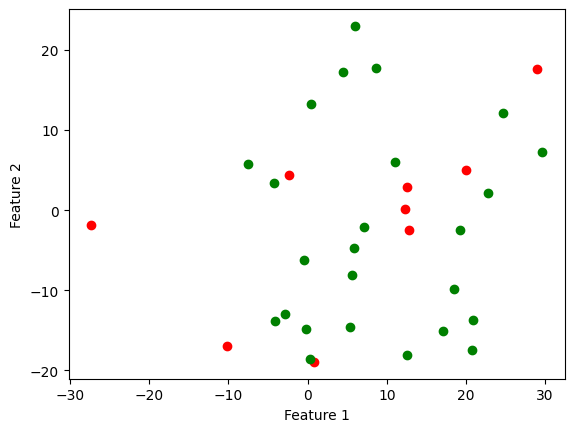

In [29]:
# DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Generate sample data
animals_index = [836,693,18,602,303,669,216,426,560,454]
vehicles_index = [516,50,913,33,818,838,691,178,95,300,902,936,162,6,545,582,607,910,170,721,830]
sports_index = [42,689,666,532,394,932,611,610,667,654,806,17,30,310,839,612,133,414,963,157,56,823,406,457, 964]
nature_index =[102,188,184,879,600,253,480,342,386]
objects_index =[757,500,345,799,81,373,521,652,898]

np.random.seed(42)
data = train['layer_8'][nature_index, :2]
data2 = train['layer_8'][sports_index, :2]
# Fit DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(data)

# Plot the results
plt.scatter(data[:, 0], data[:, 1], cmap='viridis', marker='o', color = 'red')
plt.scatter(data2[:, 0], data2[:, 1], cmap='viridis', marker='o', color = 'green')
#plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [ ]:
# DBSCAN
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs

# Generate sample data
#np.random.seed(42)
#data = train['layer_8'][:50,:2]


# Fit DBSCAN clustering
##dbscan = DBSCAN(eps=0.0001, min_samples=5)labels = dbscan.fit_predict(data)

# Plot the results
#plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o')
#plt.title('DBSCAN Clustering')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.show()

#print(data.shape)

In [ ]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append(f"layer_{i + 1}")

model_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  # activation_files = glob.glob(activations_dir + '/*' + f'{j}.npy')
  # # print(activation_files)
  # activation_files.sort()
  # activations = []
  # # Load all activations
  # for activation_file in activation_files:
  #   activations.append(np.load(activation_file))
  # activations = np.array(activations)
  # calculate Pearson's distance for all pairwise comparisons
  # DISSIMILARITY
  model_RDMs[layer] = 1- np.corrcoef(train[layer])

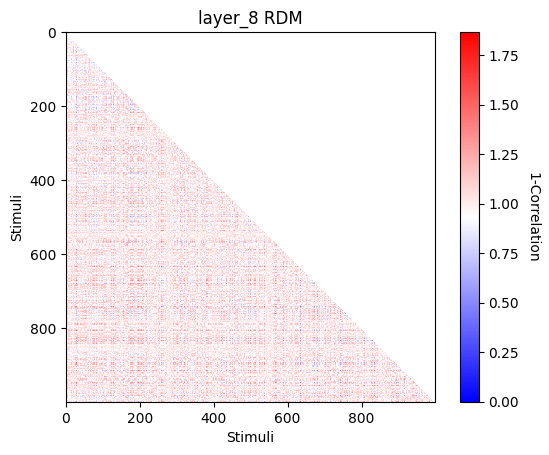

In [ ]:
# @title visualize model RDMs
layer = 'layer_8'  # @param ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']

# loading layer RDM
RDM = np.array(model_RDMs[layer])

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

# Visualize layer RDM
plt.imshow(RDM, cmap="bwr")
plt.title(layer + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)
plt.show()